### Uzair Riaz MSDS18016
### Fine-tuning VGG16 and RESNET18 on COVID19 dataset

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import random
import seaborn as sn
import pandas as pd

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### APIs: Replacing olf FC Layers with 2 New Layers

In [0]:
def get_updated_features(fc_layer1_in_features):
  ROLL_NO = 16 # 18016
  fc_layer1_out_features = (ROLL_NO * 10) + 100

  new_features = []

  new_features.extend([nn.Linear(fc_layer1_in_features, fc_layer1_out_features)])
  new_features.extend([nn.ReLU(inplace=True)])
  new_features.extend([nn.Dropout(p=0.5, inplace=False)])
  new_features.extend([nn.Linear(fc_layer1_out_features, len(class_names))])

  return new_features

### APIs: Plotting Training and Validation Curves for Accuracy and Loss

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as img
%matplotlib inline

def plot_loss_and_acc_curves(epochs, training_accuracy, training_loss, validation_accuracy, validation_loss):
  val_data_available = False
  if len(validation_accuracy) > 0:
    val_data_available = True
  fig_size = (12, 5)
  fig, axes = plt.subplots(1, 2, figsize=fig_size)
  x = np.arange(epochs)
  axes[0].plot(x, training_accuracy, color='red', label='Training Accuracy')
  if val_data_available:
    axes[0].plot(x, validation_accuracy, color='blue', label='Validation Accuracy')
  axes[0].set_title("Accuracy")
  axes[0].set_xlabel("Epochs")
  axes[0].legend()

  axes[1].plot(x, training_loss, color='red', label='Training Loss')
  if val_data_available:
    axes[1].plot(x, validation_loss, color='blue', label='Validation Loss')
  axes[1].set_title("Error/Loss")
  axes[1].set_xlabel("Epochs")
  axes[1].legend()

### APIs: Confusion Matrix, Accuracy and F1-Score

In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

def display_model_evaluation_parameters(model, loader, datatype):
  dataiter = iter(loader)
  images, labels = dataiter.next()

  CC=0
  TP=0
  FP=0
  FN=0
  N=0
  total = 0
  ground_truth = []
  predicted_labels = []
  with torch.no_grad():
      for data in loader:        
          images, labels = data
          images, labels = images.to(device), labels.to(device)
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          for i in predicted:
            predicted_labels.append(i.item())
          for i in labels:
            ground_truth.append(i.item())
          total += labels.size(0)
          CC += (predicted == labels).sum().item()

          BATCH_SIZE = labels.size(0)
          one_hot_labels = torch.zeros([BATCH_SIZE, NO_OF_CLASSES], dtype=torch.float32)
          for i in range(BATCH_SIZE):
            if labels[i] == LABEL_COVID_19:
              one_hot_labels[i][LABEL_PNEUMONIA] = 1
              one_hot_labels[i][LABEL_COVID_19] = 1
            elif labels[i] == LABEL_PNEUMONIA:
              one_hot_labels[i][LABEL_PNEUMONIA] = 1
            elif labels[i] == LABEL_NORMAL:
              one_hot_labels[i][LABEL_NORMAL] = 1

          images, one_hot_labels = images.to(device), one_hot_labels.to(device)
          outputs = labels_Classification(torch.sigmoid(model(images)),BATCH_SIZE)
          CC += ((outputs == one_hot_labels).sum().item())/(NO_OF_CLASSES)
          TP += (((one_hot_labels ==outputs) & (one_hot_labels == 1)).sum().item())/(NO_OF_CLASSES)
          FP += (((one_hot_labels !=outputs) & (outputs == 1)).sum().item())/(NO_OF_CLASSES)
          FN += (((one_hot_labels !=outputs) & (outputs == 1)).sum().item())/(NO_OF_CLASSES)
          N  += BATCH_SIZE



  Accuracy = 100*CC/N 
  Precision = 1
  if TP >0:
    precision = (TP/(TP+FP))/N
    Recall     = (TP/(TP+FN))/N
  F1_Score = (2*precision+Recall)/(precision + Recall)
  #print('Number of samples = %f'%(datatype,N))
  print('Accuracy = %f'%(Accuracy))
  print('precesion = %f'%(precision)) 
  print('Recall = %f'%(Recall))
  print('F1-Score = %f'%(F1_Score))  
  print("##########################")


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
def to_one_hot_encoded_labels(labels, BATCH_SIZE):        
  one_hot_labels = torch.zeros([BATCH_SIZE, NO_OF_CLASSES])
  for i in range(BATCH_SIZE):
    if labels[i] == LABEL_COVID_19:
      one_hot_labels[i][LABEL_PNEUMONIA] = 1
      one_hot_labels[i][LABEL_COVID_19] = 1
    elif labels[i] == LABEL_PNEUMONIA:
      one_hot_labels[i][LABEL_PNEUMONIA] = 1
    elif labels[i] == LABEL_NORMAL:
      one_hot_labels[i][LABEL_NORMAL] = 1

  return one_hot_labels

def classify_labels_wrt_probabilities(outputs, BATCH_SIZE):
  for i in range(BATCH_SIZE):
    for j in range(NO_OF_CLASSES):
      if outputs[i][j] > CLASS_ASSIGNMENT_THRESHOLD:
        outputs[i][j] = 1
      else:
        outputs[i][j] = 0
  
  return outputs

def CORRECT_CLASSIFICATION(outputs, one_hot_labels, BATCH_SIZE):
  count = 0
  for i in range(BATCH_SIZE):
    for j in range(NO_OF_CLASSES):
      if outputs[i][j] > CLASS_ASSIGNMENT_THRESHOLD:
        outputs[i][j] = 1
      else:
        outputs[i][j] = 0

  print("outputs",outputs)
  print("hot vector",one_hot_labels)


  for i in range(BATCH_SIZE):
    if (outputs[i] == one_hot_labels[i]).sum().item() == NO_OF_CLASSES:
      count += 1

  return count

def labels_Classification(outputs, BATCH_SIZE):

  for i in range(BATCH_SIZE):
    for j in range(NO_OF_CLASSES):
      if outputs[i][j] > CLASS_ASSIGNMENT_THRESHOLD:
        outputs[i][j] = 1
      else:
        outputs[i][j] = 0
  return outputs

### Saved Models Path

In [0]:
# Change this path if models are stored elsewhere
save_models_path = "./gdrive/My Drive/Assignment5_Part2/SavedModels/"

### Load Dataset usign torchvision image loader

In [0]:
from google.colab import drive
drive.mount("./gdrive")
!unzip './gdrive/My Drive/Assignment5_Part2/A_05_Part_02_Dataset.zip'

Drive already mounted at ./gdrive; to attempt to forcibly remount, call drive.mount("./gdrive", force_remount=True).
Archive:  ./gdrive/My Drive/Assignment5_Part2/A_05_Part_02_Dataset.zip
replace A_05_Part_02_Dataset/Test/0.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


### Path for un-zipped dataset

In [0]:
data_dir = "/content/A_05_Part_02_Dataset"

In [0]:
random.seed(1)

#Batch Size
BATCH_SIZE = 30

#Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(10),
                                       transforms.RandomResizedCrop(size=224, scale=(0.9,1.0)),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.RandomResizedCrop(size=224, scale=(0.9,1.0)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

val_transforms = transforms.Compose([transforms.RandomResizedCrop(size=224, scale=(0.9,1.0)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

#pass transform here-in
train_data = datasets.ImageFolder(data_dir + '/Train', transform=train_transforms)
# test_data = datasets.ImageFolder(data_dir + '/Test', transform=test_transforms)
validation_data = datasets.ImageFolder(data_dir + '/Validation', transform=test_transforms)

#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
# testloader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)
validationloader = torch.utils.data.DataLoader(validation_data, batch_size=BATCH_SIZE, shuffle=True)

print("Classes: ")
class_names = train_data.classes
print(class_names)
NO_OF_CLASSES = len(class_names)
CLASS_ASSIGNMENT_THRESHOLD = 0.5
LABEL_COVID_19 = class_names.index("covid-19")
LABEL_NORMAL = class_names.index("normal")
LABEL_PNEUMONIA = class_names.index("pneumonia")
print(LABEL_COVID_19)
print(LABEL_NORMAL)
print(LABEL_PNEUMONIA)

Classes: 
['covid-19', 'normal', 'pneumonia']
0
1
2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


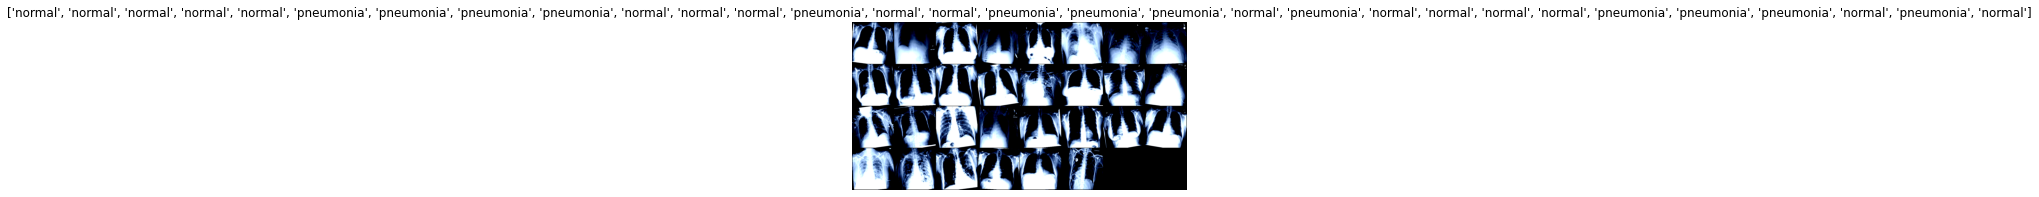

In [0]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(trainloader))
show_databatch(inputs, classes)

# TASK 1: VGG16 with BCELogitloss


### Load pre-trained VGG-16

In [0]:
# Load the pretrained model from pytorch
model = models.vgg16(pretrained=True)
print(model)
print('Output Layer of VGG16 : ', model.classifier[6].out_features) # 1000 

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Replacing old FC Layers with 2 New FC Layers

In [0]:
new_features = get_updated_features(model.classifier[0].in_features)
model.classifier = nn.Sequential(*new_features)
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Loss Function, Optimizer and Training

In [0]:
random.seed(1)

# Loss function and Optimizer
Epochs = 5
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

from tqdm import tqdm

training_accuracy = []
training_loss = []
validation_accuracy = []
validation_loss = []
model.to(device)
model.train()
for epoch in range(Epochs):  # loop over the dataset multiple times
    train_correct_count = 0
    val_correct_count = 0
    running_train_loss = 0.0
    running_val_loss = 0.0
    total = 0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        BATCH_SIZE = labels.size(0)
        one_hot_labels = torch.zeros([BATCH_SIZE, NO_OF_CLASSES], dtype=torch.float32)
        for i in range(BATCH_SIZE):
          if labels[i] == LABEL_COVID_19:
            one_hot_labels[i][LABEL_PNEUMONIA] = 1
            one_hot_labels[i][LABEL_COVID_19] = 1
          elif labels[i] == LABEL_PNEUMONIA:
            one_hot_labels[i][LABEL_PNEUMONIA] = 1
          elif labels[i] == LABEL_NORMAL:
            one_hot_labels[i][LABEL_NORMAL] = 1

        
        #one_hot_labels = to_one_hot_encoded_labels(labels, BATCH_SIZE)
        inputs, one_hot_labels = inputs.to(device), one_hot_labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)               #----> forward pass
        loss = criterion(outputs, one_hot_labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        total += BATCH_SIZE
        running_train_loss += loss.item()
        
        train_correct_count += CORRECT_CLASSIFICATION(torch.sigmoid(model(inputs)), one_hot_labels, BATCH_SIZE)

        print("Correct values at Training",train_correct_count)
        print("Total Values at train ",total)
    val_total = 0

    with torch.no_grad():
      for data in validationloader:  
          images, labels = data
          BATCH_SIZE = labels.size(0)
          one_hot_labels = torch.zeros([BATCH_SIZE, NO_OF_CLASSES], dtype=torch.float32)
          for i in range(BATCH_SIZE):
            if labels[i] == LABEL_COVID_19:
              one_hot_labels[i][LABEL_PNEUMONIA] = 1
              one_hot_labels[i][LABEL_COVID_19] = 1
            elif labels[i] == LABEL_PNEUMONIA:
              one_hot_labels[i][LABEL_PNEUMONIA] = 1
            elif labels[i] == LABEL_NORMAL:
              one_hot_labels[i][LABEL_NORMAL] = 1
          #one_hot_labels = to_one_hot_encoded_labels(labels, BATCH_SIZE)
          images, one_hot_labels = images.to(device), one_hot_labels.to(device)
          outputs = model(images)
          loss = criterion(outputs, one_hot_labels)   #----> compute loss
          val_total += BATCH_SIZE
          running_val_loss += loss.item()
          #labels_Classification
          #val_correct_count += CORRECT_CLASSIFICATION(torch.sigmoid(outputs), one_hot_labels, BATCH_SIZE)
          val_correct_count += CORRECT_CLASSIFICATION(torch.sigmoid(outputs), one_hot_labels,BATCH_SIZE)
          
          print("Correct values at Validation",val_correct_count)
          print("Total Values at valid ",val_total)
    validation_accuracy.append(val_correct_count/val_total)
    validation_loss.append(running_val_loss)
    training_loss.append(running_train_loss)
    training_accuracy.append(train_correct_count/total)
    print("Epoch = %d, accuracy = %f, error = %f" %(epoch, train_correct_count/total, running_train_loss))

print('Finished Training')
print(training_loss)
print(training_accuracy)


print("Confusion Matrix")

arra=[[TP,FP],[FN,TN]]
conf_matrix = pd.Dataframe(arra,index = [i for i in reversed(range(2))],columns = [i for i in reversed(range(2))])
plt.figure(figsize=(5,4))
sn.heatmap(conf_matrix)




0it [00:00, ?it/s]


1it [00:01,  1.21s/it]

Epoch = 0, accuracy = 0.366667, error = 0.780029





2it [00:02,  1.20s/it]

Epoch = 0, accuracy = 0.466667, error = 1.530475





3it [00:03,  1.20s/it]

Epoch = 0, accuracy = 0.577778, error = 2.227655





4it [00:04,  1.21s/it]

Epoch = 0, accuracy = 0.597222, error = 2.874833





5it [00:06,  1.26s/it]

Epoch = 0, accuracy = 0.622222, error = 3.469683





6it [00:07,  1.25s/it]

Epoch = 0, accuracy = 0.646296, error = 4.026789





7it [00:08,  1.27s/it]

Epoch = 0, accuracy = 0.657143, error = 4.541617





8it [00:09,  1.26s/it]

Epoch = 0, accuracy = 0.676389, error = 4.995490





9it [00:11,  1.23s/it]

Epoch = 0, accuracy = 0.695062, error = 5.377133





10it [00:12,  1.22s/it]

Epoch = 0, accuracy = 0.706667, error = 5.770568





11it [00:13,  1.24s/it]

Epoch = 0, accuracy = 0.706061, error = 6.231409





12it [00:14,  1.23s/it]

Epoch = 0, accuracy = 0.713889, error = 6.602591





13it [00:16,  1.22s/it]

Epoch = 0, accuracy = 0.717949, error = 7.050550





14it [00:17,  1.22s/it]

Epoch = 0, accuracy = 0.719048, error = 7.532106





15it [00:18,  1.22s/it]

Epoch = 0, accuracy = 0.724444, error = 7.856213





16it [00:19,  1.21s/it]

Epoch = 0, accuracy = 0.724306, error = 8.371471





17it [00:20,  1.21s/it]

Epoch = 0, accuracy = 0.730719, error = 8.833689





18it [00:22,  1.21s/it]

Epoch = 0, accuracy = 0.737037, error = 9.198199





19it [00:23,  1.25s/it]

Epoch = 0, accuracy = 0.745614, error = 9.537969





20it [00:24,  1.23s/it]

Epoch = 0, accuracy = 0.751667, error = 9.882083





21it [00:25,  1.21s/it]

Epoch = 0, accuracy = 0.758730, error = 10.226272





22it [00:26,  1.21s/it]

Epoch = 0, accuracy = 0.764141, error = 10.563843





23it [00:28,  1.22s/it]

Epoch = 0, accuracy = 0.765217, error = 11.048179





24it [00:29,  1.22s/it]

Epoch = 0, accuracy = 0.772222, error = 11.360320





25it [00:30,  1.21s/it]

Epoch = 0, accuracy = 0.778222, error = 11.697955





26it [00:31,  1.22s/it]

Epoch = 0, accuracy = 0.782051, error = 12.019543





27it [00:33,  1.21s/it]

Epoch = 0, accuracy = 0.787654, error = 12.236950





28it [00:34,  1.21s/it]

Epoch = 0, accuracy = 0.790873, error = 12.536332





29it [00:35,  1.20s/it]

Epoch = 0, accuracy = 0.793487, error = 12.807578





30it [00:36,  1.20s/it]

Epoch = 0, accuracy = 0.797407, error = 13.107540





31it [00:37,  1.24s/it]

Epoch = 0, accuracy = 0.796057, error = 13.874068





32it [00:39,  1.23s/it]

Epoch = 0, accuracy = 0.796181, error = 14.363239





33it [00:40,  1.23s/it]

Epoch = 0, accuracy = 0.800000, error = 14.660063





34it [00:41,  1.22s/it]

Epoch = 0, accuracy = 0.800980, error = 15.009585





35it [00:42,  1.23s/it]

Epoch = 0, accuracy = 0.804444, error = 15.240038





36it [00:44,  1.24s/it]

Epoch = 0, accuracy = 0.805556, error = 15.674921





37it [00:45,  1.23s/it]

Epoch = 0, accuracy = 0.808108, error = 15.941969





38it [00:46,  1.21s/it]

Epoch = 0, accuracy = 0.811696, error = 16.168330





39it [00:47,  1.20s/it]

Epoch = 0, accuracy = 0.813960, error = 16.389760





40it [00:48,  1.20s/it]

Epoch = 0, accuracy = 0.817222, error = 16.651490





41it [00:50,  1.21s/it]

Epoch = 0, accuracy = 0.818157, error = 16.892665





42it [00:51,  1.20s/it]

Epoch = 0, accuracy = 0.820635, error = 17.090976





43it [00:52,  1.23s/it]

Epoch = 0, accuracy = 0.821189, error = 17.519844





44it [00:53,  1.22s/it]

Epoch = 0, accuracy = 0.822980, error = 17.738537





45it [00:54,  1.21s/it]

Epoch = 0, accuracy = 0.824691, error = 17.979224





46it [00:56,  1.20s/it]

Epoch = 0, accuracy = 0.826812, error = 18.127878





47it [00:57,  1.19s/it]

Epoch = 0, accuracy = 0.829551, error = 18.320347





48it [00:58,  1.21s/it]

Epoch = 0, accuracy = 0.830324, error = 18.742680





49it [00:59,  1.26s/it]

Epoch = 0, accuracy = 0.831746, error = 19.071906





50it [01:01,  1.24s/it]

Epoch = 0, accuracy = 0.832444, error = 19.340848





51it [01:02,  1.22s/it]

Epoch = 0, accuracy = 0.833987, error = 19.580329





52it [01:03,  1.24s/it]

Epoch = 0, accuracy = 0.834402, error = 19.921035





53it [01:04,  1.22s/it]

Epoch = 0, accuracy = 0.836268, error = 20.227483





54it [01:05,  1.22s/it]

Epoch = 0, accuracy = 0.838272, error = 20.521478





55it [01:07,  1.21s/it]

Epoch = 0, accuracy = 0.838990, error = 20.768051





56it [01:08,  1.20s/it]

Epoch = 0, accuracy = 0.840079, error = 21.019799





57it [01:09,  1.19s/it]

Epoch = 0, accuracy = 0.841131, error = 21.405516





58it [01:10,  1.19s/it]

Epoch = 0, accuracy = 0.843103, error = 21.561935





59it [01:11,  1.18s/it]

Epoch = 0, accuracy = 0.844821, error = 21.782122





60it [01:13,  1.18s/it]

Epoch = 0, accuracy = 0.846296, error = 22.008390





61it [01:14,  1.18s/it]

Epoch = 0, accuracy = 0.846630, error = 22.369846





62it [01:15,  1.18s/it]

Epoch = 0, accuracy = 0.846953, error = 22.633201





63it [01:16,  1.18s/it]

Epoch = 0, accuracy = 0.849030, error = 22.775652





64it [01:17,  1.23s/it]

Epoch = 0, accuracy = 0.849826, error = 23.105948





65it [01:19,  1.25s/it]

Epoch = 0, accuracy = 0.850427, error = 23.477290





66it [01:20,  1.23s/it]

Epoch = 0, accuracy = 0.852357, error = 23.678538





67it [01:21,  1.21s/it]

Epoch = 0, accuracy = 0.853566, error = 23.915142





68it [01:22,  1.21s/it]

Epoch = 0, accuracy = 0.854739, error = 24.143855





69it [01:23,  1.20s/it]

Epoch = 0, accuracy = 0.856039, error = 24.314064





70it [01:25,  1.18s/it]

Epoch = 0, accuracy = 0.855873, error = 24.628853





71it [01:26,  1.18s/it]

Epoch = 0, accuracy = 0.856651, error = 24.857838





72it [01:27,  1.18s/it]

Epoch = 0, accuracy = 0.857407, error = 25.081336





73it [01:28,  1.18s/it]

Epoch = 0, accuracy = 0.858600, error = 25.313807





74it [01:29,  1.17s/it]

Epoch = 0, accuracy = 0.859459, error = 25.531196





75it [01:30,  1.18s/it]

Epoch = 0, accuracy = 0.860000, error = 25.790381





76it [01:32,  1.18s/it]

Epoch = 0, accuracy = 0.860819, error = 25.988598





77it [01:33,  1.18s/it]

Epoch = 0, accuracy = 0.861328, error = 26.202559





78it [01:34,  1.17s/it]

Epoch = 0, accuracy = 0.862251, error = 26.384610





79it [01:35,  1.22s/it]

Epoch = 0, accuracy = 0.862588, error = 26.696366





80it [01:36,  1.21s/it]

Epoch = 0, accuracy = 0.862500, error = 26.922195





81it [01:38,  1.20s/it]

Epoch = 0, accuracy = 0.863512, error = 27.189092





82it [01:39,  1.19s/it]

Epoch = 0, accuracy = 0.864092, error = 27.390886





83it [01:40,  1.18s/it]

Epoch = 0, accuracy = 0.865194, error = 27.571235





84it [01:41,  1.18s/it]

Epoch = 0, accuracy = 0.865741, error = 27.785096





85it [01:42,  1.18s/it]

Epoch = 0, accuracy = 0.866536, error = 28.084143





86it [01:43,  1.18s/it]

Epoch = 0, accuracy = 0.867183, error = 28.425051





87it [01:45,  1.17s/it]

Epoch = 0, accuracy = 0.868072, error = 28.569383





88it [01:46,  1.28s/it]

Epoch = 0, accuracy = 0.867803, error = 28.839912





89it [01:47,  1.26s/it]

Epoch = 0, accuracy = 0.869039, error = 28.950427





90it [01:49,  1.23s/it]

Epoch = 0, accuracy = 0.869877, error = 29.135055





91it [01:50,  1.21s/it]

Epoch = 0, accuracy = 0.870330, error = 29.428294





92it [01:51,  1.20s/it]

Epoch = 0, accuracy = 0.870773, error = 29.635796





93it [01:52,  1.19s/it]

Epoch = 0, accuracy = 0.871087, error = 29.810280





94it [01:53,  1.18s/it]

Epoch = 0, accuracy = 0.872104, error = 29.956843





95it [01:54,  1.21s/it]

Epoch = 0, accuracy = 0.872865, error = 30.102572





96it [01:56,  1.24s/it]

Epoch = 0, accuracy = 0.873727, error = 30.276067





97it [01:57,  1.22s/it]

Epoch = 0, accuracy = 0.873654, error = 30.552195





98it [01:58,  1.21s/it]

Epoch = 0, accuracy = 0.873810, error = 30.770019





99it [01:59,  1.20s/it]

Epoch = 0, accuracy = 0.874635, error = 30.923995





100it [02:01,  1.20s/it]

Epoch = 0, accuracy = 0.875556, error = 31.088785





101it [02:02,  1.19s/it]

Epoch = 0, accuracy = 0.876568, error = 31.186296





102it [02:03,  1.24s/it]

Epoch = 0, accuracy = 0.876688, error = 31.550143





103it [02:05,  1.35s/it]

Epoch = 0, accuracy = 0.876699, error = 31.861649





104it [02:06,  1.29s/it]

Epoch = 0, accuracy = 0.876709, error = 31.995421





105it [02:07,  1.26s/it]

Epoch = 0, accuracy = 0.877672, error = 32.125209





106it [02:08,  1.25s/it]

Epoch = 0, accuracy = 0.877987, error = 32.321677





107it [02:09,  1.23s/it]

Epoch = 0, accuracy = 0.878401, error = 32.535455





108it [02:11,  1.21s/it]

Epoch = 0, accuracy = 0.878807, error = 32.759720





109it [02:12,  1.20s/it]

Epoch = 0, accuracy = 0.879001, error = 33.037479





110it [02:13,  1.19s/it]

Epoch = 0, accuracy = 0.879697, error = 33.225716





111it [02:14,  1.20s/it]

Epoch = 0, accuracy = 0.880080, error = 33.444006





112it [02:15,  1.19s/it]

Epoch = 0, accuracy = 0.880159, error = 33.743113





113it [02:16,  1.18s/it]

Epoch = 0, accuracy = 0.880728, error = 33.927854





114it [02:18,  1.24s/it]

Epoch = 0, accuracy = 0.881287, error = 34.183838





115it [02:19,  1.21s/it]

Epoch = 0, accuracy = 0.881546, error = 34.372614





116it [02:20,  1.20s/it]

Epoch = 0, accuracy = 0.881609, error = 34.733686





117it [02:21,  1.20s/it]

Epoch = 0, accuracy = 0.882241, error = 34.864535





118it [02:23,  1.21s/it]

Epoch = 0, accuracy = 0.882580, error = 35.070852





119it [02:24,  1.20s/it]

Epoch = 0, accuracy = 0.883100, error = 35.245021





120it [02:25,  1.20s/it]

Epoch = 0, accuracy = 0.883796, error = 35.432137





121it [02:26,  1.27s/it]

Epoch = 0, accuracy = 0.883655, error = 35.793329





122it [02:28,  1.35s/it]

Epoch = 0, accuracy = 0.884062, error = 35.978786





123it [02:29,  1.30s/it]

Epoch = 0, accuracy = 0.884643, error = 36.110905





124it [02:31,  1.32s/it]

Epoch = 0, accuracy = 0.885394, error = 36.245336





125it [02:32,  1.28s/it]

Epoch = 0, accuracy = 0.885867, error = 36.420339





126it [02:33,  1.24s/it]

Epoch = 0, accuracy = 0.886332, error = 36.527575





127it [02:34,  1.23s/it]

Epoch = 0, accuracy = 0.886789, error = 36.664625





128it [02:35,  1.22s/it]

Epoch = 0, accuracy = 0.887240, error = 36.834787





129it [02:37,  1.34s/it]

Epoch = 0, accuracy = 0.886822, error = 37.175872





130it [02:38,  1.29s/it]

Epoch = 0, accuracy = 0.887350, error = 37.322700





131it [02:39,  1.25s/it]

Epoch = 0, accuracy = 0.887786, error = 37.473323





132it [02:40,  1.25s/it]

Epoch = 0, accuracy = 0.888131, error = 37.665032





133it [02:42,  1.23s/it]

Epoch = 0, accuracy = 0.888555, error = 37.811226





134it [02:43,  1.22s/it]

Epoch = 0, accuracy = 0.889138, error = 37.959837





135it [02:44,  1.20s/it]

Epoch = 0, accuracy = 0.889383, error = 38.206261





136it [02:45,  1.19s/it]

Epoch = 0, accuracy = 0.890196, error = 38.278306





137it [02:46,  1.19s/it]

Epoch = 0, accuracy = 0.890835, error = 38.417764





138it [02:47,  1.18s/it]

Epoch = 0, accuracy = 0.891304, error = 38.576625





139it [02:49,  1.18s/it]

Epoch = 0, accuracy = 0.891447, error = 38.776847





140it [02:50,  1.17s/it]

Epoch = 0, accuracy = 0.892063, error = 38.864691





141it [02:51,  1.17s/it]

Epoch = 0, accuracy = 0.892120, error = 39.143326





142it [02:52,  1.17s/it]

Epoch = 0, accuracy = 0.892332, error = 39.289258





143it [02:53,  1.17s/it]

Epoch = 0, accuracy = 0.892774, error = 39.424902





144it [02:54,  1.17s/it]

Epoch = 0, accuracy = 0.893441, error = 39.470562





145it [02:56,  1.16s/it]

Epoch = 0, accuracy = 0.894023, error = 39.541527





146it [02:57,  1.18s/it]

Epoch = 0, accuracy = 0.894521, error = 39.699908





147it [02:58,  1.17s/it]

Epoch = 0, accuracy = 0.894860, error = 39.815224





148it [02:59,  1.26s/it]

Epoch = 0, accuracy = 0.895420, error = 39.935171





149it [03:01,  1.37s/it]

Epoch = 0, accuracy = 0.895600, error = 40.285129





150it [03:02,  1.31s/it]

Epoch = 0, accuracy = 0.895407, error = 40.601029





151it [03:03,  1.26s/it]

Epoch = 0, accuracy = 0.895732, error = 40.711080





152it [03:05,  1.23s/it]

Epoch = 0, accuracy = 0.895906, error = 41.006441





153it [03:06,  1.21s/it]

Epoch = 0, accuracy = 0.895497, error = 41.401648





154it [03:07,  1.19s/it]

Epoch = 0, accuracy = 0.895887, error = 41.617492





155it [03:08,  1.21s/it]

Epoch = 0, accuracy = 0.895986, error = 41.803557





156it [03:09,  1.21s/it]

Epoch = 0, accuracy = 0.896011, error = 42.088066





157it [03:11,  1.22s/it]

Epoch = 0, accuracy = 0.896461, error = 42.200188





158it [03:12,  1.19s/it]

Epoch = 0, accuracy = 0.896414, error = 42.612860





159it [03:13,  1.19s/it]

Epoch = 0, accuracy = 0.896436, error = 43.071138





160it [03:14,  1.24s/it]

Epoch = 0, accuracy = 0.896736, error = 43.264619





161it [03:16,  1.27s/it]

Epoch = 0, accuracy = 0.896618, error = 43.622401





162it [03:17,  1.23s/it]

Epoch = 0, accuracy = 0.896776, error = 43.771999





163it [03:18,  1.26s/it]

Epoch = 0, accuracy = 0.896796, error = 43.982217





164it [03:19,  1.23s/it]

Epoch = 0, accuracy = 0.897087, error = 44.180541





165it [03:20,  1.25s/it]

Epoch = 0, accuracy = 0.896835, error = 44.554696





166it [03:22,  1.22s/it]

Epoch = 0, accuracy = 0.896921, error = 44.830364





167it [03:23,  1.22s/it]

Epoch = 0, accuracy = 0.896673, error = 45.173445





168it [03:24,  1.24s/it]

Epoch = 0, accuracy = 0.897024, error = 45.381210





169it [03:25,  1.26s/it]

Epoch = 0, accuracy = 0.896647, error = 45.708709





170it [03:27,  1.23s/it]

Epoch = 0, accuracy = 0.896667, error = 45.906136





171it [03:28,  1.21s/it]

Epoch = 0, accuracy = 0.897011, error = 46.012786





172it [03:29,  1.21s/it]

Epoch = 0, accuracy = 0.897287, error = 46.210299





173it [03:30,  1.19s/it]

Epoch = 0, accuracy = 0.897367, error = 46.516328





174it [03:31,  1.21s/it]

Epoch = 0, accuracy = 0.897573, error = 46.778047





175it [03:33,  1.19s/it]

Epoch = 0, accuracy = 0.897651, error = 46.967072





176it [03:34,  1.25s/it]

Epoch = 0, accuracy = 0.897538, error = 47.317228





177it [03:35,  1.22s/it]

Epoch = 0, accuracy = 0.897991, error = 47.419570





178it [03:36,  1.21s/it]

Epoch = 0, accuracy = 0.898252, error = 47.587695





179it [03:38,  1.27s/it]

Epoch = 0, accuracy = 0.898510, error = 47.747753





180it [03:39,  1.24s/it]

Epoch = 0, accuracy = 0.898827, error = 47.888097





181it [03:40,  1.26s/it]

Epoch = 0, accuracy = 0.899079, error = 48.104784





182it [03:41,  1.22s/it]

Epoch = 0, accuracy = 0.898779, error = 48.370048





183it [03:42,  1.20s/it]

Epoch = 0, accuracy = 0.898907, error = 48.598523





184it [03:44,  1.20s/it]

Epoch = 0, accuracy = 0.898973, error = 48.838870





185it [03:45,  1.22s/it]

Epoch = 0, accuracy = 0.899039, error = 49.016774





186it [03:46,  1.20s/it]

Epoch = 0, accuracy = 0.899462, error = 49.136643





187it [03:47,  1.20s/it]

Epoch = 0, accuracy = 0.899584, error = 49.311062





188it [03:48,  1.18s/it]

Epoch = 0, accuracy = 0.899764, error = 49.521681





189it [03:50,  1.17s/it]

Epoch = 0, accuracy = 0.899882, error = 49.661162





190it [03:51,  1.17s/it]

Epoch = 0, accuracy = 0.900058, error = 49.808437





191it [03:52,  1.30s/it]

Epoch = 0, accuracy = 0.900291, error = 49.938486





192it [03:53,  1.25s/it]

Epoch = 0, accuracy = 0.900521, error = 50.095855





193it [03:55,  1.25s/it]

Epoch = 0, accuracy = 0.900691, error = 50.238092





194it [03:56,  1.24s/it]

Epoch = 0, accuracy = 0.900745, error = 50.455298





195it [03:57,  1.21s/it]

Epoch = 0, accuracy = 0.900855, error = 50.753348





196it [03:58,  1.20s/it]

Epoch = 0, accuracy = 0.900737, error = 51.080414





197it [03:59,  1.20s/it]

Epoch = 0, accuracy = 0.900902, error = 51.201230





198it [04:01,  1.19s/it]

Epoch = 0, accuracy = 0.901235, error = 51.354999





199it [04:02,  1.17s/it]

Epoch = 0, accuracy = 0.901228, error = 51.558308





200it [04:03,  1.26s/it]

Epoch = 0, accuracy = 0.901111, error = 51.989462





201it [04:04,  1.23s/it]

Epoch = 0, accuracy = 0.901271, error = 52.130002





202it [04:06,  1.21s/it]

Epoch = 0, accuracy = 0.901540, error = 52.374741





203it [04:07,  1.19s/it]

Epoch = 0, accuracy = 0.901806, error = 52.508536





204it [04:08,  1.18s/it]

Epoch = 0, accuracy = 0.902070, error = 52.638229





205it [04:09,  1.17s/it]

Epoch = 0, accuracy = 0.902276, error = 52.832146





206it [04:10,  1.18s/it]

Epoch = 0, accuracy = 0.902427, error = 53.014649





207it [04:11,  1.22s/it]

Epoch = 0, accuracy = 0.902473, error = 53.208587






0it [00:00, ?it/s]

Epoch = 0, accuracy = 0.902473, error = 53.208587





1it [00:01,  1.19s/it]

Epoch = 1, accuracy = 0.933333, error = 0.129163





2it [00:02,  1.18s/it]

Epoch = 1, accuracy = 0.944444, error = 0.253503





3it [00:03,  1.17s/it]

Epoch = 1, accuracy = 0.900000, error = 0.674181





4it [00:04,  1.22s/it]

Epoch = 1, accuracy = 0.902778, error = 1.002714





5it [00:06,  1.21s/it]

Epoch = 1, accuracy = 0.911111, error = 1.190716





6it [00:07,  1.20s/it]

Epoch = 1, accuracy = 0.924074, error = 1.307091





7it [00:08,  1.19s/it]

Epoch = 1, accuracy = 0.928571, error = 1.488329





8it [00:09,  1.21s/it]

Epoch = 1, accuracy = 0.923611, error = 1.726749





9it [00:10,  1.19s/it]

Epoch = 1, accuracy = 0.922222, error = 1.946169





10it [00:11,  1.18s/it]

Epoch = 1, accuracy = 0.926667, error = 2.074899





11it [00:13,  1.23s/it]

Epoch = 1, accuracy = 0.923232, error = 2.335121





12it [00:14,  1.25s/it]

Epoch = 1, accuracy = 0.926852, error = 2.430880





13it [00:16,  1.32s/it]

Epoch = 1, accuracy = 0.923077, error = 2.702664





14it [00:17,  1.27s/it]

Epoch = 1, accuracy = 0.923810, error = 2.894361





15it [00:18,  1.24s/it]

Epoch = 1, accuracy = 0.921481, error = 3.148150





16it [00:19,  1.22s/it]

Epoch = 1, accuracy = 0.921528, error = 3.327088





17it [00:20,  1.20s/it]

Epoch = 1, accuracy = 0.924837, error = 3.440288





18it [00:21,  1.19s/it]

Epoch = 1, accuracy = 0.928395, error = 3.520754





19it [00:23,  1.18s/it]

Epoch = 1, accuracy = 0.929240, error = 3.721826





20it [00:24,  1.18s/it]

Epoch = 1, accuracy = 0.930556, error = 3.855850





21it [00:25,  1.18s/it]

Epoch = 1, accuracy = 0.931746, error = 3.977612





22it [00:26,  1.17s/it]

Epoch = 1, accuracy = 0.934343, error = 4.065594





23it [00:27,  1.18s/it]

Epoch = 1, accuracy = 0.933816, error = 4.280870





24it [00:28,  1.17s/it]

Epoch = 1, accuracy = 0.930556, error = 4.587915





25it [00:30,  1.18s/it]

Epoch = 1, accuracy = 0.931556, error = 4.714862





26it [00:31,  1.21s/it]

Epoch = 1, accuracy = 0.933333, error = 4.805154





27it [00:32,  1.22s/it]

Epoch = 1, accuracy = 0.934568, error = 4.932025





28it [00:33,  1.20s/it]

Epoch = 1, accuracy = 0.936111, error = 5.011179





29it [00:34,  1.20s/it]

Epoch = 1, accuracy = 0.936015, error = 5.142282





30it [00:36,  1.19s/it]

Epoch = 1, accuracy = 0.937037, error = 5.211823





31it [00:37,  1.18s/it]

Epoch = 1, accuracy = 0.937634, error = 5.294644





32it [00:38,  1.17s/it]

Epoch = 1, accuracy = 0.939583, error = 5.322057





33it [00:39,  1.21s/it]

Epoch = 1, accuracy = 0.938721, error = 5.532395





34it [00:40,  1.20s/it]

Epoch = 1, accuracy = 0.939542, error = 5.671046





35it [00:42,  1.19s/it]

Epoch = 1, accuracy = 0.939683, error = 5.820368





36it [00:43,  1.18s/it]

Epoch = 1, accuracy = 0.941049, error = 5.907084





37it [00:44,  1.18s/it]

Epoch = 1, accuracy = 0.942042, error = 6.002695





38it [00:45,  1.17s/it]

Epoch = 1, accuracy = 0.942982, error = 6.075181





39it [00:46,  1.17s/it]

Epoch = 1, accuracy = 0.943590, error = 6.283628





40it [00:47,  1.16s/it]

Epoch = 1, accuracy = 0.943611, error = 6.386812





41it [00:49,  1.17s/it]

Epoch = 1, accuracy = 0.943360, error = 6.452649





42it [00:50,  1.19s/it]

Epoch = 1, accuracy = 0.943386, error = 6.689680





43it [00:51,  1.21s/it]

Epoch = 1, accuracy = 0.942377, error = 7.037952





44it [00:52,  1.20s/it]

Epoch = 1, accuracy = 0.942677, error = 7.143873





45it [00:53,  1.20s/it]

Epoch = 1, accuracy = 0.941481, error = 7.542872





46it [00:55,  1.20s/it]

Epoch = 1, accuracy = 0.940097, error = 7.782736





47it [00:56,  1.23s/it]

Epoch = 1, accuracy = 0.939007, error = 7.983528





48it [00:57,  1.31s/it]

Epoch = 1, accuracy = 0.937963, error = 8.326412





49it [00:59,  1.26s/it]

Epoch = 1, accuracy = 0.939002, error = 8.538854





50it [01:00,  1.24s/it]

Epoch = 1, accuracy = 0.939333, error = 8.685647





51it [01:01,  1.39s/it]

Epoch = 1, accuracy = 0.938344, error = 9.064551





52it [01:03,  1.33s/it]

Epoch = 1, accuracy = 0.937179, error = 9.562606





53it [01:04,  1.28s/it]

Epoch = 1, accuracy = 0.937736, error = 9.719496





54it [01:05,  1.26s/it]

Epoch = 1, accuracy = 0.936214, error = 10.024407





55it [01:06,  1.24s/it]

Epoch = 1, accuracy = 0.935960, error = 10.328218





56it [01:07,  1.22s/it]

Epoch = 1, accuracy = 0.935714, error = 10.544018





57it [01:09,  1.20s/it]

Epoch = 1, accuracy = 0.936452, error = 10.692981





58it [01:10,  1.19s/it]

Epoch = 1, accuracy = 0.935824, error = 10.943072





59it [01:11,  1.18s/it]

Epoch = 1, accuracy = 0.934652, error = 11.221644





60it [01:12,  1.18s/it]

Epoch = 1, accuracy = 0.934074, error = 11.496177





61it [01:13,  1.19s/it]

Epoch = 1, accuracy = 0.933880, error = 11.703075





62it [01:15,  1.26s/it]

Epoch = 1, accuracy = 0.932258, error = 12.082644





63it [01:16,  1.23s/it]

Epoch = 1, accuracy = 0.932451, error = 12.279960





64it [01:17,  1.21s/it]

Epoch = 1, accuracy = 0.932292, error = 12.438904





65it [01:18,  1.20s/it]

Epoch = 1, accuracy = 0.932991, error = 12.574242





66it [01:19,  1.21s/it]

Epoch = 1, accuracy = 0.931481, error = 12.871381





67it [01:21,  1.19s/it]

Epoch = 1, accuracy = 0.931675, error = 13.041231





68it [01:22,  1.19s/it]

Epoch = 1, accuracy = 0.932026, error = 13.255567





69it [01:23,  1.18s/it]

Epoch = 1, accuracy = 0.932367, error = 13.430446





70it [01:24,  1.18s/it]

Epoch = 1, accuracy = 0.931429, error = 13.829737





71it [01:25,  1.17s/it]

Epoch = 1, accuracy = 0.931768, error = 13.952026





72it [01:26,  1.17s/it]

Epoch = 1, accuracy = 0.932562, error = 14.035200





73it [01:28,  1.23s/it]

Epoch = 1, accuracy = 0.933181, error = 14.095541





74it [01:29,  1.22s/it]

Epoch = 1, accuracy = 0.933483, error = 14.216882





75it [01:30,  1.20s/it]

Epoch = 1, accuracy = 0.933926, error = 14.296981





76it [01:31,  1.20s/it]

Epoch = 1, accuracy = 0.934357, error = 14.418662





77it [01:33,  1.36s/it]

Epoch = 1, accuracy = 0.934199, error = 14.623139





78it [01:34,  1.30s/it]

Epoch = 1, accuracy = 0.934330, error = 14.749551





79it [01:36,  1.28s/it]

Epoch = 1, accuracy = 0.934599, error = 14.903208





80it [01:37,  1.24s/it]

Epoch = 1, accuracy = 0.934722, error = 15.033947





81it [01:38,  1.22s/it]

Epoch = 1, accuracy = 0.935391, error = 15.090337





82it [01:39,  1.21s/it]

Epoch = 1, accuracy = 0.934824, error = 15.303019





83it [01:40,  1.25s/it]

Epoch = 1, accuracy = 0.934404, error = 15.629424





84it [01:42,  1.32s/it]

Epoch = 1, accuracy = 0.933862, error = 15.909865





85it [01:43,  1.28s/it]

Epoch = 1, accuracy = 0.933725, error = 16.109887





86it [01:44,  1.25s/it]

Epoch = 1, accuracy = 0.934109, error = 16.212209





87it [01:45,  1.22s/it]

Epoch = 1, accuracy = 0.934355, error = 16.344146





88it [01:47,  1.21s/it]

Epoch = 1, accuracy = 0.934596, error = 16.484883





89it [01:48,  1.24s/it]

Epoch = 1, accuracy = 0.934831, error = 16.600493





90it [01:49,  1.22s/it]

Epoch = 1, accuracy = 0.935432, error = 16.667952





91it [01:50,  1.24s/it]

Epoch = 1, accuracy = 0.935775, error = 16.809472





92it [01:52,  1.22s/it]

Epoch = 1, accuracy = 0.936111, error = 16.925952





93it [01:53,  1.22s/it]

Epoch = 1, accuracy = 0.936559, error = 17.029760





94it [01:54,  1.20s/it]

Epoch = 1, accuracy = 0.936643, error = 17.165212





95it [01:55,  1.20s/it]

Epoch = 1, accuracy = 0.936842, error = 17.304765





96it [01:56,  1.20s/it]

Epoch = 1, accuracy = 0.937269, error = 17.384069





97it [01:57,  1.20s/it]

Epoch = 1, accuracy = 0.937572, error = 17.466181





98it [01:59,  1.21s/it]

Epoch = 1, accuracy = 0.937415, error = 17.649570





99it [02:00,  1.24s/it]

Epoch = 1, accuracy = 0.936925, error = 17.952545





100it [02:01,  1.24s/it]

Epoch = 1, accuracy = 0.936889, error = 18.071173





101it [02:03,  1.34s/it]

Epoch = 1, accuracy = 0.936194, error = 18.272317





102it [02:04,  1.30s/it]

Epoch = 1, accuracy = 0.936710, error = 18.354495





103it [02:05,  1.30s/it]

Epoch = 1, accuracy = 0.936462, error = 18.633994





104it [02:07,  1.26s/it]

Epoch = 1, accuracy = 0.936966, error = 18.697082





105it [02:08,  1.24s/it]

Epoch = 1, accuracy = 0.937143, error = 18.853577





106it [02:09,  1.23s/it]

Epoch = 1, accuracy = 0.937212, error = 19.064956





107it [02:10,  1.22s/it]

Epoch = 1, accuracy = 0.937591, error = 19.198437





108it [02:11,  1.22s/it]

Epoch = 1, accuracy = 0.937243, error = 19.398259





109it [02:13,  1.24s/it]

Epoch = 1, accuracy = 0.936799, error = 19.736620





110it [02:14,  1.22s/it]

Epoch = 1, accuracy = 0.937172, error = 19.802011





111it [02:15,  1.22s/it]

Epoch = 1, accuracy = 0.937237, error = 19.897853





112it [02:16,  1.21s/it]

Epoch = 1, accuracy = 0.937302, error = 20.049232





113it [02:17,  1.22s/it]

Epoch = 1, accuracy = 0.937463, error = 20.217972





114it [02:19,  1.22s/it]

Epoch = 1, accuracy = 0.937622, error = 20.353481





115it [02:20,  1.21s/it]

Epoch = 1, accuracy = 0.937681, error = 20.495506





116it [02:21,  1.21s/it]

Epoch = 1, accuracy = 0.938123, error = 20.591182





117it [02:22,  1.20s/it]

Epoch = 1, accuracy = 0.938557, error = 20.702573





118it [02:24,  1.24s/it]

Epoch = 1, accuracy = 0.938701, error = 20.812285





119it [02:25,  1.24s/it]

Epoch = 1, accuracy = 0.938842, error = 20.922042





120it [02:26,  1.22s/it]

Epoch = 1, accuracy = 0.939167, error = 20.978261





121it [02:27,  1.22s/it]

Epoch = 1, accuracy = 0.939486, error = 21.074909





122it [02:28,  1.23s/it]

Epoch = 1, accuracy = 0.939891, error = 21.136813





123it [02:30,  1.22s/it]

Epoch = 1, accuracy = 0.939837, error = 21.309806





124it [02:31,  1.21s/it]

Epoch = 1, accuracy = 0.940054, error = 21.390504





125it [02:32,  1.21s/it]

Epoch = 1, accuracy = 0.939556, error = 21.698071





126it [02:33,  1.21s/it]

Epoch = 1, accuracy = 0.939594, error = 21.830853





127it [02:35,  1.32s/it]

Epoch = 1, accuracy = 0.939283, error = 22.028256





128it [02:36,  1.33s/it]

Epoch = 1, accuracy = 0.938976, error = 22.244545





129it [02:37,  1.30s/it]

Epoch = 1, accuracy = 0.938932, error = 22.427897





130it [02:39,  1.28s/it]

Epoch = 1, accuracy = 0.938462, error = 22.769049





131it [02:40,  1.25s/it]

Epoch = 1, accuracy = 0.938762, error = 22.866998





132it [02:41,  1.36s/it]

Epoch = 1, accuracy = 0.938889, error = 22.992608





133it [02:43,  1.31s/it]

Epoch = 1, accuracy = 0.939014, error = 23.150653





134it [02:44,  1.28s/it]

Epoch = 1, accuracy = 0.939386, error = 23.186663





135it [02:45,  1.26s/it]

Epoch = 1, accuracy = 0.939259, error = 23.384151





136it [02:46,  1.25s/it]

Epoch = 1, accuracy = 0.939461, error = 23.529033





137it [02:48,  1.26s/it]

Epoch = 1, accuracy = 0.939254, error = 23.749210





138it [02:49,  1.25s/it]

Epoch = 1, accuracy = 0.939694, error = 23.822148





139it [02:50,  1.24s/it]

Epoch = 1, accuracy = 0.939888, error = 23.887434





140it [02:51,  1.23s/it]

Epoch = 1, accuracy = 0.940000, error = 24.041756





141it [02:52,  1.24s/it]

Epoch = 1, accuracy = 0.939480, error = 24.327834





142it [02:54,  1.34s/it]

Epoch = 1, accuracy = 0.939358, error = 24.470858





143it [02:55,  1.30s/it]

Epoch = 1, accuracy = 0.939083, error = 24.634605





144it [02:57,  1.29s/it]

Epoch = 1, accuracy = 0.939198, error = 24.785633





145it [02:58,  1.26s/it]

Epoch = 1, accuracy = 0.939387, error = 24.942635





146it [02:59,  1.25s/it]

Epoch = 1, accuracy = 0.939422, error = 25.102402





147it [03:00,  1.23s/it]

Epoch = 1, accuracy = 0.939078, error = 25.485681





148it [03:01,  1.25s/it]

Epoch = 1, accuracy = 0.939489, error = 25.581160





149it [03:03,  1.24s/it]

Epoch = 1, accuracy = 0.939746, error = 25.706286





150it [03:04,  1.24s/it]

Epoch = 1, accuracy = 0.939926, error = 25.833849





151it [03:05,  1.27s/it]

Epoch = 1, accuracy = 0.940029, error = 25.953504





152it [03:06,  1.25s/it]

Epoch = 1, accuracy = 0.939985, error = 26.156185





153it [03:08,  1.26s/it]

Epoch = 1, accuracy = 0.940232, error = 26.235955





154it [03:09,  1.26s/it]

Epoch = 1, accuracy = 0.940188, error = 26.448326





155it [03:10,  1.25s/it]

Epoch = 1, accuracy = 0.940358, error = 26.524670





156it [03:11,  1.24s/it]

Epoch = 1, accuracy = 0.940313, error = 26.701092





157it [03:13,  1.24s/it]

Epoch = 1, accuracy = 0.939844, error = 26.961137





158it [03:14,  1.23s/it]

Epoch = 1, accuracy = 0.939803, error = 27.071708





159it [03:15,  1.22s/it]

Epoch = 1, accuracy = 0.939693, error = 27.238065





160it [03:16,  1.25s/it]

Epoch = 1, accuracy = 0.939444, error = 27.480846





161it [03:18,  1.24s/it]

Epoch = 1, accuracy = 0.939821, error = 27.545176





162it [03:19,  1.24s/it]

Epoch = 1, accuracy = 0.940055, error = 27.610590





163it [03:20,  1.23s/it]

Epoch = 1, accuracy = 0.939945, error = 27.784501





164it [03:21,  1.22s/it]

Epoch = 1, accuracy = 0.940312, error = 27.858656





165it [03:23,  1.24s/it]

Epoch = 1, accuracy = 0.940337, error = 28.123130





166it [03:24,  1.23s/it]

Epoch = 1, accuracy = 0.940495, error = 28.206854





167it [03:25,  1.26s/it]

Epoch = 1, accuracy = 0.940652, error = 28.356618





168it [03:27,  1.32s/it]

Epoch = 1, accuracy = 0.940873, error = 28.426812





169it [03:28,  1.28s/it]

Epoch = 1, accuracy = 0.940565, error = 28.784762





170it [03:29,  1.27s/it]

Epoch = 1, accuracy = 0.940588, error = 28.927775





171it [03:30,  1.25s/it]

Epoch = 1, accuracy = 0.940546, error = 29.116308





172it [03:31,  1.27s/it]

Epoch = 1, accuracy = 0.940245, error = 29.380370





173it [03:33,  1.25s/it]

Epoch = 1, accuracy = 0.940398, error = 29.493531





174it [03:34,  1.24s/it]

Epoch = 1, accuracy = 0.940294, error = 29.646083





175it [03:35,  1.23s/it]

Epoch = 1, accuracy = 0.940571, error = 29.717599





176it [03:36,  1.23s/it]

Epoch = 1, accuracy = 0.940530, error = 29.938908





177it [03:38,  1.23s/it]

Epoch = 1, accuracy = 0.940615, error = 30.088089





178it [03:39,  1.23s/it]

Epoch = 1, accuracy = 0.940824, error = 30.191533





179it [03:40,  1.24s/it]

Epoch = 1, accuracy = 0.940782, error = 30.415910





180it [03:41,  1.24s/it]

Epoch = 1, accuracy = 0.940864, error = 30.497861





181it [03:43,  1.23s/it]

Epoch = 1, accuracy = 0.940884, error = 30.634362





182it [03:44,  1.22s/it]

Epoch = 1, accuracy = 0.940904, error = 30.817478





183it [03:45,  1.22s/it]

Epoch = 1, accuracy = 0.940984, error = 30.937319





184it [03:46,  1.22s/it]

Epoch = 1, accuracy = 0.940882, error = 31.133090





185it [03:47,  1.24s/it]

Epoch = 1, accuracy = 0.940901, error = 31.408724





186it [03:49,  1.27s/it]

Epoch = 1, accuracy = 0.940741, error = 31.646750





187it [03:50,  1.26s/it]

Epoch = 1, accuracy = 0.940998, error = 31.735146





188it [03:51,  1.24s/it]

Epoch = 1, accuracy = 0.941135, error = 31.828072





189it [03:53,  1.26s/it]

Epoch = 1, accuracy = 0.941035, error = 32.041444





190it [03:54,  1.25s/it]

Epoch = 1, accuracy = 0.941228, error = 32.174191





191it [03:55,  1.23s/it]

Epoch = 1, accuracy = 0.941536, error = 32.249992





192it [03:56,  1.23s/it]

Epoch = 1, accuracy = 0.941782, error = 32.294227





193it [03:57,  1.22s/it]

Epoch = 1, accuracy = 0.941969, error = 32.357603





194it [03:59,  1.22s/it]

Epoch = 1, accuracy = 0.941810, error = 32.550621





195it [04:00,  1.27s/it]

Epoch = 1, accuracy = 0.941538, error = 32.769018





196it [04:01,  1.33s/it]

Epoch = 1, accuracy = 0.941440, error = 32.976366





197it [04:03,  1.37s/it]

Epoch = 1, accuracy = 0.941624, error = 33.129681





198it [04:04,  1.32s/it]

Epoch = 1, accuracy = 0.941582, error = 33.339011





199it [04:05,  1.28s/it]

Epoch = 1, accuracy = 0.941709, error = 33.380786





200it [04:07,  1.26s/it]

Epoch = 1, accuracy = 0.941778, error = 33.632392





201it [04:08,  1.25s/it]

Epoch = 1, accuracy = 0.941791, error = 33.770967





202it [04:09,  1.24s/it]

Epoch = 1, accuracy = 0.941914, error = 33.846323





203it [04:10,  1.24s/it]

Epoch = 1, accuracy = 0.941653, error = 34.168614





204it [04:11,  1.24s/it]

Epoch = 1, accuracy = 0.941885, error = 34.245301





205it [04:13,  1.27s/it]

Epoch = 1, accuracy = 0.941897, error = 34.384548





206it [04:14,  1.26s/it]

Epoch = 1, accuracy = 0.941963, error = 34.557396





207it [04:15,  1.23s/it]

Epoch = 1, accuracy = 0.941989, error = 34.636616






0it [00:00, ?it/s]

Epoch = 1, accuracy = 0.941989, error = 34.636616





1it [00:01,  1.26s/it]

Epoch = 2, accuracy = 0.966667, error = 0.113386





2it [00:02,  1.32s/it]

Epoch = 2, accuracy = 0.961111, error = 0.222308





3it [00:03,  1.29s/it]

Epoch = 2, accuracy = 0.948148, error = 0.430766





4it [00:05,  1.26s/it]

Epoch = 2, accuracy = 0.952778, error = 0.613527





5it [00:06,  1.40s/it]

Epoch = 2, accuracy = 0.955556, error = 0.808843





6it [00:08,  1.38s/it]

Epoch = 2, accuracy = 0.955556, error = 0.879317





7it [00:09,  1.34s/it]

Epoch = 2, accuracy = 0.960317, error = 0.948917





8it [00:10,  1.30s/it]

Epoch = 2, accuracy = 0.965278, error = 0.986822





9it [00:11,  1.28s/it]

Epoch = 2, accuracy = 0.966667, error = 1.098311





10it [00:13,  1.26s/it]

Epoch = 2, accuracy = 0.970000, error = 1.129363





11it [00:14,  1.34s/it]

Epoch = 2, accuracy = 0.970707, error = 1.205127





12it [00:15,  1.30s/it]

Epoch = 2, accuracy = 0.971296, error = 1.280523





13it [00:17,  1.27s/it]

Epoch = 2, accuracy = 0.970085, error = 1.382063





14it [00:18,  1.25s/it]

Epoch = 2, accuracy = 0.970635, error = 1.441610





15it [00:19,  1.28s/it]

Epoch = 2, accuracy = 0.967407, error = 1.650703





16it [00:20,  1.28s/it]

Epoch = 2, accuracy = 0.965278, error = 1.830781





17it [00:22,  1.31s/it]

Epoch = 2, accuracy = 0.966667, error = 1.885745





18it [00:23,  1.29s/it]

Epoch = 2, accuracy = 0.968519, error = 1.907003





19it [00:24,  1.27s/it]

Epoch = 2, accuracy = 0.964912, error = 2.222724





20it [00:26,  1.28s/it]

Epoch = 2, accuracy = 0.965556, error = 2.274761





21it [00:27,  1.26s/it]

Epoch = 2, accuracy = 0.967196, error = 2.319029





22it [00:28,  1.24s/it]

Epoch = 2, accuracy = 0.966162, error = 2.460545





23it [00:29,  1.23s/it]

Epoch = 2, accuracy = 0.964251, error = 2.675683





24it [00:30,  1.23s/it]

Epoch = 2, accuracy = 0.964815, error = 2.787375





25it [00:32,  1.25s/it]

Epoch = 2, accuracy = 0.962667, error = 3.034835





26it [00:33,  1.24s/it]

Epoch = 2, accuracy = 0.963248, error = 3.162959





27it [00:34,  1.23s/it]

Epoch = 2, accuracy = 0.963786, error = 3.216318





28it [00:35,  1.23s/it]

Epoch = 2, accuracy = 0.962302, error = 3.366720





29it [00:37,  1.23s/it]

Epoch = 2, accuracy = 0.962069, error = 3.487328





30it [00:38,  1.22s/it]

Epoch = 2, accuracy = 0.960370, error = 3.707549





31it [00:39,  1.25s/it]

Epoch = 2, accuracy = 0.959140, error = 3.894635





32it [00:40,  1.25s/it]

Epoch = 2, accuracy = 0.957986, error = 4.194643





33it [00:42,  1.36s/it]

Epoch = 2, accuracy = 0.958249, error = 4.327426





34it [00:43,  1.31s/it]

Epoch = 2, accuracy = 0.958824, error = 4.478503





35it [00:44,  1.28s/it]

Epoch = 2, accuracy = 0.959365, error = 4.561928





36it [00:46,  1.27s/it]

Epoch = 2, accuracy = 0.958951, error = 4.709339





37it [00:47,  1.27s/it]

Epoch = 2, accuracy = 0.959159, error = 4.792488





38it [00:48,  1.25s/it]

Epoch = 2, accuracy = 0.957310, error = 5.010971





39it [00:49,  1.25s/it]

Epoch = 2, accuracy = 0.957265, error = 5.132887





40it [00:51,  1.24s/it]

Epoch = 2, accuracy = 0.957778, error = 5.252888





41it [00:52,  1.24s/it]

Epoch = 2, accuracy = 0.958266, error = 5.344405





42it [00:53,  1.34s/it]

Epoch = 2, accuracy = 0.957143, error = 5.542923





43it [00:55,  1.31s/it]

Epoch = 2, accuracy = 0.957881, error = 5.591362





44it [00:56,  1.28s/it]

Epoch = 2, accuracy = 0.957828, error = 5.709804





45it [00:57,  1.26s/it]

Epoch = 2, accuracy = 0.956790, error = 5.870162





46it [00:58,  1.24s/it]

Epoch = 2, accuracy = 0.957246, error = 5.945916





47it [00:59,  1.23s/it]

Epoch = 2, accuracy = 0.958156, error = 5.990923





48it [01:01,  1.24s/it]

Epoch = 2, accuracy = 0.957407, error = 6.131663





49it [01:02,  1.23s/it]

Epoch = 2, accuracy = 0.956916, error = 6.322373





50it [01:03,  1.23s/it]

Epoch = 2, accuracy = 0.957333, error = 6.432787





51it [01:04,  1.26s/it]

Epoch = 2, accuracy = 0.956645, error = 6.638169





52it [01:06,  1.26s/it]

Epoch = 2, accuracy = 0.955556, error = 6.943513





53it [01:07,  1.25s/it]

Epoch = 2, accuracy = 0.955136, error = 7.095921





54it [01:08,  1.24s/it]

Epoch = 2, accuracy = 0.954321, error = 7.215395





55it [01:09,  1.25s/it]

Epoch = 2, accuracy = 0.954343, error = 7.389631





56it [01:11,  1.24s/it]

Epoch = 2, accuracy = 0.954563, error = 7.500994





57it [01:12,  1.24s/it]

Epoch = 2, accuracy = 0.955361, error = 7.536444





58it [01:13,  1.24s/it]

Epoch = 2, accuracy = 0.955364, error = 7.665534





59it [01:14,  1.23s/it]

Epoch = 2, accuracy = 0.955179, error = 7.861560





60it [01:16,  1.23s/it]

Epoch = 2, accuracy = 0.954815, error = 7.989105





61it [01:17,  1.23s/it]

Epoch = 2, accuracy = 0.954098, error = 8.199927





62it [01:18,  1.23s/it]

Epoch = 2, accuracy = 0.953405, error = 8.495864





63it [01:19,  1.29s/it]

Epoch = 2, accuracy = 0.954145, error = 8.576327





64it [01:21,  1.27s/it]

Epoch = 2, accuracy = 0.954514, error = 8.694629





65it [01:22,  1.26s/it]

Epoch = 2, accuracy = 0.955043, error = 8.777417





66it [01:23,  1.24s/it]

Epoch = 2, accuracy = 0.955387, error = 8.890513





67it [01:24,  1.25s/it]

Epoch = 2, accuracy = 0.955721, error = 8.943483





68it [01:26,  1.23s/it]

Epoch = 2, accuracy = 0.955392, error = 9.074510





69it [01:27,  1.24s/it]

Epoch = 2, accuracy = 0.955395, error = 9.195104





70it [01:28,  1.25s/it]

Epoch = 2, accuracy = 0.955079, error = 9.456496





71it [01:29,  1.24s/it]

Epoch = 2, accuracy = 0.955399, error = 9.577471





72it [01:31,  1.23s/it]

Epoch = 2, accuracy = 0.955401, error = 9.779519





73it [01:32,  1.23s/it]

Epoch = 2, accuracy = 0.955403, error = 9.923000





74it [01:33,  1.23s/it]

Epoch = 2, accuracy = 0.955706, error = 10.026683





75it [01:34,  1.22s/it]

Epoch = 2, accuracy = 0.956148, error = 10.082152





76it [01:35,  1.24s/it]

Epoch = 2, accuracy = 0.955702, error = 10.363232





77it [01:37,  1.23s/it]

Epoch = 2, accuracy = 0.955123, error = 10.499030





78it [01:38,  1.24s/it]

Epoch = 2, accuracy = 0.955271, error = 10.686120





79it [01:39,  1.23s/it]

Epoch = 2, accuracy = 0.955556, error = 10.854922





80it [01:40,  1.24s/it]

Epoch = 2, accuracy = 0.955694, error = 10.991905





81it [01:42,  1.25s/it]

Epoch = 2, accuracy = 0.955830, error = 11.112947





82it [01:43,  1.29s/it]

Epoch = 2, accuracy = 0.955691, error = 11.238529





83it [01:44,  1.28s/it]

Epoch = 2, accuracy = 0.955556, error = 11.337830





84it [01:46,  1.26s/it]

Epoch = 2, accuracy = 0.955820, error = 11.445218





85it [01:47,  1.25s/it]

Epoch = 2, accuracy = 0.955817, error = 11.563211





86it [01:48,  1.27s/it]

Epoch = 2, accuracy = 0.956202, error = 11.619593





87it [01:49,  1.26s/it]

Epoch = 2, accuracy = 0.955811, error = 11.936327





88it [01:51,  1.25s/it]

Epoch = 2, accuracy = 0.956061, error = 12.026104





89it [01:52,  1.24s/it]

Epoch = 2, accuracy = 0.955306, error = 12.259450





90it [01:53,  1.26s/it]

Epoch = 2, accuracy = 0.955679, error = 12.368967





91it [01:54,  1.25s/it]

Epoch = 2, accuracy = 0.955678, error = 12.494809





92it [01:55,  1.24s/it]

Epoch = 2, accuracy = 0.955918, error = 12.569935





93it [01:57,  1.24s/it]

Epoch = 2, accuracy = 0.955914, error = 12.673648





94it [01:58,  1.23s/it]

Epoch = 2, accuracy = 0.956028, error = 12.758113





95it [02:00,  1.37s/it]

Epoch = 2, accuracy = 0.955673, error = 13.014318





96it [02:01,  1.39s/it]

Epoch = 2, accuracy = 0.955324, error = 13.292045





97it [02:03,  1.41s/it]

Epoch = 2, accuracy = 0.955097, error = 13.453057





98it [02:04,  1.35s/it]

Epoch = 2, accuracy = 0.955442, error = 13.539117





99it [02:05,  1.31s/it]

Epoch = 2, accuracy = 0.954882, error = 13.805145





100it [02:06,  1.28s/it]

Epoch = 2, accuracy = 0.954778, error = 14.002619





101it [02:07,  1.25s/it]

Epoch = 2, accuracy = 0.954235, error = 14.262531





102it [02:09,  1.25s/it]

Epoch = 2, accuracy = 0.954248, error = 14.439207





103it [02:10,  1.24s/it]

Epoch = 2, accuracy = 0.953830, error = 14.640132





104it [02:11,  1.26s/it]

Epoch = 2, accuracy = 0.953632, error = 14.832057





105it [02:12,  1.25s/it]

Epoch = 2, accuracy = 0.953228, error = 15.174083





106it [02:14,  1.24s/it]

Epoch = 2, accuracy = 0.952411, error = 15.505706





107it [02:15,  1.25s/it]

Epoch = 2, accuracy = 0.952233, error = 15.733423





108it [02:16,  1.31s/it]

Epoch = 2, accuracy = 0.952263, error = 15.874238





109it [02:18,  1.31s/it]

Epoch = 2, accuracy = 0.951886, error = 16.153520





110it [02:19,  1.29s/it]

Epoch = 2, accuracy = 0.952020, error = 16.321932





111it [02:20,  1.27s/it]

Epoch = 2, accuracy = 0.952052, error = 16.465467





112it [02:21,  1.27s/it]

Epoch = 2, accuracy = 0.951290, error = 16.840694





113it [02:23,  1.28s/it]

Epoch = 2, accuracy = 0.951426, error = 17.025352





114it [02:24,  1.41s/it]

Epoch = 2, accuracy = 0.951170, error = 17.267493





115it [02:26,  1.35s/it]

Epoch = 2, accuracy = 0.951304, error = 17.444219





116it [02:27,  1.31s/it]

Epoch = 2, accuracy = 0.951437, error = 17.600131





117it [02:28,  1.29s/it]

Epoch = 2, accuracy = 0.951282, error = 17.762990





118it [02:29,  1.26s/it]

Epoch = 2, accuracy = 0.951412, error = 17.883149





119it [02:31,  1.27s/it]

Epoch = 2, accuracy = 0.951727, error = 17.975748





120it [02:32,  1.26s/it]

Epoch = 2, accuracy = 0.951389, error = 18.122817





121it [02:33,  1.27s/it]

Epoch = 2, accuracy = 0.951148, error = 18.401231





122it [02:34,  1.29s/it]

Epoch = 2, accuracy = 0.950729, error = 18.651404





123it [02:36,  1.27s/it]

Epoch = 2, accuracy = 0.950316, error = 18.874176





124it [02:37,  1.25s/it]

Epoch = 2, accuracy = 0.950717, error = 18.926408





125it [02:38,  1.25s/it]

Epoch = 2, accuracy = 0.950933, error = 19.002126





126it [02:39,  1.29s/it]

Epoch = 2, accuracy = 0.950882, error = 19.185674





127it [02:41,  1.33s/it]

Epoch = 2, accuracy = 0.951006, error = 19.400288





128it [02:42,  1.30s/it]

Epoch = 2, accuracy = 0.950955, error = 19.524646





129it [02:43,  1.28s/it]

Epoch = 2, accuracy = 0.950560, error = 19.696081





130it [02:45,  1.26s/it]

Epoch = 2, accuracy = 0.950598, error = 19.799383





131it [02:46,  1.25s/it]

Epoch = 2, accuracy = 0.950806, error = 19.874907





132it [02:47,  1.25s/it]

Epoch = 2, accuracy = 0.950926, error = 19.935018





133it [02:48,  1.31s/it]

Epoch = 2, accuracy = 0.951211, error = 20.020863





134it [02:50,  1.30s/it]

Epoch = 2, accuracy = 0.950995, error = 20.219392





135it [02:51,  1.28s/it]

Epoch = 2, accuracy = 0.951029, error = 20.304972





136it [02:52,  1.26s/it]

Epoch = 2, accuracy = 0.950654, error = 20.563206





137it [02:53,  1.25s/it]

Epoch = 2, accuracy = 0.950689, error = 20.702736





138it [02:55,  1.24s/it]

Epoch = 2, accuracy = 0.950564, error = 20.903567





139it [02:56,  1.23s/it]

Epoch = 2, accuracy = 0.950679, error = 20.939838





140it [02:57,  1.23s/it]

Epoch = 2, accuracy = 0.950714, error = 21.018653





141it [02:58,  1.23s/it]

Epoch = 2, accuracy = 0.950749, error = 21.146681





142it [03:00,  1.36s/it]

Epoch = 2, accuracy = 0.951017, error = 21.212023





143it [03:01,  1.32s/it]

Epoch = 2, accuracy = 0.950971, error = 21.368219





144it [03:02,  1.30s/it]

Epoch = 2, accuracy = 0.951080, error = 21.455415





145it [03:04,  1.28s/it]

Epoch = 2, accuracy = 0.951111, error = 21.567464





146it [03:05,  1.30s/it]

Epoch = 2, accuracy = 0.951370, error = 21.654355





147it [03:06,  1.28s/it]

Epoch = 2, accuracy = 0.951247, error = 21.836874





148it [03:07,  1.26s/it]

Epoch = 2, accuracy = 0.951126, error = 22.115898





149it [03:09,  1.28s/it]

Epoch = 2, accuracy = 0.951305, error = 22.179781





150it [03:10,  1.29s/it]

Epoch = 2, accuracy = 0.951111, error = 22.466722





151it [03:11,  1.26s/it]

Epoch = 2, accuracy = 0.950920, error = 22.625281





152it [03:13,  1.25s/it]

Epoch = 2, accuracy = 0.950512, error = 22.913497





153it [03:14,  1.28s/it]

Epoch = 2, accuracy = 0.949964, error = 23.121403





154it [03:15,  1.25s/it]

Epoch = 2, accuracy = 0.950216, error = 23.178791





155it [03:16,  1.24s/it]

Epoch = 2, accuracy = 0.950538, error = 23.220766





156it [03:18,  1.26s/it]

Epoch = 2, accuracy = 0.950427, error = 23.368299





157it [03:19,  1.26s/it]

Epoch = 2, accuracy = 0.950460, error = 23.478474





158it [03:20,  1.26s/it]

Epoch = 2, accuracy = 0.950633, error = 23.577293





159it [03:22,  1.32s/it]

Epoch = 2, accuracy = 0.950245, error = 23.808242





160it [03:23,  1.29s/it]

Epoch = 2, accuracy = 0.950139, error = 23.994646





161it [03:24,  1.29s/it]

Epoch = 2, accuracy = 0.950242, error = 24.183785





162it [03:25,  1.28s/it]

Epoch = 2, accuracy = 0.950412, error = 24.260517





163it [03:27,  1.29s/it]

Epoch = 2, accuracy = 0.950443, error = 24.401139





164it [03:28,  1.28s/it]

Epoch = 2, accuracy = 0.950203, error = 24.624238





165it [03:29,  1.26s/it]

Epoch = 2, accuracy = 0.950370, error = 24.708020





166it [03:30,  1.30s/it]

Epoch = 2, accuracy = 0.949933, error = 24.988484





167it [03:32,  1.42s/it]

Epoch = 2, accuracy = 0.949967, error = 25.253209





168it [03:33,  1.36s/it]

Epoch = 2, accuracy = 0.949868, error = 25.454470





169it [03:35,  1.36s/it]

Epoch = 2, accuracy = 0.950033, error = 25.530617





170it [03:36,  1.33s/it]

Epoch = 2, accuracy = 0.949869, error = 25.713714





171it [03:37,  1.30s/it]

Epoch = 2, accuracy = 0.950162, error = 25.760422





172it [03:39,  1.31s/it]

Epoch = 2, accuracy = 0.950065, error = 25.973379





173it [03:40,  1.30s/it]

Epoch = 2, accuracy = 0.950161, error = 26.123688





174it [03:41,  1.28s/it]

Epoch = 2, accuracy = 0.950255, error = 26.230340





175it [03:42,  1.27s/it]

Epoch = 2, accuracy = 0.950095, error = 26.445052





176it [03:44,  1.28s/it]

Epoch = 2, accuracy = 0.950000, error = 26.674206





177it [03:45,  1.29s/it]

Epoch = 2, accuracy = 0.949906, error = 26.824538





178it [03:46,  1.27s/it]

Epoch = 2, accuracy = 0.949813, error = 26.919367





179it [03:48,  1.28s/it]

Epoch = 2, accuracy = 0.949534, error = 27.185546





180it [03:49,  1.27s/it]

Epoch = 2, accuracy = 0.949506, error = 27.331895





181it [03:50,  1.30s/it]

Epoch = 2, accuracy = 0.949110, error = 27.585104





182it [03:51,  1.28s/it]

Epoch = 2, accuracy = 0.949267, error = 27.710654





183it [03:53,  1.27s/it]

Epoch = 2, accuracy = 0.949423, error = 27.806197





184it [03:54,  1.34s/it]

Epoch = 2, accuracy = 0.949275, error = 28.087380





185it [03:55,  1.32s/it]

Epoch = 2, accuracy = 0.949550, error = 28.135004





186it [03:57,  1.30s/it]

Epoch = 2, accuracy = 0.949343, error = 28.334090





187it [03:58,  1.28s/it]

Epoch = 2, accuracy = 0.949376, error = 28.487058





188it [03:59,  1.27s/it]

Epoch = 2, accuracy = 0.949350, error = 28.668799





189it [04:00,  1.26s/it]

Epoch = 2, accuracy = 0.949500, error = 28.733899





190it [04:02,  1.25s/it]

Epoch = 2, accuracy = 0.949123, error = 28.933222





191it [04:03,  1.25s/it]

Epoch = 2, accuracy = 0.949215, error = 29.051579





192it [04:04,  1.24s/it]

Epoch = 2, accuracy = 0.948843, error = 29.241786





193it [04:05,  1.24s/it]

Epoch = 2, accuracy = 0.948820, error = 29.393244





194it [04:07,  1.23s/it]

Epoch = 2, accuracy = 0.948454, error = 29.596929





195it [04:08,  1.23s/it]

Epoch = 2, accuracy = 0.948490, error = 29.707883





196it [04:09,  1.26s/it]

Epoch = 2, accuracy = 0.948583, error = 29.838515





197it [04:10,  1.26s/it]

Epoch = 2, accuracy = 0.948393, error = 30.125086





198it [04:11,  1.24s/it]

Epoch = 2, accuracy = 0.948316, error = 30.318574





199it [04:13,  1.23s/it]

Epoch = 2, accuracy = 0.948409, error = 30.465049





200it [04:14,  1.23s/it]

Epoch = 2, accuracy = 0.948278, error = 30.711644





201it [04:15,  1.25s/it]

Epoch = 2, accuracy = 0.948203, error = 30.872503





202it [04:17,  1.26s/it]

Epoch = 2, accuracy = 0.948075, error = 31.021949





203it [04:18,  1.26s/it]

Epoch = 2, accuracy = 0.948166, error = 31.122321





204it [04:19,  1.29s/it]

Epoch = 2, accuracy = 0.947985, error = 31.326472





205it [04:20,  1.28s/it]

Epoch = 2, accuracy = 0.948238, error = 31.370865





206it [04:22,  1.28s/it]

Epoch = 2, accuracy = 0.948328, error = 31.483208





207it [04:23,  1.27s/it]

Epoch = 2, accuracy = 0.948011, error = 31.700671






0it [00:00, ?it/s]

Epoch = 2, accuracy = 0.948011, error = 31.700671





1it [00:01,  1.23s/it]

Epoch = 3, accuracy = 1.000000, error = 0.069653





2it [00:02,  1.25s/it]

Epoch = 3, accuracy = 0.972222, error = 0.260758





3it [00:03,  1.26s/it]

Epoch = 3, accuracy = 0.966667, error = 0.379357





4it [00:05,  1.25s/it]

Epoch = 3, accuracy = 0.963889, error = 0.482160





5it [00:06,  1.27s/it]

Epoch = 3, accuracy = 0.966667, error = 0.576104





6it [00:07,  1.26s/it]

Epoch = 3, accuracy = 0.966667, error = 0.665889





7it [00:08,  1.28s/it]

Epoch = 3, accuracy = 0.965079, error = 0.888457





8it [00:10,  1.33s/it]

Epoch = 3, accuracy = 0.968056, error = 0.947478





9it [00:11,  1.31s/it]

Epoch = 3, accuracy = 0.961728, error = 1.204407





10it [00:12,  1.28s/it]

Epoch = 3, accuracy = 0.964444, error = 1.259059





11it [00:14,  1.34s/it]

Epoch = 3, accuracy = 0.965657, error = 1.371688





12it [00:15,  1.32s/it]

Epoch = 3, accuracy = 0.965741, error = 1.445480





13it [00:16,  1.29s/it]

Epoch = 3, accuracy = 0.966667, error = 1.557298





14it [00:18,  1.28s/it]

Epoch = 3, accuracy = 0.968254, error = 1.616576





15it [00:19,  1.26s/it]

Epoch = 3, accuracy = 0.965185, error = 1.852613





16it [00:20,  1.27s/it]

Epoch = 3, accuracy = 0.960417, error = 2.152777





17it [00:21,  1.29s/it]

Epoch = 3, accuracy = 0.959477, error = 2.362884





18it [00:23,  1.30s/it]

Epoch = 3, accuracy = 0.958642, error = 2.483173





19it [00:24,  1.28s/it]

Epoch = 3, accuracy = 0.958480, error = 2.615164





20it [00:25,  1.33s/it]

Epoch = 3, accuracy = 0.958333, error = 2.722281





21it [00:27,  1.30s/it]

Epoch = 3, accuracy = 0.957143, error = 2.871309





22it [00:28,  1.28s/it]

Epoch = 3, accuracy = 0.954545, error = 3.167827





23it [00:29,  1.27s/it]

Epoch = 3, accuracy = 0.956522, error = 3.200143





24it [00:30,  1.27s/it]

Epoch = 3, accuracy = 0.954630, error = 3.426795





25it [00:32,  1.29s/it]

Epoch = 3, accuracy = 0.954222, error = 3.565656





26it [00:33,  1.27s/it]

Epoch = 3, accuracy = 0.954274, error = 3.669550





27it [00:34,  1.29s/it]

Epoch = 3, accuracy = 0.953498, error = 3.777527





28it [00:36,  1.29s/it]

Epoch = 3, accuracy = 0.954365, error = 3.855986





29it [00:37,  1.29s/it]

Epoch = 3, accuracy = 0.955556, error = 3.950295





30it [00:38,  1.27s/it]

Epoch = 3, accuracy = 0.957037, error = 3.999532





31it [00:39,  1.26s/it]

Epoch = 3, accuracy = 0.958423, error = 4.074918





32it [00:41,  1.40s/it]

Epoch = 3, accuracy = 0.956944, error = 4.360255





33it [00:42,  1.35s/it]

Epoch = 3, accuracy = 0.956566, error = 4.479560





34it [00:44,  1.35s/it]

Epoch = 3, accuracy = 0.953595, error = 4.765933





35it [00:45,  1.32s/it]

Epoch = 3, accuracy = 0.954286, error = 4.871261





36it [00:46,  1.30s/it]

Epoch = 3, accuracy = 0.953704, error = 5.059635





37it [00:47,  1.28s/it]

Epoch = 3, accuracy = 0.953754, error = 5.170390





38it [00:49,  1.34s/it]

Epoch = 3, accuracy = 0.954094, error = 5.248929





39it [00:50,  1.31s/it]

Epoch = 3, accuracy = 0.953561, error = 5.473108





40it [00:51,  1.28s/it]

Epoch = 3, accuracy = 0.953889, error = 5.617825





41it [00:53,  1.32s/it]

Epoch = 3, accuracy = 0.954472, error = 5.686108





42it [00:54,  1.29s/it]

Epoch = 3, accuracy = 0.954233, error = 5.860844





43it [00:55,  1.28s/it]

Epoch = 3, accuracy = 0.954264, error = 5.998069





44it [00:56,  1.28s/it]

Epoch = 3, accuracy = 0.953788, error = 6.175635





45it [00:58,  1.28s/it]

Epoch = 3, accuracy = 0.952840, error = 6.417507





46it [00:59,  1.32s/it]

Epoch = 3, accuracy = 0.953382, error = 6.573475





47it [01:00,  1.29s/it]

Epoch = 3, accuracy = 0.953428, error = 6.692449





48it [01:02,  1.27s/it]

Epoch = 3, accuracy = 0.953704, error = 6.816650





49it [01:03,  1.25s/it]

Epoch = 3, accuracy = 0.953741, error = 6.937149





50it [01:04,  1.24s/it]

Epoch = 3, accuracy = 0.953111, error = 7.112285





51it [01:05,  1.24s/it]

Epoch = 3, accuracy = 0.953595, error = 7.169396





52it [01:07,  1.27s/it]

Epoch = 3, accuracy = 0.954274, error = 7.208242





53it [01:08,  1.26s/it]

Epoch = 3, accuracy = 0.955136, error = 7.284029





54it [01:09,  1.24s/it]

Epoch = 3, accuracy = 0.955967, error = 7.314027





55it [01:10,  1.24s/it]

Epoch = 3, accuracy = 0.956162, error = 7.445450





56it [01:12,  1.30s/it]

Epoch = 3, accuracy = 0.955754, error = 7.759664





57it [01:13,  1.30s/it]

Epoch = 3, accuracy = 0.953801, error = 8.160465





58it [01:14,  1.28s/it]

Epoch = 3, accuracy = 0.953065, error = 8.399789





59it [01:16,  1.33s/it]

Epoch = 3, accuracy = 0.952731, error = 8.553253





60it [01:17,  1.30s/it]

Epoch = 3, accuracy = 0.952593, error = 8.678435





61it [01:18,  1.29s/it]

Epoch = 3, accuracy = 0.952277, error = 8.871597





62it [01:20,  1.31s/it]

Epoch = 3, accuracy = 0.950538, error = 9.184903





63it [01:21,  1.28s/it]

Epoch = 3, accuracy = 0.951323, error = 9.285470





64it [01:22,  1.26s/it]

Epoch = 3, accuracy = 0.951389, error = 9.462504





65it [01:23,  1.25s/it]

Epoch = 3, accuracy = 0.952137, error = 9.530193





66it [01:24,  1.25s/it]

Epoch = 3, accuracy = 0.952189, error = 9.719657





67it [01:26,  1.35s/it]

Epoch = 3, accuracy = 0.952405, error = 9.826635





68it [01:27,  1.32s/it]

Epoch = 3, accuracy = 0.952778, error = 9.913322





69it [01:29,  1.29s/it]

Epoch = 3, accuracy = 0.952657, error = 10.010898





70it [01:30,  1.28s/it]

Epoch = 3, accuracy = 0.952540, error = 10.076173





71it [01:31,  1.37s/it]

Epoch = 3, accuracy = 0.952739, error = 10.202994





72it [01:33,  1.32s/it]

Epoch = 3, accuracy = 0.953241, error = 10.248106





73it [01:34,  1.29s/it]

Epoch = 3, accuracy = 0.953425, error = 10.345038





74it [01:35,  1.27s/it]

Epoch = 3, accuracy = 0.953453, error = 10.503526





75it [01:36,  1.26s/it]

Epoch = 3, accuracy = 0.953481, error = 10.613075





76it [01:38,  1.28s/it]

Epoch = 3, accuracy = 0.953655, error = 10.689219





77it [01:39,  1.27s/it]

Epoch = 3, accuracy = 0.953535, error = 10.953146





78it [01:40,  1.26s/it]

Epoch = 3, accuracy = 0.953846, error = 11.013442





79it [01:41,  1.25s/it]

Epoch = 3, accuracy = 0.953446, error = 11.179342





80it [01:43,  1.26s/it]

Epoch = 3, accuracy = 0.952917, error = 11.425448





81it [01:44,  1.25s/it]

Epoch = 3, accuracy = 0.952401, error = 11.665759





82it [01:45,  1.24s/it]

Epoch = 3, accuracy = 0.952981, error = 11.742878





83it [01:46,  1.25s/it]

Epoch = 3, accuracy = 0.952878, error = 11.860627





84it [01:48,  1.24s/it]

Epoch = 3, accuracy = 0.953439, error = 11.925219





85it [01:49,  1.23s/it]

Epoch = 3, accuracy = 0.953595, error = 12.026211





86it [01:50,  1.25s/it]

Epoch = 3, accuracy = 0.952713, error = 12.488083





87it [01:51,  1.28s/it]

Epoch = 3, accuracy = 0.952618, error = 12.592367





88it [01:53,  1.27s/it]

Epoch = 3, accuracy = 0.952778, error = 12.743587





89it [01:54,  1.25s/it]

Epoch = 3, accuracy = 0.952559, error = 12.941257





90it [01:55,  1.26s/it]

Epoch = 3, accuracy = 0.952963, error = 12.991200





91it [01:56,  1.25s/it]

Epoch = 3, accuracy = 0.953236, error = 13.047957





92it [01:58,  1.24s/it]

Epoch = 3, accuracy = 0.953623, error = 13.108182





93it [01:59,  1.24s/it]

Epoch = 3, accuracy = 0.953763, error = 13.168602





94it [02:00,  1.23s/it]

Epoch = 3, accuracy = 0.953783, error = 13.372454





95it [02:01,  1.25s/it]

Epoch = 3, accuracy = 0.953567, error = 13.534987





96it [02:03,  1.24s/it]

Epoch = 3, accuracy = 0.953704, error = 13.645658





97it [02:04,  1.24s/it]

Epoch = 3, accuracy = 0.953494, error = 13.769745





98it [02:05,  1.28s/it]

Epoch = 3, accuracy = 0.953741, error = 13.835159





99it [02:06,  1.27s/it]

Epoch = 3, accuracy = 0.953423, error = 13.989470





100it [02:08,  1.27s/it]

Epoch = 3, accuracy = 0.953667, error = 14.080509





101it [02:09,  1.28s/it]

Epoch = 3, accuracy = 0.953575, error = 14.235522





102it [02:10,  1.26s/it]

Epoch = 3, accuracy = 0.953377, error = 14.412082





103it [02:12,  1.41s/it]

Epoch = 3, accuracy = 0.953182, error = 14.575473





104it [02:13,  1.35s/it]

Epoch = 3, accuracy = 0.953205, error = 14.681371





105it [02:14,  1.32s/it]

Epoch = 3, accuracy = 0.953439, error = 14.780819





106it [02:16,  1.30s/it]

Epoch = 3, accuracy = 0.953669, error = 14.834418





107it [02:17,  1.28s/it]

Epoch = 3, accuracy = 0.953894, error = 14.876482





108it [02:18,  1.27s/it]

Epoch = 3, accuracy = 0.954218, error = 14.924064





109it [02:19,  1.25s/it]

Epoch = 3, accuracy = 0.954128, error = 15.089409





110it [02:21,  1.25s/it]

Epoch = 3, accuracy = 0.954444, error = 15.144047





111it [02:22,  1.24s/it]

Epoch = 3, accuracy = 0.954454, error = 15.213760





112it [02:23,  1.24s/it]

Epoch = 3, accuracy = 0.954663, error = 15.274423





113it [02:24,  1.24s/it]

Epoch = 3, accuracy = 0.954179, error = 15.422397





114it [02:26,  1.37s/it]

Epoch = 3, accuracy = 0.953801, error = 15.643417





115it [02:27,  1.32s/it]

Epoch = 3, accuracy = 0.954106, error = 15.700725





116it [02:28,  1.34s/it]

Epoch = 3, accuracy = 0.953831, error = 15.879152





117it [02:30,  1.30s/it]

Epoch = 3, accuracy = 0.953751, error = 16.027724





118it [02:31,  1.40s/it]

Epoch = 3, accuracy = 0.953955, error = 16.080077





119it [02:33,  1.34s/it]

Epoch = 3, accuracy = 0.954155, error = 16.132442





120it [02:34,  1.31s/it]

Epoch = 3, accuracy = 0.954074, error = 16.236178





121it [02:35,  1.29s/it]

Epoch = 3, accuracy = 0.954270, error = 16.344390





122it [02:36,  1.27s/it]

Epoch = 3, accuracy = 0.954372, error = 16.500468





123it [02:37,  1.25s/it]

Epoch = 3, accuracy = 0.954201, error = 16.633957





124it [02:39,  1.23s/it]

Epoch = 3, accuracy = 0.954480, error = 16.666680





125it [02:40,  1.23s/it]

Epoch = 3, accuracy = 0.954844, error = 16.697177





126it [02:41,  1.23s/it]

Epoch = 3, accuracy = 0.954850, error = 16.815694





127it [02:42,  1.25s/it]

Epoch = 3, accuracy = 0.955118, error = 16.862151





128it [02:44,  1.24s/it]

Epoch = 3, accuracy = 0.955122, error = 17.064835





129it [02:45,  1.24s/it]

Epoch = 3, accuracy = 0.955469, error = 17.068451





130it [02:46,  1.23s/it]

Epoch = 3, accuracy = 0.955812, error = 17.145141





131it [02:47,  1.23s/it]

Epoch = 3, accuracy = 0.955895, error = 17.202467





132it [02:49,  1.28s/it]

Epoch = 3, accuracy = 0.955303, error = 17.451991





133it [02:50,  1.33s/it]

Epoch = 3, accuracy = 0.954887, error = 17.634695





134it [02:51,  1.29s/it]

Epoch = 3, accuracy = 0.954312, error = 17.955733





135it [02:53,  1.33s/it]

Epoch = 3, accuracy = 0.954074, error = 18.143725





136it [02:54,  1.29s/it]

Epoch = 3, accuracy = 0.954085, error = 18.221382





137it [02:55,  1.26s/it]

Epoch = 3, accuracy = 0.954258, error = 18.382061





138it [02:56,  1.25s/it]

Epoch = 3, accuracy = 0.954428, error = 18.431749





139it [02:58,  1.25s/it]

Epoch = 3, accuracy = 0.954676, error = 18.509896





140it [02:59,  1.25s/it]

Epoch = 3, accuracy = 0.954603, error = 18.636555





141it [03:00,  1.26s/it]

Epoch = 3, accuracy = 0.954295, error = 18.850509





142it [03:02,  1.34s/it]

Epoch = 3, accuracy = 0.954069, error = 19.009280





143it [03:03,  1.32s/it]

Epoch = 3, accuracy = 0.953924, error = 19.179513





144it [03:04,  1.30s/it]

Epoch = 3, accuracy = 0.953935, error = 19.324768





145it [03:05,  1.27s/it]

Epoch = 3, accuracy = 0.953793, error = 19.514315





146it [03:07,  1.29s/it]

Epoch = 3, accuracy = 0.954033, error = 19.570006





147it [03:08,  1.27s/it]

Epoch = 3, accuracy = 0.953666, error = 19.853969





148it [03:09,  1.27s/it]

Epoch = 3, accuracy = 0.953754, error = 19.992799





149it [03:10,  1.26s/it]

Epoch = 3, accuracy = 0.953915, error = 20.062552





150it [03:12,  1.30s/it]

Epoch = 3, accuracy = 0.954000, error = 20.189446





151it [03:13,  1.28s/it]

Epoch = 3, accuracy = 0.954010, error = 20.317834





152it [03:14,  1.26s/it]

Epoch = 3, accuracy = 0.953289, error = 20.681397





153it [03:16,  1.26s/it]

Epoch = 3, accuracy = 0.953014, error = 20.857693





154it [03:17,  1.25s/it]

Epoch = 3, accuracy = 0.952525, error = 21.146002





155it [03:18,  1.24s/it]

Epoch = 3, accuracy = 0.952401, error = 21.266145





156it [03:19,  1.23s/it]

Epoch = 3, accuracy = 0.952422, error = 21.371992





157it [03:20,  1.23s/it]

Epoch = 3, accuracy = 0.952725, error = 21.448820





158it [03:22,  1.31s/it]

Epoch = 3, accuracy = 0.952461, error = 21.653203





159it [03:23,  1.28s/it]

Epoch = 3, accuracy = 0.952341, error = 21.808800





160it [03:24,  1.29s/it]

Epoch = 3, accuracy = 0.952569, error = 21.911270





161it [03:26,  1.27s/it]

Epoch = 3, accuracy = 0.952381, error = 22.041036





162it [03:27,  1.25s/it]

Epoch = 3, accuracy = 0.952263, error = 22.192842





163it [03:28,  1.27s/it]

Epoch = 3, accuracy = 0.952147, error = 22.360989





164it [03:29,  1.25s/it]

Epoch = 3, accuracy = 0.952304, error = 22.473213





165it [03:31,  1.24s/it]

Epoch = 3, accuracy = 0.952323, error = 22.632113





166it [03:32,  1.23s/it]

Epoch = 3, accuracy = 0.952477, error = 22.761856





167it [03:33,  1.22s/it]

Epoch = 3, accuracy = 0.952562, error = 22.986953





168it [03:34,  1.22s/it]

Epoch = 3, accuracy = 0.952579, error = 23.105761





169it [03:35,  1.22s/it]

Epoch = 3, accuracy = 0.952794, error = 23.219207





170it [03:37,  1.22s/it]

Epoch = 3, accuracy = 0.952418, error = 23.429372





171it [03:38,  1.22s/it]

Epoch = 3, accuracy = 0.952177, error = 23.642174





172it [03:39,  1.22s/it]

Epoch = 3, accuracy = 0.951938, error = 23.804064





173it [03:40,  1.22s/it]

Epoch = 3, accuracy = 0.951895, error = 24.019636





174it [03:42,  1.22s/it]

Epoch = 3, accuracy = 0.951916, error = 24.137503





175it [03:43,  1.22s/it]

Epoch = 3, accuracy = 0.952063, error = 24.198880





176it [03:44,  1.23s/it]

Epoch = 3, accuracy = 0.951957, error = 24.372080





177it [03:45,  1.23s/it]

Epoch = 3, accuracy = 0.951977, error = 24.483978





178it [03:46,  1.23s/it]

Epoch = 3, accuracy = 0.951748, error = 24.752787





179it [03:48,  1.22s/it]

Epoch = 3, accuracy = 0.951893, error = 24.844898





180it [03:49,  1.22s/it]

Epoch = 3, accuracy = 0.952160, error = 24.885320





181it [03:50,  1.22s/it]

Epoch = 3, accuracy = 0.952179, error = 25.020327





182it [03:51,  1.22s/it]

Epoch = 3, accuracy = 0.952198, error = 25.183860





183it [03:53,  1.22s/it]

Epoch = 3, accuracy = 0.952034, error = 25.348279





184it [03:54,  1.22s/it]

Epoch = 3, accuracy = 0.952174, error = 25.436685





185it [03:55,  1.25s/it]

Epoch = 3, accuracy = 0.952312, error = 25.523222





186it [03:57,  1.31s/it]

Epoch = 3, accuracy = 0.952210, error = 25.750896





187it [03:58,  1.33s/it]

Epoch = 3, accuracy = 0.952228, error = 25.975266





188it [03:59,  1.30s/it]

Epoch = 3, accuracy = 0.952246, error = 26.071372





189it [04:00,  1.27s/it]

Epoch = 3, accuracy = 0.952205, error = 26.225569





190it [04:02,  1.27s/it]

Epoch = 3, accuracy = 0.952456, error = 26.265817





191it [04:03,  1.27s/it]

Epoch = 3, accuracy = 0.952356, error = 26.395363





192it [04:04,  1.25s/it]

Epoch = 3, accuracy = 0.952604, error = 26.444666





193it [04:05,  1.24s/it]

Epoch = 3, accuracy = 0.952562, error = 26.623009





194it [04:07,  1.23s/it]

Epoch = 3, accuracy = 0.952806, error = 26.662047





195it [04:08,  1.22s/it]

Epoch = 3, accuracy = 0.952934, error = 26.728045





196it [04:09,  1.25s/it]

Epoch = 3, accuracy = 0.952891, error = 26.866762





197it [04:10,  1.24s/it]

Epoch = 3, accuracy = 0.952792, error = 27.150479





198it [04:11,  1.24s/it]

Epoch = 3, accuracy = 0.952637, error = 27.344758





199it [04:13,  1.23s/it]

Epoch = 3, accuracy = 0.952820, error = 27.415499





200it [04:14,  1.22s/it]

Epoch = 3, accuracy = 0.953056, error = 27.470001





201it [04:15,  1.23s/it]

Epoch = 3, accuracy = 0.952847, error = 27.671345





202it [04:16,  1.23s/it]

Epoch = 3, accuracy = 0.953025, error = 27.737629





203it [04:18,  1.23s/it]

Epoch = 3, accuracy = 0.952928, error = 27.885195





204it [04:19,  1.23s/it]

Epoch = 3, accuracy = 0.952941, error = 27.942316





205it [04:20,  1.23s/it]

Epoch = 3, accuracy = 0.953117, error = 28.030588





206it [04:21,  1.23s/it]

Epoch = 3, accuracy = 0.953020, error = 28.186311





207it [04:22,  1.27s/it]

Epoch = 3, accuracy = 0.952849, error = 28.489431






0it [00:00, ?it/s]

Epoch = 3, accuracy = 0.952849, error = 28.489431





1it [00:01,  1.23s/it]

Epoch = 4, accuracy = 0.977778, error = 0.062859





2it [00:02,  1.23s/it]

Epoch = 4, accuracy = 0.961111, error = 0.163188





3it [00:03,  1.23s/it]

Epoch = 4, accuracy = 0.940741, error = 0.386247





4it [00:04,  1.23s/it]

Epoch = 4, accuracy = 0.955556, error = 0.430834





5it [00:06,  1.24s/it]

Epoch = 4, accuracy = 0.955556, error = 0.599156





6it [00:07,  1.23s/it]

Epoch = 4, accuracy = 0.961111, error = 0.698026





7it [00:08,  1.23s/it]

Epoch = 4, accuracy = 0.966667, error = 0.748198





8it [00:09,  1.24s/it]

Epoch = 4, accuracy = 0.969444, error = 0.808029





9it [00:11,  1.23s/it]

Epoch = 4, accuracy = 0.967901, error = 0.935551





10it [00:12,  1.22s/it]

Epoch = 4, accuracy = 0.968889, error = 1.101692





11it [00:13,  1.27s/it]

Epoch = 4, accuracy = 0.968687, error = 1.258796





12it [00:14,  1.28s/it]

Epoch = 4, accuracy = 0.967593, error = 1.355325





13it [00:16,  1.27s/it]

Epoch = 4, accuracy = 0.968376, error = 1.458514





14it [00:17,  1.28s/it]

Epoch = 4, accuracy = 0.969841, error = 1.534186





15it [00:19,  1.45s/it]

Epoch = 4, accuracy = 0.965926, error = 1.657834





16it [00:20,  1.38s/it]

Epoch = 4, accuracy = 0.963889, error = 1.851745





17it [00:21,  1.33s/it]

Epoch = 4, accuracy = 0.966013, error = 1.893434





18it [00:23,  1.30s/it]

Epoch = 4, accuracy = 0.965432, error = 2.033490





19it [00:24,  1.33s/it]

Epoch = 4, accuracy = 0.963743, error = 2.231348





20it [00:25,  1.33s/it]

Epoch = 4, accuracy = 0.962778, error = 2.389534





21it [00:27,  1.31s/it]

Epoch = 4, accuracy = 0.962434, error = 2.517243





22it [00:28,  1.32s/it]

Epoch = 4, accuracy = 0.963636, error = 2.583890





23it [00:29,  1.29s/it]

Epoch = 4, accuracy = 0.964251, error = 2.692225





24it [00:30,  1.28s/it]

Epoch = 4, accuracy = 0.963426, error = 2.828961





25it [00:32,  1.26s/it]

Epoch = 4, accuracy = 0.962667, error = 2.974828





26it [00:33,  1.25s/it]

Epoch = 4, accuracy = 0.962393, error = 3.091966





27it [00:34,  1.24s/it]

Epoch = 4, accuracy = 0.962551, error = 3.204146





28it [00:35,  1.26s/it]

Epoch = 4, accuracy = 0.963095, error = 3.287632





29it [00:36,  1.24s/it]

Epoch = 4, accuracy = 0.963985, error = 3.332049





30it [00:38,  1.24s/it]

Epoch = 4, accuracy = 0.964444, error = 3.419844





31it [00:39,  1.25s/it]

Epoch = 4, accuracy = 0.962724, error = 3.675344





32it [00:40,  1.24s/it]

Epoch = 4, accuracy = 0.962500, error = 3.770005





33it [00:41,  1.24s/it]

Epoch = 4, accuracy = 0.962963, error = 3.885817





34it [00:43,  1.23s/it]

Epoch = 4, accuracy = 0.962745, error = 4.001547





35it [00:44,  1.23s/it]

Epoch = 4, accuracy = 0.962222, error = 4.116017





36it [00:45,  1.22s/it]

Epoch = 4, accuracy = 0.962654, error = 4.282856





37it [00:46,  1.22s/it]

Epoch = 4, accuracy = 0.963363, error = 4.337444





38it [00:48,  1.21s/it]

Epoch = 4, accuracy = 0.963450, error = 4.442503





39it [00:49,  1.24s/it]

Epoch = 4, accuracy = 0.963533, error = 4.565172





40it [00:50,  1.23s/it]

Epoch = 4, accuracy = 0.964167, error = 4.638250





41it [00:51,  1.22s/it]

Epoch = 4, accuracy = 0.965041, error = 4.672210





42it [00:53,  1.31s/it]

Epoch = 4, accuracy = 0.965873, error = 4.713746





43it [00:54,  1.29s/it]

Epoch = 4, accuracy = 0.965116, error = 4.858889





44it [00:55,  1.27s/it]

Epoch = 4, accuracy = 0.965404, error = 4.940682





45it [00:56,  1.25s/it]

Epoch = 4, accuracy = 0.965679, error = 5.019696





46it [00:58,  1.30s/it]

Epoch = 4, accuracy = 0.965459, error = 5.109934





47it [00:59,  1.28s/it]

Epoch = 4, accuracy = 0.965485, error = 5.228569





48it [01:00,  1.29s/it]

Epoch = 4, accuracy = 0.964583, error = 5.524016





49it [01:02,  1.27s/it]

Epoch = 4, accuracy = 0.964626, error = 5.609893





50it [01:03,  1.26s/it]

Epoch = 4, accuracy = 0.964889, error = 5.743022





51it [01:04,  1.24s/it]

Epoch = 4, accuracy = 0.965142, error = 5.801994





52it [01:05,  1.24s/it]

Epoch = 4, accuracy = 0.964957, error = 5.985221





53it [01:07,  1.36s/it]

Epoch = 4, accuracy = 0.964780, error = 6.060292





54it [01:08,  1.40s/it]

Epoch = 4, accuracy = 0.964403, error = 6.191014





55it [01:10,  1.36s/it]

Epoch = 4, accuracy = 0.964646, error = 6.243800





56it [01:11,  1.32s/it]

Epoch = 4, accuracy = 0.964286, error = 6.324959





57it [01:12,  1.29s/it]

Epoch = 4, accuracy = 0.964133, error = 6.513637





58it [01:13,  1.27s/it]

Epoch = 4, accuracy = 0.963985, error = 6.677160





59it [01:15,  1.25s/it]

Epoch = 4, accuracy = 0.963842, error = 6.763028





60it [01:16,  1.24s/it]

Epoch = 4, accuracy = 0.963704, error = 6.856153





61it [01:17,  1.24s/it]

Epoch = 4, accuracy = 0.963206, error = 7.045709





62it [01:18,  1.23s/it]

Epoch = 4, accuracy = 0.963441, error = 7.107359





63it [01:19,  1.23s/it]

Epoch = 4, accuracy = 0.963316, error = 7.242306





64it [01:21,  1.22s/it]

Epoch = 4, accuracy = 0.962847, error = 7.427764





65it [01:22,  1.22s/it]

Epoch = 4, accuracy = 0.962735, error = 7.515068





66it [01:23,  1.24s/it]

Epoch = 4, accuracy = 0.963131, error = 7.587387





67it [01:24,  1.24s/it]

Epoch = 4, accuracy = 0.963350, error = 7.685512





68it [01:26,  1.26s/it]

Epoch = 4, accuracy = 0.963399, error = 7.807920





69it [01:27,  1.30s/it]

Epoch = 4, accuracy = 0.963768, error = 7.850294





70it [01:28,  1.32s/it]

Epoch = 4, accuracy = 0.963333, error = 8.031678





71it [01:30,  1.33s/it]

Epoch = 4, accuracy = 0.962754, error = 8.161983





72it [01:31,  1.35s/it]

Epoch = 4, accuracy = 0.962963, error = 8.227882





73it [01:32,  1.33s/it]

Epoch = 4, accuracy = 0.962557, error = 8.378774





74it [01:34,  1.29s/it]

Epoch = 4, accuracy = 0.962613, error = 8.425801





75it [01:35,  1.27s/it]

Epoch = 4, accuracy = 0.961926, error = 8.554570





76it [01:36,  1.26s/it]

Epoch = 4, accuracy = 0.962135, error = 8.621098





77it [01:37,  1.25s/it]

Epoch = 4, accuracy = 0.961472, error = 8.839725





78it [01:39,  1.27s/it]

Epoch = 4, accuracy = 0.961681, error = 8.953650





79it [01:40,  1.25s/it]

Epoch = 4, accuracy = 0.961885, error = 9.020270





80it [01:41,  1.25s/it]

Epoch = 4, accuracy = 0.961667, error = 9.297081





81it [01:42,  1.24s/it]

Epoch = 4, accuracy = 0.961591, error = 9.389157





82it [01:44,  1.25s/it]

Epoch = 4, accuracy = 0.961789, error = 9.468464





83it [01:45,  1.24s/it]

Epoch = 4, accuracy = 0.961981, error = 9.583165





84it [01:46,  1.23s/it]

Epoch = 4, accuracy = 0.961111, error = 9.912704





85it [01:48,  1.39s/it]

Epoch = 4, accuracy = 0.961176, error = 10.117870





86it [01:49,  1.34s/it]

Epoch = 4, accuracy = 0.961628, error = 10.159688





87it [01:50,  1.30s/it]

Epoch = 4, accuracy = 0.961175, error = 10.304182





88it [01:51,  1.28s/it]

Epoch = 4, accuracy = 0.961111, error = 10.443167





89it [01:53,  1.34s/it]

Epoch = 4, accuracy = 0.961298, error = 10.611420





90it [01:54,  1.32s/it]

Epoch = 4, accuracy = 0.961111, error = 10.750925





91it [01:55,  1.28s/it]

Epoch = 4, accuracy = 0.960928, error = 10.967233





92it [01:57,  1.26s/it]

Epoch = 4, accuracy = 0.961353, error = 10.990103





93it [01:58,  1.25s/it]

Epoch = 4, accuracy = 0.960096, error = 11.390485





94it [01:59,  1.24s/it]

Epoch = 4, accuracy = 0.959811, error = 11.582948





95it [02:00,  1.22s/it]

Epoch = 4, accuracy = 0.959415, error = 11.748711





96it [02:01,  1.21s/it]

Epoch = 4, accuracy = 0.959722, error = 11.813589





97it [02:03,  1.21s/it]

Epoch = 4, accuracy = 0.959221, error = 12.126382





98it [02:04,  1.28s/it]

Epoch = 4, accuracy = 0.959637, error = 12.175591





99it [02:05,  1.26s/it]

Epoch = 4, accuracy = 0.959708, error = 12.339860





100it [02:07,  1.37s/it]

Epoch = 4, accuracy = 0.959222, error = 12.503541





101it [02:08,  1.32s/it]

Epoch = 4, accuracy = 0.959186, error = 12.664394





102it [02:09,  1.31s/it]

Epoch = 4, accuracy = 0.958824, error = 12.843679





103it [02:11,  1.30s/it]

Epoch = 4, accuracy = 0.958576, error = 12.951912





104it [02:12,  1.32s/it]

Epoch = 4, accuracy = 0.958654, error = 13.096047





105it [02:13,  1.29s/it]

Epoch = 4, accuracy = 0.959048, error = 13.187715





106it [02:15,  1.28s/it]

Epoch = 4, accuracy = 0.958805, error = 13.309473





107it [02:16,  1.26s/it]

Epoch = 4, accuracy = 0.958671, error = 13.508985





108it [02:17,  1.25s/it]

Epoch = 4, accuracy = 0.959053, error = 13.554021





109it [02:18,  1.31s/it]

Epoch = 4, accuracy = 0.958919, error = 13.693540





110it [02:20,  1.28s/it]

Epoch = 4, accuracy = 0.958889, error = 13.798847





111it [02:21,  1.25s/it]

Epoch = 4, accuracy = 0.959159, error = 13.857753





112it [02:22,  1.27s/it]

Epoch = 4, accuracy = 0.958631, error = 14.147972





113it [02:23,  1.27s/it]

Epoch = 4, accuracy = 0.958997, error = 14.186609





114it [02:25,  1.25s/it]

Epoch = 4, accuracy = 0.958869, error = 14.439479





115it [02:26,  1.24s/it]

Epoch = 4, accuracy = 0.958937, error = 14.500155





116it [02:27,  1.23s/it]

Epoch = 4, accuracy = 0.959100, error = 14.611505





117it [02:28,  1.24s/it]

Epoch = 4, accuracy = 0.959164, error = 14.748153





118it [02:30,  1.23s/it]

Epoch = 4, accuracy = 0.959416, error = 14.805745





119it [02:31,  1.30s/it]

Epoch = 4, accuracy = 0.959290, error = 15.050453





120it [02:32,  1.27s/it]

Epoch = 4, accuracy = 0.959352, error = 15.148472





121it [02:33,  1.24s/it]

Epoch = 4, accuracy = 0.959596, error = 15.202565





122it [02:35,  1.24s/it]

Epoch = 4, accuracy = 0.959290, error = 15.356016





123it [02:36,  1.25s/it]

Epoch = 4, accuracy = 0.959350, error = 15.511481





124it [02:37,  1.24s/it]

Epoch = 4, accuracy = 0.959409, error = 15.621094





125it [02:38,  1.23s/it]

Epoch = 4, accuracy = 0.959378, error = 15.688299





126it [02:39,  1.22s/it]

Epoch = 4, accuracy = 0.959171, error = 15.770535





127it [02:41,  1.31s/it]

Epoch = 4, accuracy = 0.958880, error = 15.988472





128it [02:42,  1.35s/it]

Epoch = 4, accuracy = 0.959028, error = 16.085373





129it [02:44,  1.31s/it]

Epoch = 4, accuracy = 0.958829, error = 16.222437





130it [02:45,  1.28s/it]

Epoch = 4, accuracy = 0.958889, error = 16.383604





131it [02:46,  1.32s/it]

Epoch = 4, accuracy = 0.958948, error = 16.433884





132it [02:47,  1.29s/it]

Epoch = 4, accuracy = 0.958838, error = 16.618910





133it [02:49,  1.27s/it]

Epoch = 4, accuracy = 0.958730, error = 16.735944





134it [02:50,  1.25s/it]

Epoch = 4, accuracy = 0.959038, error = 16.775877





135it [02:51,  1.24s/it]

Epoch = 4, accuracy = 0.958272, error = 17.304220





136it [02:52,  1.23s/it]

Epoch = 4, accuracy = 0.958333, error = 17.429307





137it [02:54,  1.21s/it]

Epoch = 4, accuracy = 0.958313, error = 17.532237





138it [02:55,  1.24s/it]

Epoch = 4, accuracy = 0.957810, error = 17.878980





139it [02:56,  1.23s/it]

Epoch = 4, accuracy = 0.957794, error = 18.004001





140it [02:57,  1.26s/it]

Epoch = 4, accuracy = 0.957857, error = 18.140653





141it [02:59,  1.24s/it]

Epoch = 4, accuracy = 0.957920, error = 18.228632





142it [03:00,  1.22s/it]

Epoch = 4, accuracy = 0.957903, error = 18.385500





143it [03:01,  1.21s/it]

Epoch = 4, accuracy = 0.957731, error = 18.551753





144it [03:02,  1.20s/it]

Epoch = 4, accuracy = 0.957716, error = 18.685592





145it [03:03,  1.22s/it]

Epoch = 4, accuracy = 0.957625, error = 18.825283





146it [03:05,  1.21s/it]

Epoch = 4, accuracy = 0.957763, error = 18.891609





147it [03:06,  1.21s/it]

Epoch = 4, accuracy = 0.957823, error = 18.986640





148it [03:07,  1.20s/it]

Epoch = 4, accuracy = 0.957432, error = 19.221381





149it [03:08,  1.21s/it]

Epoch = 4, accuracy = 0.957047, error = 19.563271





150it [03:09,  1.20s/it]

Epoch = 4, accuracy = 0.956963, error = 19.696661





151it [03:11,  1.20s/it]

Epoch = 4, accuracy = 0.957248, error = 19.734098





152it [03:12,  1.21s/it]

Epoch = 4, accuracy = 0.956798, error = 19.965164





153it [03:13,  1.21s/it]

Epoch = 4, accuracy = 0.956863, error = 20.062403





154it [03:14,  1.23s/it]

Epoch = 4, accuracy = 0.956926, error = 20.155385





155it [03:15,  1.21s/it]

Epoch = 4, accuracy = 0.956846, error = 20.323033





156it [03:17,  1.20s/it]

Epoch = 4, accuracy = 0.957123, error = 20.399048





157it [03:18,  1.20s/it]

Epoch = 4, accuracy = 0.956971, error = 20.539813





158it [03:19,  1.21s/it]

Epoch = 4, accuracy = 0.957032, error = 20.655089





159it [03:20,  1.19s/it]

Epoch = 4, accuracy = 0.957023, error = 20.775310





160it [03:21,  1.19s/it]

Epoch = 4, accuracy = 0.957014, error = 20.961374





161it [03:23,  1.19s/it]

Epoch = 4, accuracy = 0.957074, error = 21.051541





162it [03:24,  1.23s/it]

Epoch = 4, accuracy = 0.956996, error = 21.271138





163it [03:25,  1.21s/it]

Epoch = 4, accuracy = 0.956919, error = 21.463870





164it [03:26,  1.21s/it]

Epoch = 4, accuracy = 0.957182, error = 21.524227





165it [03:27,  1.20s/it]

Epoch = 4, accuracy = 0.957306, error = 21.599839





166it [03:29,  1.19s/it]

Epoch = 4, accuracy = 0.957564, error = 21.661941





167it [03:30,  1.19s/it]

Epoch = 4, accuracy = 0.957352, error = 21.790276





168it [03:31,  1.22s/it]

Epoch = 4, accuracy = 0.957209, error = 22.009036





169it [03:32,  1.23s/it]

Epoch = 4, accuracy = 0.957199, error = 22.122662





170it [03:34,  1.22s/it]

Epoch = 4, accuracy = 0.957190, error = 22.229314





171it [03:35,  1.23s/it]

Epoch = 4, accuracy = 0.957310, error = 22.344565





172it [03:36,  1.23s/it]

Epoch = 4, accuracy = 0.957235, error = 22.475457





173it [03:37,  1.22s/it]

Epoch = 4, accuracy = 0.957482, error = 22.516202





174it [03:38,  1.20s/it]

Epoch = 4, accuracy = 0.957727, error = 22.565998





175it [03:40,  1.32s/it]

Epoch = 4, accuracy = 0.957651, error = 22.844780





176it [03:41,  1.28s/it]

Epoch = 4, accuracy = 0.957449, error = 23.033801





177it [03:42,  1.25s/it]

Epoch = 4, accuracy = 0.957564, error = 23.130505





178it [03:44,  1.23s/it]

Epoch = 4, accuracy = 0.957803, error = 23.170747





179it [03:45,  1.21s/it]

Epoch = 4, accuracy = 0.957914, error = 23.246662





180it [03:46,  1.20s/it]

Epoch = 4, accuracy = 0.958025, error = 23.330384





181it [03:47,  1.19s/it]

Epoch = 4, accuracy = 0.958257, error = 23.416364





182it [03:48,  1.19s/it]

Epoch = 4, accuracy = 0.958364, error = 23.521210





183it [03:49,  1.19s/it]

Epoch = 4, accuracy = 0.958409, error = 23.589015





184it [03:51,  1.24s/it]

Epoch = 4, accuracy = 0.958575, error = 23.644943





185it [03:52,  1.22s/it]

Epoch = 4, accuracy = 0.958559, error = 23.806156





186it [03:53,  1.21s/it]

Epoch = 4, accuracy = 0.958542, error = 23.931458





187it [03:54,  1.21s/it]

Epoch = 4, accuracy = 0.958645, error = 24.069495





188it [03:55,  1.20s/it]

Epoch = 4, accuracy = 0.958688, error = 24.174784





189it [03:57,  1.20s/it]

Epoch = 4, accuracy = 0.958789, error = 24.208593





190it [03:58,  1.20s/it]

Epoch = 4, accuracy = 0.958772, error = 24.310827





191it [03:59,  1.20s/it]

Epoch = 4, accuracy = 0.958930, error = 24.338232





192it [04:00,  1.19s/it]

Epoch = 4, accuracy = 0.958912, error = 24.498315





193it [04:01,  1.19s/it]

Epoch = 4, accuracy = 0.958780, error = 24.597079





194it [04:03,  1.19s/it]

Epoch = 4, accuracy = 0.958992, error = 24.616526





195it [04:04,  1.21s/it]

Epoch = 4, accuracy = 0.958803, error = 24.781181





196it [04:05,  1.20s/it]

Epoch = 4, accuracy = 0.958844, error = 24.863566





197it [04:06,  1.20s/it]

Epoch = 4, accuracy = 0.959052, error = 24.899621





198it [04:07,  1.20s/it]

Epoch = 4, accuracy = 0.959259, error = 24.953409





199it [04:09,  1.20s/it]

Epoch = 4, accuracy = 0.959129, error = 25.082872





200it [04:10,  1.33s/it]

Epoch = 4, accuracy = 0.959000, error = 25.219933





201it [04:11,  1.28s/it]

Epoch = 4, accuracy = 0.958817, error = 25.518539





202it [04:13,  1.25s/it]

Epoch = 4, accuracy = 0.958691, error = 25.657597





203it [04:14,  1.23s/it]

Epoch = 4, accuracy = 0.958894, error = 25.678182





204it [04:15,  1.21s/it]

Epoch = 4, accuracy = 0.958932, error = 25.781533





205it [04:16,  1.19s/it]

Epoch = 4, accuracy = 0.958699, error = 26.171256





206it [04:17,  1.18s/it]

Epoch = 4, accuracy = 0.958684, error = 26.315094





207it [04:18,  1.25s/it]

Epoch = 4, accuracy = 0.958817, error = 26.350543


Epoch = 4, accuracy = 0.958817, error = 26.350543
Finished Training
[53.20858674868941, 34.636616460978985, 31.700670517981052, 28.48943102126941, 26.350543210282922]
[0.9024731182795696, 0.9419892473118279, 0.9480107526881717, 0.9528494623655916, 0.9588172043010754]


### Save the Model VGG16

In [0]:
torch.save(model.state_dict(), save_models_path + 'vgg16_BCEwithLogitsLoss.pth')
# torch.save(model.state_dict(),  './gdrive/My Drive/Assignment5_Part2/vgg16_BCEwithLogitsLoss.pth')

### Accuracy and Loss Curves during Training

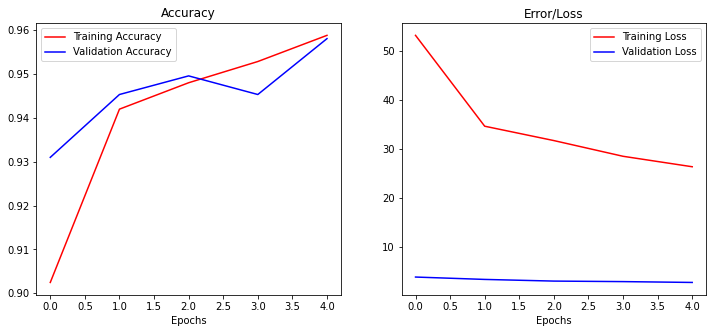

In [0]:
plot_loss_and_acc_curves(Epochs, training_accuracy, training_loss, validation_accuracy, validation_loss)

### Confusion Matrix, Accuracy and F1-Score

No of Training samples = 6200
Accuracy = 96.000000 %
Precision = 0.945776
Recall = 0.937500
F1_Score = 0.941620
Training Confusion Matrix


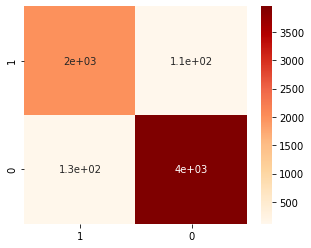

In [0]:
display_model_evaluation_parameters(model, trainloader, "Training")

No of Validation samples = 628
Accuracy = 95.541401 %
Precision = 0.946875
Recall = 0.923780
F1_Score = 0.935185
Validation Confusion Matrix


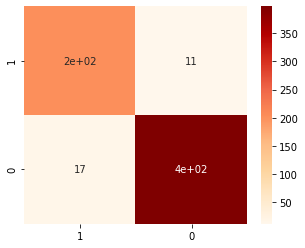

In [0]:
display_model_evaluation_parameters(model, validationloader, "Validation")

##Task-1 vgg16 with BCE Logit Loss Completed

#Task1- vgg16 with Focal Loss

In [0]:
# Load the pretrained model from pytorch
model = models.vgg16(pretrained=True)
print(model)
print('Output Layer of VGG16 : ', model.classifier[6].out_features) # 1000 

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
new_features = get_updated_features(model.classifier[0].in_features)
model.classifier = nn.Sequential(*new_features)
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
Learning_Rate = 0.001
random.seed(1)

def focal_loss(outputs, targets, gamma = 0.5):

    BATCH_SIZE = targets.size(0)
    outputs = torch.sigmoid(outputs)
    loss = 0
    for i in range(BATCH_SIZE):
      for j in range(NO_OF_CLASSES):
        ground_truth = targets[i][j]
        p_t = 0
        if ground_truth == 1:
          p_t = outputs[i][j]
        else:
          p_t = 1 - outputs[i][j]
        loss = - ((1 - p_t) ** gamma) * torch.log(p_t)
    loss = loss / BATCH_SIZE
    return loss

# Loss function and Optimizer
Epochs = 5
# criterion = nn.BCEWithLogitsLoss()
criterion = focal_loss
optimizer = optim.SGD(model.parameters(), lr=Learning_Rate, momentum=0.9)

from tqdm import tqdm

training_accuracy = []
training_loss = []
validation_accuracy = []
validation_loss = []
model.to(device)
model.train()
for epoch in range(Epochs):  # loop over the dataset multiple times
    train_correct_count = 0
    val_correct_count = 0
    running_train_loss = 0.0
    running_val_loss = 0.0
    total = 0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        BATCH_SIZE = labels.size(0)
        
        one_hot_labels = to_one_hot_encoded_labels(labels, BATCH_SIZE)
        inputs, one_hot_labels = inputs.to(device), one_hot_labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)               #----> forward pass
        loss = criterion(outputs, one_hot_labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        total += BATCH_SIZE
        running_train_loss += loss.item()
        outputs = classify_labels_wrt_probabilities(torch.sigmoid(model(inputs)), BATCH_SIZE)
        train_correct_count += ((outputs == one_hot_labels).sum().item()) / (NO_OF_CLASSES)

        print("Epoch = %d, accuracy = %f, error = %f" %(epoch, train_correct_count/total, running_train_loss))
    val_total = 0

    with torch.no_grad():
      for data in validationloader:  
          images, labels = data
          BATCH_SIZE = labels.size(0)
          one_hot_labels = to_one_hot_encoded_labels(labels, BATCH_SIZE)
          images, one_hot_labels = images.to(device), one_hot_labels.to(device)
          outputs = model(images)
          loss = criterion(outputs, one_hot_labels)   #----> compute loss
          val_total += BATCH_SIZE
          running_val_loss += loss.item()
          outputs = classify_labels_wrt_probabilities(torch.sigmoid(outputs), BATCH_SIZE)
          val_correct_count += ((outputs == one_hot_labels).sum().item()) / (NO_OF_CLASSES)

    validation_accuracy.append(val_correct_count/val_total)
    validation_loss.append(running_val_loss)
    training_loss.append(running_train_loss)
    training_accuracy.append(train_correct_count/total)
    print("Epoch = %d, accuracy = %f, error = %f" %(epoch, train_correct_count/total, running_train_loss))

print('Finished Training')
print(training_loss)
print(training_accuracy)





0it [00:00, ?it/s]



1it [00:01,  1.20s/it]

Epoch = 0, accuracy = 0.577778, error = 0.011639






2it [00:02,  1.18s/it]

Epoch = 0, accuracy = 0.555556, error = 0.027702






3it [00:03,  1.17s/it]

Epoch = 0, accuracy = 0.551852, error = 0.049311






4it [00:04,  1.17s/it]

Epoch = 0, accuracy = 0.569444, error = 0.068783






5it [00:05,  1.17s/it]

Epoch = 0, accuracy = 0.577778, error = 0.077647






6it [00:07,  1.17s/it]

Epoch = 0, accuracy = 0.581481, error = 0.093820






7it [00:08,  1.20s/it]

Epoch = 0, accuracy = 0.596825, error = 0.108508






8it [00:09,  1.18s/it]

Epoch = 0, accuracy = 0.602778, error = 0.115038






9it [00:10,  1.18s/it]

Epoch = 0, accuracy = 0.601235, error = 0.128851






10it [00:11,  1.17s/it]

Epoch = 0, accuracy = 0.603333, error = 0.146832






11it [00:12,  1.17s/it]

Epoch = 0, accuracy = 0.601010, error = 0.156422






12it [00:14,  1.16s/it]

Epoch = 0, accuracy = 0.606481, error = 0.164595






13it [00:15,  1.23s/it]

Epoch = 0, accuracy = 0.612821, error = 0.176575






14it [00:16,  1.21s/it]

Epoch = 0, accuracy = 0.611905, error = 0.186964






15it [00:17,  1.19s/it]

Epoch = 0, accuracy = 0.616296, error = 0.203273






16it [00:18,  1.18s/it]

Epoch = 0, accuracy = 0.616667, error = 0.214548






17it [00:20,  1.26s/it]

Epoch = 0, accuracy = 0.621569, error = 0.227797






18it [00:21,  1.23s/it]

Epoch = 0, accuracy = 0.627778, error = 0.242859






19it [00:22,  1.21s/it]

Epoch = 0, accuracy = 0.628070, error = 0.255257






20it [00:23,  1.23s/it]

Epoch = 0, accuracy = 0.625556, error = 0.270696






21it [00:25,  1.21s/it]

Epoch = 0, accuracy = 0.624339, error = 0.294017






22it [00:26,  1.19s/it]

Epoch = 0, accuracy = 0.623737, error = 0.301747






23it [00:27,  1.18s/it]

Epoch = 0, accuracy = 0.625121, error = 0.315992






24it [00:28,  1.17s/it]

Epoch = 0, accuracy = 0.626852, error = 0.330603






25it [00:29,  1.17s/it]

Epoch = 0, accuracy = 0.630667, error = 0.337064






26it [00:31,  1.21s/it]

Epoch = 0, accuracy = 0.633761, error = 0.362921






27it [00:32,  1.19s/it]

Epoch = 0, accuracy = 0.639918, error = 0.386605






28it [00:33,  1.18s/it]

Epoch = 0, accuracy = 0.638889, error = 0.412277






29it [00:34,  1.17s/it]

Epoch = 0, accuracy = 0.637931, error = 0.421946






30it [00:35,  1.17s/it]

Epoch = 0, accuracy = 0.640741, error = 0.430963






31it [00:36,  1.16s/it]

Epoch = 0, accuracy = 0.641577, error = 0.435469






32it [00:37,  1.15s/it]

Epoch = 0, accuracy = 0.639931, error = 0.451216






33it [00:39,  1.15s/it]

Epoch = 0, accuracy = 0.639731, error = 0.457675






34it [00:40,  1.16s/it]

Epoch = 0, accuracy = 0.638235, error = 0.483102






35it [00:41,  1.15s/it]

Epoch = 0, accuracy = 0.638413, error = 0.489283






36it [00:42,  1.17s/it]

Epoch = 0, accuracy = 0.640432, error = 0.509952






37it [00:43,  1.16s/it]

Epoch = 0, accuracy = 0.640841, error = 0.515954






38it [00:45,  1.25s/it]

Epoch = 0, accuracy = 0.640936, error = 0.522208






39it [00:46,  1.27s/it]

Epoch = 0, accuracy = 0.640456, error = 0.550682






40it [00:47,  1.26s/it]

Epoch = 0, accuracy = 0.641667, error = 0.560418






41it [00:48,  1.23s/it]

Epoch = 0, accuracy = 0.640650, error = 0.583451






42it [00:50,  1.20s/it]

Epoch = 0, accuracy = 0.641799, error = 0.588283






43it [00:51,  1.21s/it]

Epoch = 0, accuracy = 0.644186, error = 0.623267






44it [00:52,  1.19s/it]

Epoch = 0, accuracy = 0.645455, error = 0.630359






45it [00:53,  1.18s/it]

Epoch = 0, accuracy = 0.646173, error = 0.660039






46it [00:54,  1.21s/it]

Epoch = 0, accuracy = 0.645652, error = 0.681170






47it [00:56,  1.21s/it]

Epoch = 0, accuracy = 0.644208, error = 0.688419






48it [00:57,  1.19s/it]

Epoch = 0, accuracy = 0.644213, error = 0.699799






49it [00:58,  1.18s/it]

Epoch = 0, accuracy = 0.644671, error = 0.708906






50it [00:59,  1.16s/it]

Epoch = 0, accuracy = 0.644444, error = 0.719964






51it [01:00,  1.18s/it]

Epoch = 0, accuracy = 0.645752, error = 0.734723






52it [01:01,  1.19s/it]

Epoch = 0, accuracy = 0.645726, error = 0.749417






53it [01:03,  1.27s/it]

Epoch = 0, accuracy = 0.643816, error = 0.756961






54it [01:04,  1.23s/it]

Epoch = 0, accuracy = 0.642593, error = 0.777144






55it [01:05,  1.21s/it]

Epoch = 0, accuracy = 0.641818, error = 0.783823






56it [01:06,  1.19s/it]

Epoch = 0, accuracy = 0.641865, error = 0.810348






57it [01:07,  1.17s/it]

Epoch = 0, accuracy = 0.641520, error = 0.827093






58it [01:09,  1.17s/it]

Epoch = 0, accuracy = 0.642146, error = 0.832632






59it [01:10,  1.16s/it]

Epoch = 0, accuracy = 0.642185, error = 0.853076






60it [01:11,  1.21s/it]

Epoch = 0, accuracy = 0.641296, error = 0.860835






61it [01:12,  1.19s/it]

Epoch = 0, accuracy = 0.640073, error = 0.881826






62it [01:13,  1.17s/it]

Epoch = 0, accuracy = 0.639785, error = 0.890746






63it [01:15,  1.22s/it]

Epoch = 0, accuracy = 0.638977, error = 0.910398






64it [01:16,  1.20s/it]

Epoch = 0, accuracy = 0.640104, error = 0.920474






65it [01:17,  1.19s/it]

Epoch = 0, accuracy = 0.640342, error = 0.926320






66it [01:18,  1.18s/it]

Epoch = 0, accuracy = 0.640909, error = 0.940837






67it [01:20,  1.28s/it]

Epoch = 0, accuracy = 0.640299, error = 0.966797






68it [01:21,  1.24s/it]

Epoch = 0, accuracy = 0.640850, error = 0.982694






69it [01:22,  1.21s/it]

Epoch = 0, accuracy = 0.640902, error = 0.996369






70it [01:23,  1.19s/it]

Epoch = 0, accuracy = 0.641111, error = 1.012741






71it [01:24,  1.18s/it]

Epoch = 0, accuracy = 0.641158, error = 1.020212






72it [01:25,  1.19s/it]

Epoch = 0, accuracy = 0.640741, error = 1.026732






73it [01:27,  1.17s/it]

Epoch = 0, accuracy = 0.640639, error = 1.040822






74it [01:28,  1.16s/it]

Epoch = 0, accuracy = 0.641892, error = 1.052378






75it [01:29,  1.15s/it]

Epoch = 0, accuracy = 0.641630, error = 1.067127






76it [01:30,  1.15s/it]

Epoch = 0, accuracy = 0.642982, error = 1.073993






77it [01:31,  1.19s/it]

Epoch = 0, accuracy = 0.643290, error = 1.098357






78it [01:32,  1.17s/it]

Epoch = 0, accuracy = 0.643447, error = 1.107992






79it [01:34,  1.18s/it]

Epoch = 0, accuracy = 0.644866, error = 1.118854






80it [01:35,  1.17s/it]

Epoch = 0, accuracy = 0.644306, error = 1.141752






81it [01:36,  1.16s/it]

Epoch = 0, accuracy = 0.645130, error = 1.159494






82it [01:37,  1.27s/it]

Epoch = 0, accuracy = 0.645664, error = 1.174166






83it [01:39,  1.23s/it]

Epoch = 0, accuracy = 0.645248, error = 1.183457






84it [01:40,  1.22s/it]

Epoch = 0, accuracy = 0.645503, error = 1.196913






85it [01:41,  1.19s/it]

Epoch = 0, accuracy = 0.645621, error = 1.209417






86it [01:42,  1.21s/it]

Epoch = 0, accuracy = 0.645736, error = 1.225659






87it [01:43,  1.19s/it]

Epoch = 0, accuracy = 0.645594, error = 1.250857






88it [01:44,  1.18s/it]

Epoch = 0, accuracy = 0.646086, error = 1.261313






89it [01:46,  1.18s/it]

Epoch = 0, accuracy = 0.646067, error = 1.270603






90it [01:47,  1.17s/it]

Epoch = 0, accuracy = 0.646790, error = 1.282117






91it [01:48,  1.17s/it]

Epoch = 0, accuracy = 0.646886, error = 1.296931






92it [01:49,  1.16s/it]

Epoch = 0, accuracy = 0.647705, error = 1.318554






93it [01:50,  1.16s/it]

Epoch = 0, accuracy = 0.647431, error = 1.329606






94it [01:51,  1.17s/it]

Epoch = 0, accuracy = 0.647754, error = 1.343007






95it [01:53,  1.17s/it]

Epoch = 0, accuracy = 0.648187, error = 1.349302






96it [01:54,  1.18s/it]

Epoch = 0, accuracy = 0.648148, error = 1.357896






97it [01:55,  1.17s/it]

Epoch = 0, accuracy = 0.648339, error = 1.374122






98it [01:56,  1.16s/it]

Epoch = 0, accuracy = 0.648413, error = 1.378921






99it [01:57,  1.16s/it]

Epoch = 0, accuracy = 0.647363, error = 1.400923






100it [01:58,  1.15s/it]

Epoch = 0, accuracy = 0.647556, error = 1.406673






101it [01:59,  1.15s/it]

Epoch = 0, accuracy = 0.647855, error = 1.416154






102it [02:01,  1.14s/it]

Epoch = 0, accuracy = 0.648148, error = 1.429389






103it [02:02,  1.14s/it]

Epoch = 0, accuracy = 0.648328, error = 1.433179






104it [02:03,  1.14s/it]

Epoch = 0, accuracy = 0.648077, error = 1.443906






105it [02:04,  1.15s/it]

Epoch = 0, accuracy = 0.648571, error = 1.457956






106it [02:05,  1.14s/it]

Epoch = 0, accuracy = 0.649057, error = 1.481828






107it [02:06,  1.14s/it]

Epoch = 0, accuracy = 0.649325, error = 1.486827






108it [02:08,  1.24s/it]

Epoch = 0, accuracy = 0.650206, error = 1.491690






109it [02:09,  1.22s/it]

Epoch = 0, accuracy = 0.650051, error = 1.496391






110it [02:10,  1.19s/it]

Epoch = 0, accuracy = 0.649798, error = 1.536452






111it [02:11,  1.18s/it]

Epoch = 0, accuracy = 0.649349, error = 1.549104






112it [02:12,  1.17s/it]

Epoch = 0, accuracy = 0.650000, error = 1.552905






113it [02:14,  1.16s/it]

Epoch = 0, accuracy = 0.650344, error = 1.560029






114it [02:15,  1.16s/it]

Epoch = 0, accuracy = 0.650390, error = 1.569307






115it [02:16,  1.15s/it]

Epoch = 0, accuracy = 0.650821, error = 1.577014






116it [02:17,  1.15s/it]

Epoch = 0, accuracy = 0.650479, error = 1.585954






117it [02:18,  1.22s/it]

Epoch = 0, accuracy = 0.650332, error = 1.591291






118it [02:19,  1.20s/it]

Epoch = 0, accuracy = 0.650188, error = 1.598962






119it [02:21,  1.18s/it]

Epoch = 0, accuracy = 0.650980, error = 1.605154






120it [02:22,  1.17s/it]

Epoch = 0, accuracy = 0.650556, error = 1.619146






121it [02:23,  1.17s/it]

Epoch = 0, accuracy = 0.650138, error = 1.624129






122it [02:24,  1.15s/it]

Epoch = 0, accuracy = 0.650729, error = 1.630234






123it [02:25,  1.15s/it]

Epoch = 0, accuracy = 0.651220, error = 1.632692






124it [02:26,  1.16s/it]

Epoch = 0, accuracy = 0.651434, error = 1.637450






125it [02:27,  1.15s/it]

Epoch = 0, accuracy = 0.651822, error = 1.641387






126it [02:29,  1.15s/it]

Epoch = 0, accuracy = 0.651852, error = 1.649398






127it [02:30,  1.14s/it]

Epoch = 0, accuracy = 0.651794, error = 1.660511






128it [02:31,  1.15s/it]

Epoch = 0, accuracy = 0.651389, error = 1.689727






129it [02:32,  1.14s/it]

Epoch = 0, accuracy = 0.651421, error = 1.699312






130it [02:33,  1.14s/it]

Epoch = 0, accuracy = 0.651197, error = 1.729573






131it [02:35,  1.27s/it]

Epoch = 0, accuracy = 0.650551, error = 1.743220






132it [02:36,  1.23s/it]

Epoch = 0, accuracy = 0.650168, error = 1.744722






133it [02:37,  1.25s/it]

Epoch = 0, accuracy = 0.649875, error = 1.785743






134it [02:38,  1.21s/it]

Epoch = 0, accuracy = 0.650249, error = 1.787247






135it [02:39,  1.19s/it]

Epoch = 0, accuracy = 0.649959, error = 1.796690






136it [02:41,  1.20s/it]

Epoch = 0, accuracy = 0.649918, error = 1.811774






137it [02:42,  1.23s/it]

Epoch = 0, accuracy = 0.649797, error = 1.822775






138it [02:43,  1.20s/it]

Epoch = 0, accuracy = 0.650161, error = 1.834973






139it [02:44,  1.20s/it]

Epoch = 0, accuracy = 0.650440, error = 1.839633






140it [02:45,  1.18s/it]

Epoch = 0, accuracy = 0.650317, error = 1.858143






141it [02:47,  1.17s/it]

Epoch = 0, accuracy = 0.650433, error = 1.860460






142it [02:48,  1.16s/it]

Epoch = 0, accuracy = 0.650078, error = 1.880652






143it [02:49,  1.18s/it]

Epoch = 0, accuracy = 0.650427, error = 1.891372






144it [02:50,  1.17s/it]

Epoch = 0, accuracy = 0.651157, error = 1.893346






145it [02:51,  1.16s/it]

Epoch = 0, accuracy = 0.651341, error = 1.903091






146it [02:52,  1.16s/it]

Epoch = 0, accuracy = 0.651598, error = 1.921066






147it [02:54,  1.19s/it]

Epoch = 0, accuracy = 0.651852, error = 1.931515






148it [02:55,  1.18s/it]

Epoch = 0, accuracy = 0.652327, error = 1.966145






149it [02:56,  1.17s/it]

Epoch = 0, accuracy = 0.652274, error = 1.973783






150it [02:57,  1.17s/it]

Epoch = 0, accuracy = 0.652296, error = 1.984079






151it [02:58,  1.16s/it]

Epoch = 0, accuracy = 0.652097, error = 1.994473






152it [03:00,  1.21s/it]

Epoch = 0, accuracy = 0.652339, error = 2.007323






153it [03:01,  1.19s/it]

Epoch = 0, accuracy = 0.652578, error = 2.022544






154it [03:02,  1.18s/it]

Epoch = 0, accuracy = 0.652814, error = 2.033468






155it [03:04,  1.35s/it]

Epoch = 0, accuracy = 0.652760, error = 2.039702






156it [03:05,  1.34s/it]

Epoch = 0, accuracy = 0.652564, error = 2.045583






157it [03:06,  1.29s/it]

Epoch = 0, accuracy = 0.652371, error = 2.054603






158it [03:07,  1.28s/it]

Epoch = 0, accuracy = 0.652743, error = 2.060981






159it [03:09,  1.24s/it]

Epoch = 0, accuracy = 0.653180, error = 2.070029






160it [03:10,  1.25s/it]

Epoch = 0, accuracy = 0.653611, error = 2.079979






161it [03:11,  1.22s/it]

Epoch = 0, accuracy = 0.653968, error = 2.095967






162it [03:12,  1.20s/it]

Epoch = 0, accuracy = 0.654252, error = 2.112363






163it [03:13,  1.19s/it]

Epoch = 0, accuracy = 0.654601, error = 2.119831






164it [03:14,  1.18s/it]

Epoch = 0, accuracy = 0.654336, error = 2.128707






165it [03:16,  1.17s/it]

Epoch = 0, accuracy = 0.654815, error = 2.138972






166it [03:17,  1.19s/it]

Epoch = 0, accuracy = 0.655087, error = 2.156069






167it [03:18,  1.18s/it]

Epoch = 0, accuracy = 0.655356, error = 2.161794






168it [03:19,  1.17s/it]

Epoch = 0, accuracy = 0.655489, error = 2.185758






169it [03:20,  1.17s/it]

Epoch = 0, accuracy = 0.655819, error = 2.201766






170it [03:22,  1.18s/it]

Epoch = 0, accuracy = 0.656275, error = 2.207672






171it [03:23,  1.17s/it]

Epoch = 0, accuracy = 0.656075, error = 2.212571






172it [03:24,  1.16s/it]

Epoch = 0, accuracy = 0.656266, error = 2.214943






173it [03:25,  1.15s/it]

Epoch = 0, accuracy = 0.656005, error = 2.216995






174it [03:26,  1.19s/it]

Epoch = 0, accuracy = 0.656003, error = 2.226245






175it [03:27,  1.18s/it]

Epoch = 0, accuracy = 0.655873, error = 2.229434






176it [03:29,  1.18s/it]

Epoch = 0, accuracy = 0.656124, error = 2.230891






177it [03:30,  1.17s/it]

Epoch = 0, accuracy = 0.655995, error = 2.236945






178it [03:31,  1.16s/it]

Epoch = 0, accuracy = 0.655930, error = 2.239513






179it [03:32,  1.15s/it]

Epoch = 0, accuracy = 0.656425, error = 2.245578






180it [03:33,  1.19s/it]

Epoch = 0, accuracy = 0.656790, error = 2.249297






181it [03:34,  1.17s/it]

Epoch = 0, accuracy = 0.656845, error = 2.259211






182it [03:36,  1.17s/it]

Epoch = 0, accuracy = 0.656838, error = 2.265963






183it [03:37,  1.16s/it]

Epoch = 0, accuracy = 0.657073, error = 2.267060






184it [03:38,  1.16s/it]

Epoch = 0, accuracy = 0.657065, error = 2.282459






185it [03:39,  1.17s/it]

Epoch = 0, accuracy = 0.656997, error = 2.283313






186it [03:40,  1.18s/it]

Epoch = 0, accuracy = 0.656989, error = 2.292803






187it [03:41,  1.17s/it]

Epoch = 0, accuracy = 0.657160, error = 2.301677






188it [03:43,  1.17s/it]

Epoch = 0, accuracy = 0.657033, error = 2.318489






189it [03:44,  1.17s/it]

Epoch = 0, accuracy = 0.657084, error = 2.320377






190it [03:45,  1.16s/it]

Epoch = 0, accuracy = 0.657135, error = 2.324047






191it [03:46,  1.16s/it]

Epoch = 0, accuracy = 0.657301, error = 2.356075






192it [03:47,  1.15s/it]

Epoch = 0, accuracy = 0.657292, error = 2.356839






193it [03:48,  1.15s/it]

Epoch = 0, accuracy = 0.657398, error = 2.359986






194it [03:50,  1.23s/it]

Epoch = 0, accuracy = 0.657159, error = 2.415500






195it [03:51,  1.21s/it]

Epoch = 0, accuracy = 0.657094, error = 2.420562






196it [03:52,  1.20s/it]

Epoch = 0, accuracy = 0.657200, error = 2.432824






197it [03:53,  1.22s/it]

Epoch = 0, accuracy = 0.657586, error = 2.439583






198it [03:54,  1.20s/it]

Epoch = 0, accuracy = 0.657407, error = 2.467369






199it [03:56,  1.27s/it]

Epoch = 0, accuracy = 0.657733, error = 2.475952






200it [03:57,  1.25s/it]

Epoch = 0, accuracy = 0.657889, error = 2.478173






201it [03:58,  1.28s/it]

Epoch = 0, accuracy = 0.657767, error = 2.520849






202it [04:00,  1.23s/it]

Epoch = 0, accuracy = 0.658196, error = 2.522761






203it [04:01,  1.26s/it]

Epoch = 0, accuracy = 0.658019, error = 2.527564






204it [04:02,  1.25s/it]

Epoch = 0, accuracy = 0.658170, error = 2.529785






205it [04:03,  1.23s/it]

Epoch = 0, accuracy = 0.657940, error = 2.559306






206it [04:04,  1.21s/it]

Epoch = 0, accuracy = 0.658145, error = 2.560738






207it [04:06,  1.19s/it]

Epoch = 0, accuracy = 0.658118, error = 2.562399







0it [00:00, ?it/s]

Epoch = 0, accuracy = 0.658118, error = 2.562399






1it [00:01,  1.16s/it]

Epoch = 1, accuracy = 0.677778, error = 0.018161






2it [00:02,  1.17s/it]

Epoch = 1, accuracy = 0.655556, error = 0.020782






3it [00:03,  1.16s/it]

Epoch = 1, accuracy = 0.666667, error = 0.023808






4it [00:04,  1.16s/it]

Epoch = 1, accuracy = 0.680556, error = 0.026628






5it [00:05,  1.18s/it]

Epoch = 1, accuracy = 0.664444, error = 0.073689






6it [00:07,  1.18s/it]

Epoch = 1, accuracy = 0.666667, error = 0.078705






7it [00:08,  1.17s/it]

Epoch = 1, accuracy = 0.669841, error = 0.098261






8it [00:09,  1.18s/it]

Epoch = 1, accuracy = 0.677778, error = 0.120082






9it [00:10,  1.20s/it]

Epoch = 1, accuracy = 0.677778, error = 0.123315






10it [00:11,  1.24s/it]

Epoch = 1, accuracy = 0.686667, error = 0.175147






11it [00:13,  1.21s/it]

Epoch = 1, accuracy = 0.688889, error = 0.176300






12it [00:14,  1.20s/it]

Epoch = 1, accuracy = 0.686111, error = 0.181869






13it [00:15,  1.20s/it]

Epoch = 1, accuracy = 0.687179, error = 0.187263






14it [00:16,  1.22s/it]

Epoch = 1, accuracy = 0.688095, error = 0.193895






15it [00:17,  1.20s/it]

Epoch = 1, accuracy = 0.689630, error = 0.204337






16it [00:19,  1.18s/it]

Epoch = 1, accuracy = 0.692361, error = 0.209349






17it [00:20,  1.20s/it]

Epoch = 1, accuracy = 0.691503, error = 0.213469






18it [00:21,  1.18s/it]

Epoch = 1, accuracy = 0.691975, error = 0.234775






19it [00:22,  1.18s/it]

Epoch = 1, accuracy = 0.688889, error = 0.240735






20it [00:23,  1.17s/it]

Epoch = 1, accuracy = 0.688889, error = 0.255384






21it [00:24,  1.16s/it]

Epoch = 1, accuracy = 0.690476, error = 0.271771






22it [00:26,  1.18s/it]

Epoch = 1, accuracy = 0.688889, error = 0.276162






23it [00:27,  1.16s/it]

Epoch = 1, accuracy = 0.685024, error = 0.278864






24it [00:28,  1.15s/it]

Epoch = 1, accuracy = 0.682870, error = 0.288136






25it [00:29,  1.15s/it]

Epoch = 1, accuracy = 0.684000, error = 0.303292






26it [00:31,  1.26s/it]

Epoch = 1, accuracy = 0.684188, error = 0.304073






27it [00:32,  1.24s/it]

Epoch = 1, accuracy = 0.686008, error = 0.307733






28it [00:33,  1.21s/it]

Epoch = 1, accuracy = 0.684921, error = 0.313173






29it [00:34,  1.19s/it]

Epoch = 1, accuracy = 0.683142, error = 0.315272






30it [00:35,  1.18s/it]

Epoch = 1, accuracy = 0.684444, error = 0.317513






31it [00:36,  1.17s/it]

Epoch = 1, accuracy = 0.683871, error = 0.322154






32it [00:37,  1.17s/it]

Epoch = 1, accuracy = 0.683681, error = 0.323178






33it [00:39,  1.16s/it]

Epoch = 1, accuracy = 0.683838, error = 0.323539






34it [00:40,  1.16s/it]

Epoch = 1, accuracy = 0.685621, error = 0.328267






35it [00:41,  1.15s/it]

Epoch = 1, accuracy = 0.682222, error = 0.329344






36it [00:42,  1.15s/it]

Epoch = 1, accuracy = 0.683951, error = 0.342662






37it [00:43,  1.19s/it]

Epoch = 1, accuracy = 0.683784, error = 0.343353






38it [00:45,  1.18s/it]

Epoch = 1, accuracy = 0.683626, error = 0.344104






39it [00:46,  1.16s/it]

Epoch = 1, accuracy = 0.682906, error = 0.344919






40it [00:47,  1.17s/it]

Epoch = 1, accuracy = 0.680833, error = 0.346091






41it [00:48,  1.16s/it]

Epoch = 1, accuracy = 0.679133, error = 0.346324






42it [00:49,  1.17s/it]

Epoch = 1, accuracy = 0.679630, error = 0.361182






43it [00:50,  1.17s/it]

Epoch = 1, accuracy = 0.677519, error = 0.361853






44it [00:51,  1.17s/it]

Epoch = 1, accuracy = 0.676515, error = 0.364963






45it [00:53,  1.18s/it]

Epoch = 1, accuracy = 0.676790, error = 0.404698






46it [00:54,  1.17s/it]

Epoch = 1, accuracy = 0.677536, error = 0.406688






47it [00:55,  1.16s/it]

Epoch = 1, accuracy = 0.675177, error = 0.407307






48it [00:56,  1.16s/it]

Epoch = 1, accuracy = 0.675000, error = 0.407580






49it [00:57,  1.15s/it]

Epoch = 1, accuracy = 0.675057, error = 0.435336






50it [00:58,  1.15s/it]

Epoch = 1, accuracy = 0.675556, error = 0.435788






51it [01:00,  1.19s/it]

Epoch = 1, accuracy = 0.676035, error = 0.437283






52it [01:01,  1.18s/it]

Epoch = 1, accuracy = 0.674786, error = 0.437433






53it [01:02,  1.17s/it]

Epoch = 1, accuracy = 0.675262, error = 0.437585






54it [01:03,  1.16s/it]

Epoch = 1, accuracy = 0.675309, error = 0.438779






55it [01:04,  1.16s/it]

Epoch = 1, accuracy = 0.674343, error = 0.439607






56it [01:05,  1.15s/it]

Epoch = 1, accuracy = 0.674802, error = 0.473247






57it [01:07,  1.22s/it]

Epoch = 1, accuracy = 0.675049, error = 0.474651






58it [01:08,  1.20s/it]

Epoch = 1, accuracy = 0.675287, error = 0.475800






59it [01:09,  1.22s/it]

Epoch = 1, accuracy = 0.676083, error = 0.477525






60it [01:10,  1.21s/it]

Epoch = 1, accuracy = 0.676296, error = 0.494165






61it [01:12,  1.19s/it]

Epoch = 1, accuracy = 0.676138, error = 0.499007






62it [01:13,  1.20s/it]

Epoch = 1, accuracy = 0.675448, error = 0.499860






63it [01:14,  1.23s/it]

Epoch = 1, accuracy = 0.675132, error = 0.500391






64it [01:15,  1.21s/it]

Epoch = 1, accuracy = 0.674306, error = 0.500933






65it [01:16,  1.19s/it]

Epoch = 1, accuracy = 0.675214, error = 0.502862






66it [01:18,  1.18s/it]

Epoch = 1, accuracy = 0.674579, error = 0.510593






67it [01:19,  1.16s/it]

Epoch = 1, accuracy = 0.674959, error = 0.511929






68it [01:20,  1.15s/it]

Epoch = 1, accuracy = 0.674673, error = 0.512886






69it [01:21,  1.15s/it]

Epoch = 1, accuracy = 0.674879, error = 0.513369






70it [01:22,  1.16s/it]

Epoch = 1, accuracy = 0.674444, error = 0.513875






71it [01:23,  1.16s/it]

Epoch = 1, accuracy = 0.673865, error = 0.521510






72it [01:24,  1.15s/it]

Epoch = 1, accuracy = 0.673457, error = 0.521638






73it [01:26,  1.15s/it]

Epoch = 1, accuracy = 0.673212, error = 0.524759






74it [01:27,  1.15s/it]

Epoch = 1, accuracy = 0.674324, error = 0.524896






75it [01:28,  1.22s/it]

Epoch = 1, accuracy = 0.674667, error = 0.579042






76it [01:29,  1.19s/it]

Epoch = 1, accuracy = 0.674123, error = 0.579330






77it [01:31,  1.31s/it]

Epoch = 1, accuracy = 0.673882, error = 0.579555






78it [01:32,  1.26s/it]

Epoch = 1, accuracy = 0.673219, error = 0.580212






79it [01:33,  1.26s/it]

Epoch = 1, accuracy = 0.672574, error = 0.581794






80it [01:34,  1.23s/it]

Epoch = 1, accuracy = 0.672778, error = 0.581962






81it [01:35,  1.20s/it]

Epoch = 1, accuracy = 0.672702, error = 0.582249






82it [01:37,  1.19s/it]

Epoch = 1, accuracy = 0.673171, error = 0.583285






83it [01:38,  1.28s/it]

Epoch = 1, accuracy = 0.672691, error = 0.583996






84it [01:40,  1.37s/it]

Epoch = 1, accuracy = 0.673016, error = 0.603255






85it [01:41,  1.30s/it]

Epoch = 1, accuracy = 0.672680, error = 0.611535






86it [01:42,  1.33s/it]

Epoch = 1, accuracy = 0.673385, error = 0.611849






87it [01:43,  1.28s/it]

Epoch = 1, accuracy = 0.673052, error = 0.626128






88it [01:45,  1.24s/it]

Epoch = 1, accuracy = 0.673485, error = 0.635323






89it [01:46,  1.21s/it]

Epoch = 1, accuracy = 0.673408, error = 0.638622






90it [01:47,  1.30s/it]

Epoch = 1, accuracy = 0.673457, error = 0.641823






91it [01:48,  1.25s/it]

Epoch = 1, accuracy = 0.673138, error = 0.671728






92it [01:49,  1.22s/it]

Epoch = 1, accuracy = 0.672343, error = 0.672927






93it [01:51,  1.27s/it]

Epoch = 1, accuracy = 0.671565, error = 0.678194






94it [01:52,  1.24s/it]

Epoch = 1, accuracy = 0.671868, error = 0.679983






95it [01:53,  1.24s/it]

Epoch = 1, accuracy = 0.671696, error = 0.688492






96it [01:54,  1.21s/it]

Epoch = 1, accuracy = 0.670833, error = 0.690647






97it [01:56,  1.19s/it]

Epoch = 1, accuracy = 0.671134, error = 0.690835






98it [01:57,  1.18s/it]

Epoch = 1, accuracy = 0.670748, error = 0.691287






99it [01:58,  1.16s/it]

Epoch = 1, accuracy = 0.670034, error = 0.702017






100it [01:59,  1.16s/it]

Epoch = 1, accuracy = 0.669778, error = 0.706379






101it [02:00,  1.15s/it]

Epoch = 1, accuracy = 0.670187, error = 0.709210






102it [02:01,  1.15s/it]

Epoch = 1, accuracy = 0.669935, error = 0.709924






103it [02:02,  1.15s/it]

Epoch = 1, accuracy = 0.670119, error = 0.747378






104it [02:04,  1.15s/it]

Epoch = 1, accuracy = 0.670513, error = 0.751167






105it [02:05,  1.15s/it]

Epoch = 1, accuracy = 0.670053, error = 0.751865






106it [02:06,  1.14s/it]

Epoch = 1, accuracy = 0.670545, error = 0.756512






107it [02:07,  1.14s/it]

Epoch = 1, accuracy = 0.670924, error = 0.761850






108it [02:08,  1.14s/it]

Epoch = 1, accuracy = 0.670679, error = 0.763124






109it [02:09,  1.14s/it]

Epoch = 1, accuracy = 0.670642, error = 0.774913






110it [02:10,  1.16s/it]

Epoch = 1, accuracy = 0.671313, error = 0.788277






111it [02:12,  1.20s/it]

Epoch = 1, accuracy = 0.671071, error = 0.790529






112it [02:13,  1.18s/it]

Epoch = 1, accuracy = 0.670337, error = 0.794729






113it [02:14,  1.17s/it]

Epoch = 1, accuracy = 0.670403, error = 0.814756






114it [02:15,  1.17s/it]

Epoch = 1, accuracy = 0.670175, error = 0.839992






115it [02:16,  1.17s/it]

Epoch = 1, accuracy = 0.670145, error = 0.845428






116it [02:18,  1.16s/it]

Epoch = 1, accuracy = 0.670594, error = 0.856679






117it [02:19,  1.17s/it]

Epoch = 1, accuracy = 0.670275, error = 0.858174






118it [02:20,  1.16s/it]

Epoch = 1, accuracy = 0.670433, error = 0.859931






119it [02:21,  1.16s/it]

Epoch = 1, accuracy = 0.670401, error = 0.863566






120it [02:22,  1.19s/it]

Epoch = 1, accuracy = 0.670648, error = 0.863788






121it [02:23,  1.18s/it]

Epoch = 1, accuracy = 0.669972, error = 0.864501






122it [02:25,  1.16s/it]

Epoch = 1, accuracy = 0.669854, error = 0.873039






123it [02:26,  1.15s/it]

Epoch = 1, accuracy = 0.669467, error = 0.876413






124it [02:27,  1.18s/it]

Epoch = 1, accuracy = 0.668817, error = 0.884505






125it [02:28,  1.18s/it]

Epoch = 1, accuracy = 0.669067, error = 0.887100






126it [02:29,  1.16s/it]

Epoch = 1, accuracy = 0.668254, error = 0.906391






127it [02:30,  1.18s/it]

Epoch = 1, accuracy = 0.667804, error = 0.927256






128it [02:32,  1.17s/it]

Epoch = 1, accuracy = 0.666927, error = 0.928765






129it [02:33,  1.16s/it]

Epoch = 1, accuracy = 0.667097, error = 0.934659






130it [02:34,  1.15s/it]

Epoch = 1, accuracy = 0.667094, error = 0.937630






131it [02:35,  1.15s/it]

Epoch = 1, accuracy = 0.667345, error = 0.943240






132it [02:36,  1.17s/it]

Epoch = 1, accuracy = 0.667424, error = 0.943982






133it [02:37,  1.17s/it]

Epoch = 1, accuracy = 0.667502, error = 0.946526






134it [02:39,  1.33s/it]

Epoch = 1, accuracy = 0.667330, error = 0.953224






135it [02:40,  1.27s/it]

Epoch = 1, accuracy = 0.666502, error = 0.962099






136it [02:41,  1.23s/it]

Epoch = 1, accuracy = 0.666667, error = 0.984486






137it [02:43,  1.21s/it]

Epoch = 1, accuracy = 0.666829, error = 0.986682






138it [02:44,  1.21s/it]

Epoch = 1, accuracy = 0.666667, error = 0.988535






139it [02:45,  1.19s/it]

Epoch = 1, accuracy = 0.667226, error = 0.988847






140it [02:46,  1.19s/it]

Epoch = 1, accuracy = 0.667063, error = 0.989377






141it [02:47,  1.18s/it]

Epoch = 1, accuracy = 0.666509, error = 0.992263






142it [02:48,  1.17s/it]

Epoch = 1, accuracy = 0.666823, error = 1.000762






143it [02:49,  1.16s/it]

Epoch = 1, accuracy = 0.667133, error = 1.004990






144it [02:51,  1.17s/it]

Epoch = 1, accuracy = 0.667438, error = 1.009298






145it [02:52,  1.16s/it]

Epoch = 1, accuracy = 0.667586, error = 1.012672






146it [02:53,  1.16s/it]

Epoch = 1, accuracy = 0.668113, error = 1.016149






147it [02:54,  1.21s/it]

Epoch = 1, accuracy = 0.667800, error = 1.016330






148it [02:55,  1.19s/it]

Epoch = 1, accuracy = 0.668018, error = 1.017167






149it [02:57,  1.19s/it]

Epoch = 1, accuracy = 0.667934, error = 1.019726






150it [02:58,  1.22s/it]

Epoch = 1, accuracy = 0.667778, error = 1.028778






151it [02:59,  1.24s/it]

Epoch = 1, accuracy = 0.667770, error = 1.029656






152it [03:00,  1.21s/it]

Epoch = 1, accuracy = 0.667544, error = 1.095643






153it [03:01,  1.19s/it]

Epoch = 1, accuracy = 0.667030, error = 1.095930






154it [03:03,  1.17s/it]

Epoch = 1, accuracy = 0.667027, error = 1.098093






155it [03:04,  1.19s/it]

Epoch = 1, accuracy = 0.666810, error = 1.098375






156it [03:05,  1.25s/it]

Epoch = 1, accuracy = 0.666524, error = 1.101571






157it [03:06,  1.22s/it]

Epoch = 1, accuracy = 0.666596, error = 1.102318






158it [03:08,  1.23s/it]

Epoch = 1, accuracy = 0.666526, error = 1.124142






159it [03:09,  1.20s/it]

Epoch = 1, accuracy = 0.667016, error = 1.125036






160it [03:10,  1.18s/it]

Epoch = 1, accuracy = 0.667083, error = 1.126184






161it [03:11,  1.16s/it]

Epoch = 1, accuracy = 0.667288, error = 1.132626






162it [03:12,  1.15s/it]

Epoch = 1, accuracy = 0.667215, error = 1.133171






163it [03:13,  1.16s/it]

Epoch = 1, accuracy = 0.666462, error = 1.133473






164it [03:15,  1.18s/it]

Epoch = 1, accuracy = 0.666870, error = 1.146456






165it [03:16,  1.16s/it]

Epoch = 1, accuracy = 0.666801, error = 1.146489






166it [03:17,  1.16s/it]

Epoch = 1, accuracy = 0.666867, error = 1.156102






167it [03:18,  1.17s/it]

Epoch = 1, accuracy = 0.666800, error = 1.192489






168it [03:19,  1.16s/it]

Epoch = 1, accuracy = 0.667196, error = 1.194977






169it [03:20,  1.16s/it]

Epoch = 1, accuracy = 0.667258, error = 1.195317






170it [03:21,  1.15s/it]

Epoch = 1, accuracy = 0.666928, error = 1.195427






171it [03:23,  1.15s/it]

Epoch = 1, accuracy = 0.667122, error = 1.199696






172it [03:24,  1.17s/it]

Epoch = 1, accuracy = 0.666925, error = 1.199778






173it [03:25,  1.17s/it]

Epoch = 1, accuracy = 0.666602, error = 1.200456






174it [03:26,  1.16s/it]

Epoch = 1, accuracy = 0.666731, error = 1.200945






175it [03:27,  1.15s/it]

Epoch = 1, accuracy = 0.666667, error = 1.201167






176it [03:28,  1.15s/it]

Epoch = 1, accuracy = 0.666540, error = 1.204379






177it [03:30,  1.16s/it]

Epoch = 1, accuracy = 0.666290, error = 1.204411






178it [03:31,  1.16s/it]

Epoch = 1, accuracy = 0.666667, error = 1.227100






179it [03:32,  1.15s/it]

Epoch = 1, accuracy = 0.666356, error = 1.228134






180it [03:33,  1.15s/it]

Epoch = 1, accuracy = 0.666605, error = 1.235160






181it [03:34,  1.16s/it]

Epoch = 1, accuracy = 0.666667, error = 1.235685






182it [03:35,  1.15s/it]

Epoch = 1, accuracy = 0.666606, error = 1.235871






183it [03:36,  1.15s/it]

Epoch = 1, accuracy = 0.666363, error = 1.307524






184it [03:38,  1.16s/it]

Epoch = 1, accuracy = 0.666365, error = 1.310863






185it [03:39,  1.15s/it]

Epoch = 1, accuracy = 0.666246, error = 1.313938






186it [03:40,  1.19s/it]

Epoch = 1, accuracy = 0.665890, error = 1.316681






187it [03:41,  1.18s/it]

Epoch = 1, accuracy = 0.666072, error = 1.320576






188it [03:42,  1.17s/it]

Epoch = 1, accuracy = 0.666076, error = 1.320928






189it [03:44,  1.17s/it]

Epoch = 1, accuracy = 0.665902, error = 1.322016






190it [03:45,  1.17s/it]

Epoch = 1, accuracy = 0.665906, error = 1.323035






191it [03:46,  1.16s/it]

Epoch = 1, accuracy = 0.665852, error = 1.323989






192it [03:47,  1.16s/it]

Epoch = 1, accuracy = 0.665567, error = 1.345117






193it [03:48,  1.16s/it]

Epoch = 1, accuracy = 0.665515, error = 1.347605






194it [03:49,  1.19s/it]

Epoch = 1, accuracy = 0.665521, error = 1.351851






195it [03:51,  1.19s/it]

Epoch = 1, accuracy = 0.665527, error = 1.352693






196it [03:52,  1.18s/it]

Epoch = 1, accuracy = 0.665646, error = 1.352940






197it [03:53,  1.17s/it]

Epoch = 1, accuracy = 0.665426, error = 1.362600






198it [03:54,  1.27s/it]

Epoch = 1, accuracy = 0.665544, error = 1.363294






199it [03:56,  1.22s/it]

Epoch = 1, accuracy = 0.665550, error = 1.363541






200it [03:57,  1.20s/it]

Epoch = 1, accuracy = 0.665722, error = 1.368707






201it [03:58,  1.18s/it]

Epoch = 1, accuracy = 0.665561, error = 1.370227






202it [03:59,  1.32s/it]

Epoch = 1, accuracy = 0.665622, error = 1.395683






203it [04:01,  1.27s/it]

Epoch = 1, accuracy = 0.665681, error = 1.397056






204it [04:02,  1.23s/it]

Epoch = 1, accuracy = 0.666013, error = 1.429111






205it [04:03,  1.20s/it]

Epoch = 1, accuracy = 0.665854, error = 1.430110






206it [04:04,  1.18s/it]

Epoch = 1, accuracy = 0.665696, error = 1.491597






207it [04:05,  1.19s/it]

Epoch = 1, accuracy = 0.665430, error = 1.503762







0it [00:00, ?it/s]

Epoch = 1, accuracy = 0.665430, error = 1.503762






1it [00:01,  1.22s/it]

Epoch = 2, accuracy = 0.666667, error = 0.015746






2it [00:02,  1.20s/it]

Epoch = 2, accuracy = 0.661111, error = 0.018064






3it [00:03,  1.18s/it]

Epoch = 2, accuracy = 0.651852, error = 0.018619






4it [00:04,  1.17s/it]

Epoch = 2, accuracy = 0.650000, error = 0.019252






5it [00:05,  1.16s/it]

Epoch = 2, accuracy = 0.646667, error = 0.020054






6it [00:06,  1.15s/it]

Epoch = 2, accuracy = 0.638889, error = 0.020220






7it [00:08,  1.15s/it]

Epoch = 2, accuracy = 0.647619, error = 0.020474






8it [00:09,  1.14s/it]

Epoch = 2, accuracy = 0.651389, error = 0.020628






9it [00:10,  1.15s/it]

Epoch = 2, accuracy = 0.653086, error = 0.021366






10it [00:11,  1.15s/it]

Epoch = 2, accuracy = 0.654444, error = 0.024359






11it [00:12,  1.15s/it]

Epoch = 2, accuracy = 0.650505, error = 0.093091






12it [00:13,  1.15s/it]

Epoch = 2, accuracy = 0.651852, error = 0.097065






13it [00:14,  1.16s/it]

Epoch = 2, accuracy = 0.652137, error = 0.098869






14it [00:16,  1.15s/it]

Epoch = 2, accuracy = 0.650794, error = 0.099033






15it [00:17,  1.17s/it]

Epoch = 2, accuracy = 0.648889, error = 0.102656






16it [00:18,  1.22s/it]

Epoch = 2, accuracy = 0.645139, error = 0.151635






17it [00:19,  1.25s/it]

Epoch = 2, accuracy = 0.644444, error = 0.151791






18it [00:21,  1.22s/it]

Epoch = 2, accuracy = 0.643210, error = 0.152317






19it [00:22,  1.20s/it]

Epoch = 2, accuracy = 0.647368, error = 0.153462






20it [00:23,  1.23s/it]

Epoch = 2, accuracy = 0.648889, error = 0.161779






21it [00:24,  1.20s/it]

Epoch = 2, accuracy = 0.650794, error = 0.162358






22it [00:25,  1.20s/it]

Epoch = 2, accuracy = 0.652020, error = 0.165904






23it [00:27,  1.18s/it]

Epoch = 2, accuracy = 0.648309, error = 0.171017






24it [00:28,  1.17s/it]

Epoch = 2, accuracy = 0.647685, error = 0.173059






25it [00:29,  1.22s/it]

Epoch = 2, accuracy = 0.643111, error = 0.175092






26it [00:30,  1.19s/it]

Epoch = 2, accuracy = 0.643590, error = 0.177840






27it [00:31,  1.18s/it]

Epoch = 2, accuracy = 0.644033, error = 0.183306






28it [00:32,  1.17s/it]

Epoch = 2, accuracy = 0.644444, error = 0.188853






29it [00:34,  1.15s/it]

Epoch = 2, accuracy = 0.645594, error = 0.189162






30it [00:35,  1.15s/it]

Epoch = 2, accuracy = 0.645926, error = 0.190411






31it [00:36,  1.16s/it]

Epoch = 2, accuracy = 0.648387, error = 0.192682






32it [00:37,  1.22s/it]

Epoch = 2, accuracy = 0.648611, error = 0.192750






33it [00:39,  1.23s/it]

Epoch = 2, accuracy = 0.648148, error = 0.193062






34it [00:40,  1.26s/it]

Epoch = 2, accuracy = 0.648366, error = 0.193251






35it [00:41,  1.22s/it]

Epoch = 2, accuracy = 0.646667, error = 0.201051






36it [00:42,  1.21s/it]

Epoch = 2, accuracy = 0.645679, error = 0.203041






37it [00:43,  1.19s/it]

Epoch = 2, accuracy = 0.644745, error = 0.205494






38it [00:44,  1.18s/it]

Epoch = 2, accuracy = 0.645906, error = 0.216251






39it [00:46,  1.16s/it]

Epoch = 2, accuracy = 0.648718, error = 0.223806






40it [00:47,  1.15s/it]

Epoch = 2, accuracy = 0.648333, error = 0.226264






41it [00:48,  1.15s/it]

Epoch = 2, accuracy = 0.647154, error = 0.262095






42it [00:49,  1.14s/it]

Epoch = 2, accuracy = 0.647090, error = 0.262615






43it [00:50,  1.23s/it]

Epoch = 2, accuracy = 0.647028, error = 0.265108






44it [00:52,  1.20s/it]

Epoch = 2, accuracy = 0.646970, error = 0.274953






45it [00:53,  1.19s/it]

Epoch = 2, accuracy = 0.647160, error = 0.281181






46it [00:54,  1.17s/it]

Epoch = 2, accuracy = 0.645894, error = 0.281282






47it [00:55,  1.17s/it]

Epoch = 2, accuracy = 0.646572, error = 0.281457






48it [00:56,  1.19s/it]

Epoch = 2, accuracy = 0.647917, error = 0.286425






49it [00:57,  1.19s/it]

Epoch = 2, accuracy = 0.649206, error = 0.292345






50it [00:59,  1.19s/it]

Epoch = 2, accuracy = 0.648444, error = 0.293013






51it [01:00,  1.19s/it]

Epoch = 2, accuracy = 0.648148, error = 0.298086






52it [01:01,  1.17s/it]

Epoch = 2, accuracy = 0.646795, error = 0.301493






53it [01:02,  1.16s/it]

Epoch = 2, accuracy = 0.647589, error = 0.303605






54it [01:03,  1.16s/it]

Epoch = 2, accuracy = 0.647119, error = 0.430001






55it [01:04,  1.16s/it]

Epoch = 2, accuracy = 0.647879, error = 0.433681






56it [01:06,  1.15s/it]

Epoch = 2, accuracy = 0.648413, error = 0.435887






57it [01:07,  1.16s/it]

Epoch = 2, accuracy = 0.647758, error = 0.438286






58it [01:08,  1.16s/it]

Epoch = 2, accuracy = 0.648851, error = 0.482202






59it [01:09,  1.15s/it]

Epoch = 2, accuracy = 0.649718, error = 0.484644






60it [01:10,  1.15s/it]

Epoch = 2, accuracy = 0.649815, error = 0.486656






61it [01:12,  1.23s/it]

Epoch = 2, accuracy = 0.650273, error = 0.489233






62it [01:13,  1.20s/it]

Epoch = 2, accuracy = 0.649104, error = 0.506213






63it [01:14,  1.19s/it]

Epoch = 2, accuracy = 0.648854, error = 0.545741






64it [01:15,  1.18s/it]

Epoch = 2, accuracy = 0.647743, error = 0.547718






65it [01:16,  1.19s/it]

Epoch = 2, accuracy = 0.646838, error = 0.549078






66it [01:17,  1.17s/it]

Epoch = 2, accuracy = 0.645791, error = 0.554168






67it [01:19,  1.22s/it]

Epoch = 2, accuracy = 0.645274, error = 0.561510






68it [01:20,  1.22s/it]

Epoch = 2, accuracy = 0.643954, error = 0.578871






69it [01:21,  1.19s/it]

Epoch = 2, accuracy = 0.643800, error = 0.587464






70it [01:22,  1.18s/it]

Epoch = 2, accuracy = 0.644286, error = 0.588171






71it [01:23,  1.16s/it]

Epoch = 2, accuracy = 0.644288, error = 0.607042






72it [01:24,  1.16s/it]

Epoch = 2, accuracy = 0.644599, error = 0.610161






73it [01:26,  1.17s/it]

Epoch = 2, accuracy = 0.644444, error = 0.637556






74it [01:27,  1.15s/it]

Epoch = 2, accuracy = 0.644144, error = 0.640346






75it [01:28,  1.15s/it]

Epoch = 2, accuracy = 0.645037, error = 0.644306






76it [01:29,  1.14s/it]

Epoch = 2, accuracy = 0.645029, error = 0.656888






77it [01:30,  1.14s/it]

Epoch = 2, accuracy = 0.645599, error = 0.664390






78it [01:31,  1.14s/it]

Epoch = 2, accuracy = 0.644587, error = 0.664793






79it [01:32,  1.14s/it]

Epoch = 2, accuracy = 0.644163, error = 0.677556






80it [01:34,  1.14s/it]

Epoch = 2, accuracy = 0.644306, error = 0.681316






81it [01:35,  1.16s/it]

Epoch = 2, accuracy = 0.644582, error = 0.681544






82it [01:36,  1.18s/it]

Epoch = 2, accuracy = 0.644309, error = 0.681599






83it [01:37,  1.17s/it]

Epoch = 2, accuracy = 0.643775, error = 0.684360






84it [01:38,  1.16s/it]

Epoch = 2, accuracy = 0.643651, error = 0.684755






85it [01:39,  1.15s/it]

Epoch = 2, accuracy = 0.644052, error = 0.694818






86it [01:41,  1.15s/it]

Epoch = 2, accuracy = 0.643669, error = 0.696638






87it [01:42,  1.15s/it]

Epoch = 2, accuracy = 0.642784, error = 0.696909






88it [01:43,  1.15s/it]

Epoch = 2, accuracy = 0.642298, error = 0.700175






89it [01:44,  1.14s/it]

Epoch = 2, accuracy = 0.641323, error = 0.736073






90it [01:45,  1.14s/it]

Epoch = 2, accuracy = 0.640988, error = 0.748200






91it [01:46,  1.14s/it]

Epoch = 2, accuracy = 0.640781, error = 0.750736






92it [01:47,  1.15s/it]

Epoch = 2, accuracy = 0.640097, error = 0.754912






93it [01:49,  1.14s/it]

Epoch = 2, accuracy = 0.639904, error = 0.795531






94it [01:50,  1.22s/it]

Epoch = 2, accuracy = 0.640071, error = 0.795716






95it [01:51,  1.20s/it]

Epoch = 2, accuracy = 0.640351, error = 0.798773






96it [01:53,  1.29s/it]

Epoch = 2, accuracy = 0.639583, error = 0.801577






97it [01:54,  1.25s/it]

Epoch = 2, accuracy = 0.639863, error = 0.804582






98it [01:55,  1.22s/it]

Epoch = 2, accuracy = 0.639456, error = 0.811027






99it [01:56,  1.31s/it]

Epoch = 2, accuracy = 0.639169, error = 0.814491






100it [01:58,  1.26s/it]

Epoch = 2, accuracy = 0.639333, error = 0.814624






101it [01:59,  1.30s/it]

Epoch = 2, accuracy = 0.639714, error = 0.827684






102it [02:00,  1.26s/it]

Epoch = 2, accuracy = 0.639978, error = 0.878567






103it [02:01,  1.23s/it]

Epoch = 2, accuracy = 0.639590, error = 0.879729






104it [02:02,  1.22s/it]

Epoch = 2, accuracy = 0.638889, error = 0.884914






105it [02:04,  1.20s/it]

Epoch = 2, accuracy = 0.639048, error = 0.898642






106it [02:05,  1.18s/it]

Epoch = 2, accuracy = 0.638994, error = 0.922350






107it [02:06,  1.17s/it]

Epoch = 2, accuracy = 0.639460, error = 0.960933






108it [02:07,  1.16s/it]

Epoch = 2, accuracy = 0.639198, error = 0.963994






109it [02:08,  1.16s/it]

Epoch = 2, accuracy = 0.639450, error = 0.967674






110it [02:09,  1.15s/it]

Epoch = 2, accuracy = 0.638889, error = 0.968003






111it [02:10,  1.14s/it]

Epoch = 2, accuracy = 0.638539, error = 1.003459






112it [02:12,  1.14s/it]

Epoch = 2, accuracy = 0.638393, error = 1.004310






113it [02:13,  1.14s/it]

Epoch = 2, accuracy = 0.638545, error = 1.005864






114it [02:14,  1.16s/it]

Epoch = 2, accuracy = 0.638499, error = 1.008251






115it [02:15,  1.15s/it]

Epoch = 2, accuracy = 0.638744, error = 1.011462






116it [02:16,  1.15s/it]

Epoch = 2, accuracy = 0.638123, error = 1.015731






117it [02:17,  1.15s/it]

Epoch = 2, accuracy = 0.637512, error = 1.016325






118it [02:19,  1.15s/it]

Epoch = 2, accuracy = 0.637759, error = 1.023659






119it [02:20,  1.15s/it]

Epoch = 2, accuracy = 0.637442, error = 1.033783






120it [02:21,  1.16s/it]

Epoch = 2, accuracy = 0.637130, error = 1.035589






121it [02:22,  1.15s/it]

Epoch = 2, accuracy = 0.636547, error = 1.054974






122it [02:23,  1.15s/it]

Epoch = 2, accuracy = 0.636157, error = 1.059639






123it [02:24,  1.15s/it]

Epoch = 2, accuracy = 0.636314, error = 1.112115






124it [02:25,  1.16s/it]

Epoch = 2, accuracy = 0.636738, error = 1.120233






125it [02:27,  1.16s/it]

Epoch = 2, accuracy = 0.636978, error = 1.125706






126it [02:28,  1.16s/it]

Epoch = 2, accuracy = 0.636596, error = 1.132572






127it [02:29,  1.18s/it]

Epoch = 2, accuracy = 0.636308, error = 1.133072






128it [02:30,  1.18s/it]

Epoch = 2, accuracy = 0.636458, error = 1.136350






129it [02:31,  1.17s/it]

Epoch = 2, accuracy = 0.636606, error = 1.138018






130it [02:33,  1.18s/it]

Epoch = 2, accuracy = 0.636838, error = 1.139122






131it [02:34,  1.17s/it]

Epoch = 2, accuracy = 0.636980, error = 1.223264






132it [02:35,  1.16s/it]

Epoch = 2, accuracy = 0.636364, error = 1.229704






133it [02:36,  1.16s/it]

Epoch = 2, accuracy = 0.636424, error = 1.256174






134it [02:37,  1.18s/it]

Epoch = 2, accuracy = 0.636318, error = 1.257219






135it [02:38,  1.17s/it]

Epoch = 2, accuracy = 0.636296, error = 1.257648






136it [02:39,  1.17s/it]

Epoch = 2, accuracy = 0.636765, error = 1.273331






137it [02:41,  1.16s/it]

Epoch = 2, accuracy = 0.636740, error = 1.273670






138it [02:42,  1.14s/it]

Epoch = 2, accuracy = 0.635668, error = 1.275017






139it [02:43,  1.15s/it]

Epoch = 2, accuracy = 0.635651, error = 1.275167






140it [02:44,  1.18s/it]

Epoch = 2, accuracy = 0.635159, error = 1.281857






141it [02:45,  1.17s/it]

Epoch = 2, accuracy = 0.635540, error = 1.287776






142it [02:46,  1.16s/it]

Epoch = 2, accuracy = 0.635681, error = 1.294388






143it [02:48,  1.16s/it]

Epoch = 2, accuracy = 0.635664, error = 1.297528






144it [02:49,  1.15s/it]

Epoch = 2, accuracy = 0.635957, error = 1.309780






145it [02:50,  1.18s/it]

Epoch = 2, accuracy = 0.636015, error = 1.311796






146it [02:51,  1.16s/it]

Epoch = 2, accuracy = 0.635845, error = 1.312047






147it [02:52,  1.17s/it]

Epoch = 2, accuracy = 0.636054, error = 1.313010






148it [02:53,  1.17s/it]

Epoch = 2, accuracy = 0.636486, error = 1.403031






149it [02:55,  1.16s/it]

Epoch = 2, accuracy = 0.636465, error = 1.404678






150it [02:56,  1.15s/it]

Epoch = 2, accuracy = 0.636148, error = 1.405996






151it [02:57,  1.19s/it]

Epoch = 2, accuracy = 0.636718, error = 1.408838






152it [02:58,  1.17s/it]

Epoch = 2, accuracy = 0.636769, error = 1.436865






153it [02:59,  1.16s/it]

Epoch = 2, accuracy = 0.636456, error = 1.438713






154it [03:00,  1.15s/it]

Epoch = 2, accuracy = 0.636724, error = 1.442995






155it [03:02,  1.16s/it]

Epoch = 2, accuracy = 0.636416, error = 1.445199






156it [03:03,  1.18s/it]

Epoch = 2, accuracy = 0.635897, error = 1.451880






157it [03:04,  1.17s/it]

Epoch = 2, accuracy = 0.636023, error = 1.452777






158it [03:05,  1.18s/it]

Epoch = 2, accuracy = 0.635865, error = 1.454347






159it [03:06,  1.17s/it]

Epoch = 2, accuracy = 0.635919, error = 1.457309






160it [03:08,  1.20s/it]

Epoch = 2, accuracy = 0.636181, error = 1.459158






161it [03:09,  1.21s/it]

Epoch = 2, accuracy = 0.636508, error = 1.529603






162it [03:10,  1.19s/it]

Epoch = 2, accuracy = 0.636488, error = 1.536161






163it [03:11,  1.18s/it]

Epoch = 2, accuracy = 0.636128, error = 1.537252






164it [03:12,  1.22s/it]

Epoch = 2, accuracy = 0.636043, error = 1.552253






165it [03:14,  1.20s/it]

Epoch = 2, accuracy = 0.636027, error = 1.556281






166it [03:15,  1.18s/it]

Epoch = 2, accuracy = 0.636078, error = 1.561437






167it [03:16,  1.17s/it]

Epoch = 2, accuracy = 0.635729, error = 1.577375






168it [03:17,  1.28s/it]

Epoch = 2, accuracy = 0.635714, error = 1.591189






169it [03:19,  1.23s/it]

Epoch = 2, accuracy = 0.635897, error = 1.625128






170it [03:20,  1.21s/it]

Epoch = 2, accuracy = 0.635817, error = 1.628537






171it [03:21,  1.21s/it]

Epoch = 2, accuracy = 0.636907, error = 1.650567






172it [03:22,  1.19s/it]

Epoch = 2, accuracy = 0.637080, error = 1.650925






173it [03:23,  1.18s/it]

Epoch = 2, accuracy = 0.636994, error = 1.656982






174it [03:24,  1.16s/it]

Epoch = 2, accuracy = 0.637165, error = 1.658233






175it [03:25,  1.15s/it]

Epoch = 2, accuracy = 0.637206, error = 1.663264






176it [03:27,  1.15s/it]

Epoch = 2, accuracy = 0.637184, error = 1.664604






177it [03:28,  1.25s/it]

Epoch = 2, accuracy = 0.637414, error = 1.666146






178it [03:29,  1.28s/it]

Epoch = 2, accuracy = 0.636954, error = 1.672390






179it [03:31,  1.28s/it]

Epoch = 2, accuracy = 0.637120, error = 1.673184






180it [03:32,  1.27s/it]

Epoch = 2, accuracy = 0.637284, error = 1.677369






181it [03:33,  1.34s/it]

Epoch = 2, accuracy = 0.637446, error = 1.678123






182it [03:35,  1.28s/it]

Epoch = 2, accuracy = 0.637729, error = 1.680163






183it [03:36,  1.27s/it]

Epoch = 2, accuracy = 0.637826, error = 1.683503






184it [03:37,  1.23s/it]

Epoch = 2, accuracy = 0.637500, error = 1.684426






185it [03:38,  1.20s/it]

Epoch = 2, accuracy = 0.637658, error = 1.685403






186it [03:39,  1.24s/it]

Epoch = 2, accuracy = 0.637754, error = 1.707220






187it [03:41,  1.21s/it]

Epoch = 2, accuracy = 0.638146, error = 1.710049






188it [03:42,  1.19s/it]

Epoch = 2, accuracy = 0.638593, error = 1.714628






189it [03:43,  1.18s/it]

Epoch = 2, accuracy = 0.638683, error = 1.714893






190it [03:44,  1.19s/it]

Epoch = 2, accuracy = 0.639006, error = 1.720200






191it [03:45,  1.18s/it]

Epoch = 2, accuracy = 0.638802, error = 1.720474






192it [03:46,  1.17s/it]

Epoch = 2, accuracy = 0.638889, error = 1.727373






193it [03:48,  1.19s/it]

Epoch = 2, accuracy = 0.639090, error = 1.733333






194it [03:49,  1.18s/it]

Epoch = 2, accuracy = 0.638832, error = 1.741522






195it [03:50,  1.21s/it]

Epoch = 2, accuracy = 0.639145, error = 1.749056






196it [03:51,  1.19s/it]

Epoch = 2, accuracy = 0.639002, error = 1.757138






197it [03:52,  1.18s/it]

Epoch = 2, accuracy = 0.638917, error = 1.758406






198it [03:53,  1.17s/it]

Epoch = 2, accuracy = 0.638833, error = 1.758888






199it [03:55,  1.16s/it]

Epoch = 2, accuracy = 0.638861, error = 1.769285






200it [03:56,  1.29s/it]

Epoch = 2, accuracy = 0.638667, error = 1.773061






201it [03:57,  1.27s/it]

Epoch = 2, accuracy = 0.638640, error = 1.779222






202it [03:59,  1.23s/it]

Epoch = 2, accuracy = 0.638504, error = 1.839790






203it [04:00,  1.20s/it]

Epoch = 2, accuracy = 0.638314, error = 1.840511






204it [04:01,  1.19s/it]

Epoch = 2, accuracy = 0.638181, error = 1.840521






205it [04:02,  1.17s/it]

Epoch = 2, accuracy = 0.638266, error = 1.844516






206it [04:03,  1.16s/it]

Epoch = 2, accuracy = 0.638188, error = 1.860921






207it [04:04,  1.18s/it]

Epoch = 2, accuracy = 0.638172, error = 1.861117







0it [00:00, ?it/s]

Epoch = 2, accuracy = 0.638172, error = 1.861117






1it [00:01,  1.18s/it]

Epoch = 3, accuracy = 0.611111, error = 0.000368






2it [00:02,  1.20s/it]

Epoch = 3, accuracy = 0.633333, error = 0.035607






3it [00:03,  1.18s/it]

Epoch = 3, accuracy = 0.607407, error = 0.036207






4it [00:04,  1.19s/it]

Epoch = 3, accuracy = 0.625000, error = 0.042281






5it [00:06,  1.23s/it]

Epoch = 3, accuracy = 0.628889, error = 0.042345






6it [00:07,  1.20s/it]

Epoch = 3, accuracy = 0.622222, error = 0.042475






7it [00:08,  1.18s/it]

Epoch = 3, accuracy = 0.622222, error = 0.048246






8it [00:09,  1.17s/it]

Epoch = 3, accuracy = 0.613889, error = 0.048390






9it [00:10,  1.16s/it]

Epoch = 3, accuracy = 0.609877, error = 0.049686






10it [00:11,  1.16s/it]

Epoch = 3, accuracy = 0.610000, error = 0.049872






11it [00:12,  1.16s/it]

Epoch = 3, accuracy = 0.621212, error = 0.081587






12it [00:14,  1.18s/it]

Epoch = 3, accuracy = 0.624074, error = 0.081633






13it [00:15,  1.23s/it]

Epoch = 3, accuracy = 0.624786, error = 0.086439






14it [00:17,  1.35s/it]

Epoch = 3, accuracy = 0.627778, error = 0.091106






15it [00:18,  1.29s/it]

Epoch = 3, accuracy = 0.628148, error = 0.092300






16it [00:19,  1.25s/it]

Epoch = 3, accuracy = 0.631250, error = 0.096315






17it [00:20,  1.22s/it]

Epoch = 3, accuracy = 0.629412, error = 0.097799






18it [00:21,  1.20s/it]

Epoch = 3, accuracy = 0.627160, error = 0.131526






19it [00:22,  1.19s/it]

Epoch = 3, accuracy = 0.628655, error = 0.143972






20it [00:24,  1.18s/it]

Epoch = 3, accuracy = 0.629444, error = 0.148156






21it [00:25,  1.17s/it]

Epoch = 3, accuracy = 0.632275, error = 0.150383






22it [00:26,  1.17s/it]

Epoch = 3, accuracy = 0.630303, error = 0.150548






23it [00:27,  1.17s/it]

Epoch = 3, accuracy = 0.627536, error = 0.171286






24it [00:28,  1.16s/it]

Epoch = 3, accuracy = 0.626389, error = 0.171668






25it [00:29,  1.16s/it]

Epoch = 3, accuracy = 0.628889, error = 0.171696






26it [00:31,  1.19s/it]

Epoch = 3, accuracy = 0.628632, error = 0.202713






27it [00:32,  1.17s/it]

Epoch = 3, accuracy = 0.632922, error = 0.207362






28it [00:33,  1.16s/it]

Epoch = 3, accuracy = 0.631746, error = 0.212045






29it [00:34,  1.17s/it]

Epoch = 3, accuracy = 0.631801, error = 0.212413






30it [00:35,  1.16s/it]

Epoch = 3, accuracy = 0.630370, error = 0.213985






31it [00:36,  1.18s/it]

Epoch = 3, accuracy = 0.628674, error = 0.214490






32it [00:38,  1.19s/it]

Epoch = 3, accuracy = 0.625347, error = 0.215478






33it [00:39,  1.18s/it]

Epoch = 3, accuracy = 0.625926, error = 0.223279






34it [00:40,  1.16s/it]

Epoch = 3, accuracy = 0.625163, error = 0.249434






35it [00:41,  1.16s/it]

Epoch = 3, accuracy = 0.626032, error = 0.255467






36it [00:42,  1.15s/it]

Epoch = 3, accuracy = 0.627469, error = 0.257704






37it [00:43,  1.17s/it]

Epoch = 3, accuracy = 0.628529, error = 0.257784






38it [00:45,  1.16s/it]

Epoch = 3, accuracy = 0.628363, error = 0.265464






39it [00:46,  1.17s/it]

Epoch = 3, accuracy = 0.625356, error = 0.267351






40it [00:47,  1.16s/it]

Epoch = 3, accuracy = 0.623889, error = 0.273148






41it [00:48,  1.17s/it]

Epoch = 3, accuracy = 0.623035, error = 0.279615






42it [00:49,  1.17s/it]

Epoch = 3, accuracy = 0.623280, error = 0.292125






43it [00:50,  1.15s/it]

Epoch = 3, accuracy = 0.623514, error = 0.294290






44it [00:52,  1.17s/it]

Epoch = 3, accuracy = 0.624242, error = 0.295858






45it [00:53,  1.16s/it]

Epoch = 3, accuracy = 0.624691, error = 0.297765






46it [00:54,  1.17s/it]

Epoch = 3, accuracy = 0.624638, error = 0.300915






47it [00:55,  1.17s/it]

Epoch = 3, accuracy = 0.625059, error = 0.322673






48it [00:56,  1.17s/it]

Epoch = 3, accuracy = 0.625694, error = 0.325130






49it [00:57,  1.17s/it]

Epoch = 3, accuracy = 0.624263, error = 0.329832






50it [00:59,  1.29s/it]

Epoch = 3, accuracy = 0.624222, error = 0.334470






51it [01:00,  1.25s/it]

Epoch = 3, accuracy = 0.625272, error = 0.334798






52it [01:01,  1.22s/it]

Epoch = 3, accuracy = 0.625000, error = 0.335419






53it [01:02,  1.19s/it]

Epoch = 3, accuracy = 0.625577, error = 0.338906






54it [01:04,  1.18s/it]

Epoch = 3, accuracy = 0.625309, error = 0.355811






55it [01:05,  1.20s/it]

Epoch = 3, accuracy = 0.626263, error = 0.358096






56it [01:06,  1.20s/it]

Epoch = 3, accuracy = 0.626587, error = 0.367769






57it [01:07,  1.18s/it]

Epoch = 3, accuracy = 0.626901, error = 0.367907






58it [01:08,  1.17s/it]

Epoch = 3, accuracy = 0.627011, error = 0.373064






59it [01:09,  1.16s/it]

Epoch = 3, accuracy = 0.625235, error = 0.399889






60it [01:11,  1.16s/it]

Epoch = 3, accuracy = 0.623704, error = 0.407053






61it [01:12,  1.15s/it]

Epoch = 3, accuracy = 0.623133, error = 0.409287






62it [01:13,  1.14s/it]

Epoch = 3, accuracy = 0.624014, error = 0.410819






63it [01:14,  1.14s/it]

Epoch = 3, accuracy = 0.623457, error = 0.411612






64it [01:15,  1.14s/it]

Epoch = 3, accuracy = 0.622222, error = 0.412379






65it [01:16,  1.13s/it]

Epoch = 3, accuracy = 0.622906, error = 0.417611






66it [01:17,  1.15s/it]

Epoch = 3, accuracy = 0.621549, error = 0.424564






67it [01:19,  1.15s/it]

Epoch = 3, accuracy = 0.620896, error = 0.425038






68it [01:20,  1.24s/it]

Epoch = 3, accuracy = 0.620752, error = 0.425273






69it [01:21,  1.21s/it]

Epoch = 3, accuracy = 0.620773, error = 0.425435






70it [01:22,  1.19s/it]

Epoch = 3, accuracy = 0.619683, error = 0.441648






71it [01:24,  1.22s/it]

Epoch = 3, accuracy = 0.620188, error = 0.443217






72it [01:25,  1.29s/it]

Epoch = 3, accuracy = 0.619907, error = 0.469272






73it [01:26,  1.26s/it]

Epoch = 3, accuracy = 0.620700, error = 0.476729






74it [01:27,  1.22s/it]

Epoch = 3, accuracy = 0.619970, error = 0.479278






75it [01:29,  1.19s/it]

Epoch = 3, accuracy = 0.619852, error = 0.483710






76it [01:30,  1.18s/it]

Epoch = 3, accuracy = 0.619883, error = 0.487892






77it [01:31,  1.17s/it]

Epoch = 3, accuracy = 0.619769, error = 0.556978






78it [01:32,  1.15s/it]

Epoch = 3, accuracy = 0.620085, error = 0.560358






79it [01:33,  1.15s/it]

Epoch = 3, accuracy = 0.620534, error = 0.564881






80it [01:34,  1.15s/it]

Epoch = 3, accuracy = 0.620833, error = 0.573085






81it [01:35,  1.15s/it]

Epoch = 3, accuracy = 0.621674, error = 0.586358






82it [01:37,  1.21s/it]

Epoch = 3, accuracy = 0.621680, error = 0.586707






83it [01:38,  1.19s/it]

Epoch = 3, accuracy = 0.621553, error = 0.592409






84it [01:39,  1.17s/it]

Epoch = 3, accuracy = 0.621429, error = 0.622054






85it [01:40,  1.16s/it]

Epoch = 3, accuracy = 0.622353, error = 0.625977






86it [01:41,  1.15s/it]

Epoch = 3, accuracy = 0.621059, error = 0.628327






87it [01:42,  1.16s/it]

Epoch = 3, accuracy = 0.620434, error = 0.633283






88it [01:44,  1.15s/it]

Epoch = 3, accuracy = 0.620455, error = 0.634958






89it [01:45,  1.14s/it]

Epoch = 3, accuracy = 0.620350, error = 0.634995






90it [01:46,  1.16s/it]

Epoch = 3, accuracy = 0.619753, error = 0.635050






91it [01:47,  1.18s/it]

Epoch = 3, accuracy = 0.620024, error = 0.635459






92it [01:49,  1.25s/it]

Epoch = 3, accuracy = 0.619807, error = 0.642392






93it [01:50,  1.22s/it]

Epoch = 3, accuracy = 0.619833, error = 0.642987






94it [01:51,  1.19s/it]

Epoch = 3, accuracy = 0.619740, error = 0.647024






95it [01:52,  1.18s/it]

Epoch = 3, accuracy = 0.619415, error = 0.649861






96it [01:53,  1.21s/it]

Epoch = 3, accuracy = 0.619444, error = 0.741303






97it [01:54,  1.22s/it]

Epoch = 3, accuracy = 0.619931, error = 0.748572






98it [01:56,  1.19s/it]

Epoch = 3, accuracy = 0.620635, error = 0.748606






99it [01:57,  1.25s/it]

Epoch = 3, accuracy = 0.620202, error = 0.764827






100it [01:58,  1.21s/it]

Epoch = 3, accuracy = 0.620222, error = 0.775663






101it [01:59,  1.19s/it]

Epoch = 3, accuracy = 0.619472, error = 0.775876






102it [02:00,  1.17s/it]

Epoch = 3, accuracy = 0.619935, error = 0.776042






103it [02:02,  1.17s/it]

Epoch = 3, accuracy = 0.619957, error = 0.776746






104it [02:03,  1.16s/it]

Epoch = 3, accuracy = 0.620299, error = 0.786634






105it [02:04,  1.17s/it]

Epoch = 3, accuracy = 0.619788, error = 0.807776






106it [02:05,  1.16s/it]

Epoch = 3, accuracy = 0.619811, error = 0.809995






107it [02:06,  1.15s/it]

Epoch = 3, accuracy = 0.619938, error = 0.810742






108it [02:07,  1.14s/it]

Epoch = 3, accuracy = 0.619753, error = 0.811092






109it [02:08,  1.16s/it]

Epoch = 3, accuracy = 0.619368, error = 0.828170






110it [02:10,  1.16s/it]

Epoch = 3, accuracy = 0.619394, error = 0.828731






111it [02:11,  1.16s/it]

Epoch = 3, accuracy = 0.619319, error = 0.833158






112it [02:12,  1.16s/it]

Epoch = 3, accuracy = 0.619147, error = 0.862227






113it [02:13,  1.15s/it]

Epoch = 3, accuracy = 0.618289, error = 0.862594






114it [02:14,  1.15s/it]

Epoch = 3, accuracy = 0.617836, error = 0.863870






115it [02:15,  1.15s/it]

Epoch = 3, accuracy = 0.617585, error = 0.866218






116it [02:16,  1.14s/it]

Epoch = 3, accuracy = 0.617816, error = 0.866406






117it [02:18,  1.14s/it]

Epoch = 3, accuracy = 0.617379, error = 0.866914






118it [02:19,  1.15s/it]

Epoch = 3, accuracy = 0.617137, error = 0.867509






119it [02:20,  1.14s/it]

Epoch = 3, accuracy = 0.617367, error = 0.870391






120it [02:21,  1.14s/it]

Epoch = 3, accuracy = 0.616667, error = 0.871375






121it [02:22,  1.14s/it]

Epoch = 3, accuracy = 0.617080, error = 0.871633






122it [02:23,  1.14s/it]

Epoch = 3, accuracy = 0.617122, error = 0.901208






123it [02:24,  1.13s/it]

Epoch = 3, accuracy = 0.616983, error = 0.903813






124it [02:26,  1.15s/it]

Epoch = 3, accuracy = 0.616577, error = 0.923711






125it [02:27,  1.14s/it]

Epoch = 3, accuracy = 0.616711, error = 0.936081






126it [02:28,  1.14s/it]

Epoch = 3, accuracy = 0.616578, error = 0.942307






127it [02:29,  1.14s/it]

Epoch = 3, accuracy = 0.616623, error = 0.948729






128it [02:30,  1.14s/it]

Epoch = 3, accuracy = 0.616927, error = 0.949287






129it [02:31,  1.14s/it]

Epoch = 3, accuracy = 0.616537, error = 0.950913






130it [02:32,  1.13s/it]

Epoch = 3, accuracy = 0.616325, error = 0.952609






131it [02:34,  1.13s/it]

Epoch = 3, accuracy = 0.615522, error = 0.976647






132it [02:35,  1.13s/it]

Epoch = 3, accuracy = 0.614899, error = 0.989717






133it [02:36,  1.13s/it]

Epoch = 3, accuracy = 0.614871, error = 1.010506






134it [02:37,  1.16s/it]

Epoch = 3, accuracy = 0.614760, error = 1.013659






135it [02:38,  1.15s/it]

Epoch = 3, accuracy = 0.614815, error = 1.018233






136it [02:39,  1.20s/it]

Epoch = 3, accuracy = 0.614788, error = 1.025423






137it [02:41,  1.18s/it]

Epoch = 3, accuracy = 0.614355, error = 1.028873






138it [02:42,  1.16s/it]

Epoch = 3, accuracy = 0.614010, error = 1.030370






139it [02:43,  1.29s/it]

Epoch = 3, accuracy = 0.614628, error = 1.030698






140it [02:45,  1.30s/it]

Epoch = 3, accuracy = 0.614762, error = 1.034516






141it [02:46,  1.24s/it]

Epoch = 3, accuracy = 0.614894, error = 1.048394






142it [02:47,  1.20s/it]

Epoch = 3, accuracy = 0.615258, error = 1.057750






143it [02:48,  1.21s/it]

Epoch = 3, accuracy = 0.615462, error = 1.059085






144it [02:49,  1.19s/it]

Epoch = 3, accuracy = 0.615586, error = 1.059141






145it [02:50,  1.20s/it]

Epoch = 3, accuracy = 0.615556, error = 1.068800






146it [02:52,  1.18s/it]

Epoch = 3, accuracy = 0.615601, error = 1.069168






147it [02:53,  1.17s/it]

Epoch = 3, accuracy = 0.615571, error = 1.088943






148it [02:54,  1.16s/it]

Epoch = 3, accuracy = 0.615315, error = 1.091775






149it [02:55,  1.15s/it]

Epoch = 3, accuracy = 0.615213, error = 1.093175






150it [02:56,  1.14s/it]

Epoch = 3, accuracy = 0.615185, error = 1.098667






151it [02:58,  1.25s/it]

Epoch = 3, accuracy = 0.615085, error = 1.101247






152it [02:59,  1.24s/it]

Epoch = 3, accuracy = 0.615643, error = 1.101543






153it [03:00,  1.21s/it]

Epoch = 3, accuracy = 0.616195, error = 1.113466






154it [03:01,  1.19s/it]

Epoch = 3, accuracy = 0.616306, error = 1.114276






155it [03:02,  1.17s/it]

Epoch = 3, accuracy = 0.615986, error = 1.121029






156it [03:03,  1.16s/it]

Epoch = 3, accuracy = 0.615670, error = 1.124973






157it [03:05,  1.15s/it]

Epoch = 3, accuracy = 0.615216, error = 1.129725






158it [03:06,  1.17s/it]

Epoch = 3, accuracy = 0.615120, error = 1.130089






159it [03:07,  1.16s/it]

Epoch = 3, accuracy = 0.615094, error = 1.133216






160it [03:08,  1.20s/it]

Epoch = 3, accuracy = 0.615417, error = 1.133278






161it [03:09,  1.20s/it]

Epoch = 3, accuracy = 0.615528, error = 1.148608






162it [03:11,  1.19s/it]

Epoch = 3, accuracy = 0.615089, error = 1.179218






163it [03:12,  1.18s/it]

Epoch = 3, accuracy = 0.614588, error = 1.183585






164it [03:13,  1.28s/it]

Epoch = 3, accuracy = 0.614634, error = 1.184240






165it [03:14,  1.26s/it]

Epoch = 3, accuracy = 0.614882, error = 1.184336






166it [03:16,  1.23s/it]

Epoch = 3, accuracy = 0.614793, error = 1.191758






167it [03:17,  1.21s/it]

Epoch = 3, accuracy = 0.614770, error = 1.196673






168it [03:18,  1.19s/it]

Epoch = 3, accuracy = 0.614352, error = 1.197117






169it [03:19,  1.17s/it]

Epoch = 3, accuracy = 0.614859, error = 1.197322






170it [03:20,  1.16s/it]

Epoch = 3, accuracy = 0.614967, error = 1.198900






171it [03:21,  1.15s/it]

Epoch = 3, accuracy = 0.614490, error = 1.199010






172it [03:22,  1.14s/it]

Epoch = 3, accuracy = 0.614018, error = 1.201213






173it [03:24,  1.15s/it]

Epoch = 3, accuracy = 0.613809, error = 1.210023






174it [03:25,  1.15s/it]

Epoch = 3, accuracy = 0.613857, error = 1.211134






175it [03:26,  1.14s/it]

Epoch = 3, accuracy = 0.613905, error = 1.226821






176it [03:27,  1.16s/it]

Epoch = 3, accuracy = 0.613826, error = 1.228043






177it [03:28,  1.18s/it]

Epoch = 3, accuracy = 0.613936, error = 1.228239






178it [03:29,  1.16s/it]

Epoch = 3, accuracy = 0.614107, error = 1.233620






179it [03:31,  1.15s/it]

Epoch = 3, accuracy = 0.613966, error = 1.270877






180it [03:32,  1.15s/it]

Epoch = 3, accuracy = 0.614136, error = 1.271602






181it [03:33,  1.25s/it]

Epoch = 3, accuracy = 0.614549, error = 1.271983






182it [03:35,  1.30s/it]

Epoch = 3, accuracy = 0.614591, error = 1.316041






183it [03:36,  1.26s/it]

Epoch = 3, accuracy = 0.614511, error = 1.318388






184it [03:37,  1.24s/it]

Epoch = 3, accuracy = 0.614372, error = 1.332790






185it [03:38,  1.21s/it]

Epoch = 3, accuracy = 0.614775, error = 1.381309






186it [03:39,  1.24s/it]

Epoch = 3, accuracy = 0.614217, error = 1.382143






187it [03:40,  1.21s/it]

Epoch = 3, accuracy = 0.614201, error = 1.382751






188it [03:42,  1.25s/it]

Epoch = 3, accuracy = 0.614007, error = 1.388948






189it [03:43,  1.22s/it]

Epoch = 3, accuracy = 0.613874, error = 1.409084






190it [03:44,  1.19s/it]

Epoch = 3, accuracy = 0.613450, error = 1.409207






191it [03:45,  1.17s/it]

Epoch = 3, accuracy = 0.613264, error = 1.410204






192it [03:46,  1.19s/it]

Epoch = 3, accuracy = 0.613368, error = 1.411261






193it [03:48,  1.17s/it]

Epoch = 3, accuracy = 0.613184, error = 1.411530






194it [03:49,  1.16s/it]

Epoch = 3, accuracy = 0.612829, error = 1.412461






195it [03:50,  1.15s/it]

Epoch = 3, accuracy = 0.612593, error = 1.413401






196it [03:51,  1.15s/it]

Epoch = 3, accuracy = 0.612585, error = 1.428690






197it [03:52,  1.14s/it]

Epoch = 3, accuracy = 0.612352, error = 1.441789






198it [03:53,  1.15s/it]

Epoch = 3, accuracy = 0.612290, error = 1.446136






199it [03:55,  1.17s/it]

Epoch = 3, accuracy = 0.611893, error = 1.446433






200it [03:56,  1.19s/it]

Epoch = 3, accuracy = 0.612000, error = 1.451178






201it [03:57,  1.18s/it]

Epoch = 3, accuracy = 0.611830, error = 1.454623






202it [03:58,  1.17s/it]

Epoch = 3, accuracy = 0.611881, error = 1.467031






203it [03:59,  1.16s/it]

Epoch = 3, accuracy = 0.611768, error = 1.467308






204it [04:00,  1.16s/it]

Epoch = 3, accuracy = 0.611710, error = 1.470357






205it [04:01,  1.15s/it]

Epoch = 3, accuracy = 0.611382, error = 1.472366






206it [04:03,  1.18s/it]

Epoch = 3, accuracy = 0.611543, error = 1.472734






207it [04:04,  1.18s/it]

Epoch = 3, accuracy = 0.611505, error = 1.509152







0it [00:00, ?it/s]

Epoch = 3, accuracy = 0.611505, error = 1.509152






1it [00:01,  1.17s/it]

Epoch = 4, accuracy = 0.555556, error = 0.001139






2it [00:02,  1.20s/it]

Epoch = 4, accuracy = 0.588889, error = 0.009932






3it [00:03,  1.18s/it]

Epoch = 4, accuracy = 0.574074, error = 0.016261






4it [00:04,  1.17s/it]

Epoch = 4, accuracy = 0.572222, error = 0.020566






5it [00:05,  1.16s/it]

Epoch = 4, accuracy = 0.591111, error = 0.022317






6it [00:06,  1.14s/it]

Epoch = 4, accuracy = 0.588889, error = 0.022396






7it [00:08,  1.15s/it]

Epoch = 4, accuracy = 0.584127, error = 0.037085






8it [00:09,  1.18s/it]

Epoch = 4, accuracy = 0.580556, error = 0.037534






9it [00:10,  1.17s/it]

Epoch = 4, accuracy = 0.572840, error = 0.045686






10it [00:11,  1.17s/it]

Epoch = 4, accuracy = 0.583333, error = 0.049266






11it [00:12,  1.16s/it]

Epoch = 4, accuracy = 0.584848, error = 0.049417






12it [00:13,  1.16s/it]

Epoch = 4, accuracy = 0.587037, error = 0.053216






13it [00:15,  1.17s/it]

Epoch = 4, accuracy = 0.582906, error = 0.057132






14it [00:16,  1.16s/it]

Epoch = 4, accuracy = 0.586508, error = 0.057496






15it [00:17,  1.15s/it]

Epoch = 4, accuracy = 0.587407, error = 0.057696






16it [00:18,  1.15s/it]

Epoch = 4, accuracy = 0.588889, error = 0.057715






17it [00:19,  1.17s/it]

Epoch = 4, accuracy = 0.590850, error = 0.063825






18it [00:21,  1.18s/it]

Epoch = 4, accuracy = 0.593210, error = 0.069053






19it [00:22,  1.17s/it]

Epoch = 4, accuracy = 0.595322, error = 0.073740






20it [00:23,  1.22s/it]

Epoch = 4, accuracy = 0.597222, error = 0.074247






21it [00:24,  1.19s/it]

Epoch = 4, accuracy = 0.597884, error = 0.079873






22it [00:25,  1.24s/it]

Epoch = 4, accuracy = 0.602020, error = 0.084096






23it [00:27,  1.21s/it]

Epoch = 4, accuracy = 0.601932, error = 0.103926






24it [00:28,  1.19s/it]

Epoch = 4, accuracy = 0.603241, error = 0.110065






25it [00:29,  1.22s/it]

Epoch = 4, accuracy = 0.600889, error = 0.161474






26it [00:30,  1.19s/it]

Epoch = 4, accuracy = 0.600855, error = 0.161735






27it [00:32,  1.29s/it]

Epoch = 4, accuracy = 0.602469, error = 0.162103






28it [00:33,  1.26s/it]

Epoch = 4, accuracy = 0.604762, error = 0.162557






29it [00:34,  1.22s/it]

Epoch = 4, accuracy = 0.604981, error = 0.162783






30it [00:35,  1.19s/it]

Epoch = 4, accuracy = 0.605556, error = 0.179647






31it [00:36,  1.17s/it]

Epoch = 4, accuracy = 0.607168, error = 0.180204






32it [00:37,  1.16s/it]

Epoch = 4, accuracy = 0.606944, error = 0.183056






33it [00:39,  1.17s/it]

Epoch = 4, accuracy = 0.606734, error = 0.190066






34it [00:40,  1.17s/it]

Epoch = 4, accuracy = 0.606209, error = 0.190105






35it [00:41,  1.15s/it]

Epoch = 4, accuracy = 0.606032, error = 0.190282






36it [00:42,  1.17s/it]

Epoch = 4, accuracy = 0.606790, error = 0.190288






37it [00:43,  1.17s/it]

Epoch = 4, accuracy = 0.609009, error = 0.193095






38it [00:44,  1.16s/it]

Epoch = 4, accuracy = 0.609942, error = 0.195281






39it [00:46,  1.16s/it]

Epoch = 4, accuracy = 0.609972, error = 0.211154






40it [00:47,  1.21s/it]

Epoch = 4, accuracy = 0.608333, error = 0.237178






41it [00:48,  1.19s/it]

Epoch = 4, accuracy = 0.609756, error = 0.237402






42it [00:49,  1.21s/it]

Epoch = 4, accuracy = 0.609524, error = 0.238342






43it [00:50,  1.19s/it]

Epoch = 4, accuracy = 0.611886, error = 0.240317






44it [00:52,  1.18s/it]

Epoch = 4, accuracy = 0.612626, error = 0.240324






45it [00:53,  1.17s/it]

Epoch = 4, accuracy = 0.615062, error = 0.240781






46it [00:54,  1.16s/it]

Epoch = 4, accuracy = 0.614734, error = 0.243305






47it [00:55,  1.15s/it]

Epoch = 4, accuracy = 0.613948, error = 0.243378






48it [00:56,  1.16s/it]

Epoch = 4, accuracy = 0.614815, error = 0.243449






49it [00:58,  1.25s/it]

Epoch = 4, accuracy = 0.615646, error = 0.278049






50it [00:59,  1.21s/it]

Epoch = 4, accuracy = 0.616889, error = 0.282303






51it [01:00,  1.19s/it]

Epoch = 4, accuracy = 0.617647, error = 0.285802






52it [01:01,  1.17s/it]

Epoch = 4, accuracy = 0.617735, error = 0.285919






53it [01:02,  1.16s/it]

Epoch = 4, accuracy = 0.617820, error = 0.285961






54it [01:03,  1.17s/it]

Epoch = 4, accuracy = 0.617078, error = 0.286303






55it [01:05,  1.17s/it]

Epoch = 4, accuracy = 0.617980, error = 0.286730






56it [01:06,  1.16s/it]

Epoch = 4, accuracy = 0.617857, error = 0.288239






57it [01:07,  1.16s/it]

Epoch = 4, accuracy = 0.616959, error = 0.346277






58it [01:08,  1.28s/it]

Epoch = 4, accuracy = 0.618391, error = 0.348587






59it [01:10,  1.23s/it]

Epoch = 4, accuracy = 0.618267, error = 0.353654






60it [01:11,  1.21s/it]

Epoch = 4, accuracy = 0.618519, error = 0.353850






61it [01:12,  1.19s/it]

Epoch = 4, accuracy = 0.618944, error = 0.356856






62it [01:13,  1.23s/it]

Epoch = 4, accuracy = 0.618996, error = 0.360789






63it [01:14,  1.22s/it]

Epoch = 4, accuracy = 0.619048, error = 0.363970






64it [01:15,  1.20s/it]

Epoch = 4, accuracy = 0.619618, error = 0.365481






65it [01:17,  1.18s/it]

Epoch = 4, accuracy = 0.619487, error = 0.368533






66it [01:18,  1.28s/it]

Epoch = 4, accuracy = 0.619024, error = 0.368663






67it [01:19,  1.24s/it]

Epoch = 4, accuracy = 0.619237, error = 0.372202






68it [01:20,  1.21s/it]

Epoch = 4, accuracy = 0.619771, error = 0.372997






69it [01:22,  1.19s/it]

Epoch = 4, accuracy = 0.620773, error = 0.373444






70it [01:23,  1.25s/it]

Epoch = 4, accuracy = 0.621270, error = 0.373625






71it [01:24,  1.22s/it]

Epoch = 4, accuracy = 0.621753, error = 0.373996






72it [01:25,  1.21s/it]

Epoch = 4, accuracy = 0.622840, error = 0.376719






73it [01:26,  1.20s/it]

Epoch = 4, accuracy = 0.623440, error = 0.382671






74it [01:28,  1.19s/it]

Epoch = 4, accuracy = 0.624174, error = 0.382690






75it [01:29,  1.18s/it]

Epoch = 4, accuracy = 0.623852, error = 0.382883






76it [01:30,  1.16s/it]

Epoch = 4, accuracy = 0.624269, error = 0.401234






77it [01:31,  1.16s/it]

Epoch = 4, accuracy = 0.625108, error = 0.401248






78it [01:32,  1.14s/it]

Epoch = 4, accuracy = 0.625499, error = 0.402518






79it [01:33,  1.14s/it]

Epoch = 4, accuracy = 0.625598, error = 0.403325






80it [01:34,  1.14s/it]

Epoch = 4, accuracy = 0.625139, error = 0.407247






81it [01:36,  1.17s/it]

Epoch = 4, accuracy = 0.624966, error = 0.435203






82it [01:37,  1.16s/it]

Epoch = 4, accuracy = 0.626016, error = 0.435989






83it [01:38,  1.16s/it]

Epoch = 4, accuracy = 0.625971, error = 0.439424






84it [01:39,  1.15s/it]

Epoch = 4, accuracy = 0.626587, error = 0.484286






85it [01:40,  1.15s/it]

Epoch = 4, accuracy = 0.627190, error = 0.490164






86it [01:41,  1.14s/it]

Epoch = 4, accuracy = 0.627519, error = 0.496192






87it [01:43,  1.20s/it]

Epoch = 4, accuracy = 0.627842, error = 0.498015






88it [01:44,  1.21s/it]

Epoch = 4, accuracy = 0.628662, error = 0.499555






89it [01:45,  1.19s/it]

Epoch = 4, accuracy = 0.628589, error = 0.500012






90it [01:46,  1.17s/it]

Epoch = 4, accuracy = 0.628395, error = 0.504652






91it [01:47,  1.16s/it]

Epoch = 4, accuracy = 0.629060, error = 0.505637






92it [01:49,  1.23s/it]

Epoch = 4, accuracy = 0.629469, error = 0.506572






93it [01:50,  1.21s/it]

Epoch = 4, accuracy = 0.629749, error = 0.506776






94it [01:51,  1.20s/it]

Epoch = 4, accuracy = 0.630260, error = 0.506890






95it [01:52,  1.18s/it]

Epoch = 4, accuracy = 0.630643, error = 0.507592






96it [01:53,  1.16s/it]

Epoch = 4, accuracy = 0.630903, error = 0.508102






97it [01:54,  1.16s/it]

Epoch = 4, accuracy = 0.631730, error = 0.508160






98it [01:56,  1.15s/it]

Epoch = 4, accuracy = 0.631973, error = 0.520450






99it [01:57,  1.17s/it]

Epoch = 4, accuracy = 0.632772, error = 0.523726






100it [01:58,  1.18s/it]

Epoch = 4, accuracy = 0.632222, error = 0.527705






101it [01:59,  1.20s/it]

Epoch = 4, accuracy = 0.632123, error = 0.532269






102it [02:00,  1.19s/it]

Epoch = 4, accuracy = 0.632353, error = 0.538342






103it [02:02,  1.17s/it]

Epoch = 4, accuracy = 0.633118, error = 0.551641






104it [02:03,  1.16s/it]

Epoch = 4, accuracy = 0.633761, error = 0.551712






105it [02:04,  1.15s/it]

Epoch = 4, accuracy = 0.633862, error = 0.552395






106it [02:05,  1.27s/it]

Epoch = 4, accuracy = 0.634486, error = 0.554326






107it [02:07,  1.23s/it]

Epoch = 4, accuracy = 0.634268, error = 0.559068






108it [02:08,  1.21s/it]

Epoch = 4, accuracy = 0.634671, error = 0.559521






109it [02:09,  1.18s/it]

Epoch = 4, accuracy = 0.634760, error = 0.560634






110it [02:10,  1.16s/it]

Epoch = 4, accuracy = 0.635051, error = 0.560900






111it [02:11,  1.16s/it]

Epoch = 4, accuracy = 0.635135, error = 0.576484






112it [02:12,  1.16s/it]

Epoch = 4, accuracy = 0.635218, error = 0.581198






113it [02:13,  1.16s/it]

Epoch = 4, accuracy = 0.635103, error = 0.581360






114it [02:15,  1.15s/it]

Epoch = 4, accuracy = 0.635283, error = 0.582225






115it [02:16,  1.15s/it]

Epoch = 4, accuracy = 0.635362, error = 0.582507






116it [02:17,  1.18s/it]

Epoch = 4, accuracy = 0.635920, error = 0.596608






117it [02:18,  1.24s/it]

Epoch = 4, accuracy = 0.636087, error = 0.598264






118it [02:19,  1.21s/it]

Epoch = 4, accuracy = 0.636252, error = 0.604425






119it [02:21,  1.19s/it]

Epoch = 4, accuracy = 0.636415, error = 0.606425






120it [02:22,  1.17s/it]

Epoch = 4, accuracy = 0.636574, error = 0.606466






121it [02:23,  1.17s/it]

Epoch = 4, accuracy = 0.636639, error = 0.606812






122it [02:24,  1.16s/it]

Epoch = 4, accuracy = 0.636612, error = 0.606817






123it [02:25,  1.16s/it]

Epoch = 4, accuracy = 0.637037, error = 0.608321






124it [02:26,  1.15s/it]

Epoch = 4, accuracy = 0.636828, error = 0.609175






125it [02:27,  1.14s/it]

Epoch = 4, accuracy = 0.637156, error = 0.609185






126it [02:29,  1.18s/it]

Epoch = 4, accuracy = 0.637478, error = 0.609189






127it [02:30,  1.17s/it]

Epoch = 4, accuracy = 0.637620, error = 0.616272






128it [02:31,  1.16s/it]

Epoch = 4, accuracy = 0.637760, error = 0.617624






129it [02:32,  1.15s/it]

Epoch = 4, accuracy = 0.638157, error = 0.617678






130it [02:33,  1.15s/it]

Epoch = 4, accuracy = 0.637949, error = 0.617721






131it [02:34,  1.14s/it]

Epoch = 4, accuracy = 0.638168, error = 0.618635






132it [02:36,  1.17s/it]

Epoch = 4, accuracy = 0.638300, error = 0.618637






133it [02:37,  1.15s/it]

Epoch = 4, accuracy = 0.638346, error = 0.618649






134it [02:38,  1.34s/it]

Epoch = 4, accuracy = 0.638391, error = 0.676865






135it [02:40,  1.28s/it]

Epoch = 4, accuracy = 0.638601, error = 0.677227






136it [02:41,  1.25s/it]

Epoch = 4, accuracy = 0.638562, error = 0.691327






137it [02:42,  1.22s/it]

Epoch = 4, accuracy = 0.638362, error = 0.706903






138it [02:43,  1.19s/it]

Epoch = 4, accuracy = 0.637842, error = 0.709096






139it [02:44,  1.18s/it]

Epoch = 4, accuracy = 0.637810, error = 0.709111






140it [02:45,  1.16s/it]

Epoch = 4, accuracy = 0.637619, error = 0.713742






141it [02:47,  1.17s/it]

Epoch = 4, accuracy = 0.637510, error = 0.724745






142it [02:48,  1.25s/it]

Epoch = 4, accuracy = 0.637637, error = 0.791582






143it [02:49,  1.22s/it]

Epoch = 4, accuracy = 0.637607, error = 0.797759






144it [02:50,  1.20s/it]

Epoch = 4, accuracy = 0.637577, error = 0.798498






145it [02:51,  1.18s/it]

Epoch = 4, accuracy = 0.637701, error = 0.805188






146it [02:53,  1.16s/it]

Epoch = 4, accuracy = 0.637519, error = 0.811246






147it [02:54,  1.16s/it]

Epoch = 4, accuracy = 0.637868, error = 0.820754






148it [02:55,  1.15s/it]

Epoch = 4, accuracy = 0.637688, error = 0.821024






149it [02:56,  1.15s/it]

Epoch = 4, accuracy = 0.637957, error = 0.822937






150it [02:57,  1.16s/it]

Epoch = 4, accuracy = 0.637778, error = 0.823019






151it [02:58,  1.15s/it]

Epoch = 4, accuracy = 0.637601, error = 0.830120






152it [02:59,  1.15s/it]

Epoch = 4, accuracy = 0.638085, error = 0.848047






153it [03:01,  1.15s/it]

Epoch = 4, accuracy = 0.637981, error = 0.848218






154it [03:02,  1.14s/it]

Epoch = 4, accuracy = 0.638095, error = 0.848350






155it [03:03,  1.15s/it]

Epoch = 4, accuracy = 0.637993, error = 0.849414






156it [03:04,  1.16s/it]

Epoch = 4, accuracy = 0.637749, error = 0.866975






157it [03:05,  1.19s/it]

Epoch = 4, accuracy = 0.637863, error = 0.867018






158it [03:06,  1.17s/it]

Epoch = 4, accuracy = 0.637975, error = 0.867750






159it [03:08,  1.16s/it]

Epoch = 4, accuracy = 0.638295, error = 0.868089






160it [03:09,  1.15s/it]

Epoch = 4, accuracy = 0.638611, error = 0.868226






161it [03:10,  1.15s/it]

Epoch = 4, accuracy = 0.638578, error = 0.868383






162it [03:11,  1.15s/it]

Epoch = 4, accuracy = 0.638683, error = 0.868556






163it [03:12,  1.17s/it]

Epoch = 4, accuracy = 0.638991, error = 0.868978






164it [03:13,  1.15s/it]

Epoch = 4, accuracy = 0.639024, error = 0.871571






165it [03:15,  1.17s/it]

Epoch = 4, accuracy = 0.638788, error = 0.871607






166it [03:16,  1.17s/it]

Epoch = 4, accuracy = 0.638420, error = 0.873858






167it [03:17,  1.17s/it]

Epoch = 4, accuracy = 0.638323, error = 0.875625






168it [03:18,  1.16s/it]

Epoch = 4, accuracy = 0.638823, error = 0.876424






169it [03:19,  1.16s/it]

Epoch = 4, accuracy = 0.638922, error = 0.877641






170it [03:20,  1.15s/it]

Epoch = 4, accuracy = 0.638562, error = 0.878777






171it [03:21,  1.15s/it]

Epoch = 4, accuracy = 0.638596, error = 0.879523






172it [03:23,  1.24s/it]

Epoch = 4, accuracy = 0.638566, error = 0.882754






173it [03:24,  1.21s/it]

Epoch = 4, accuracy = 0.638343, error = 0.882808






174it [03:25,  1.19s/it]

Epoch = 4, accuracy = 0.638378, error = 0.883351






175it [03:26,  1.17s/it]

Epoch = 4, accuracy = 0.638984, error = 0.886072






176it [03:27,  1.16s/it]

Epoch = 4, accuracy = 0.639205, error = 0.887719






177it [03:29,  1.16s/it]

Epoch = 4, accuracy = 0.638983, error = 0.887720






178it [03:30,  1.17s/it]

Epoch = 4, accuracy = 0.638826, error = 0.887725






179it [03:31,  1.20s/it]

Epoch = 4, accuracy = 0.638858, error = 0.887784






180it [03:32,  1.18s/it]

Epoch = 4, accuracy = 0.638704, error = 0.892915






181it [03:34,  1.24s/it]

Epoch = 4, accuracy = 0.638490, error = 0.928840






182it [03:35,  1.21s/it]

Epoch = 4, accuracy = 0.638339, error = 0.930907






183it [03:36,  1.19s/it]

Epoch = 4, accuracy = 0.638251, error = 0.931149






184it [03:37,  1.18s/it]

Epoch = 4, accuracy = 0.637983, error = 0.931452






185it [03:38,  1.16s/it]

Epoch = 4, accuracy = 0.637898, error = 0.931452






186it [03:39,  1.15s/it]

Epoch = 4, accuracy = 0.637634, error = 0.931570






187it [03:40,  1.15s/it]

Epoch = 4, accuracy = 0.637374, error = 0.948894






188it [03:42,  1.17s/it]

Epoch = 4, accuracy = 0.637352, error = 0.955086






189it [03:43,  1.15s/it]

Epoch = 4, accuracy = 0.637155, error = 0.960969






190it [03:44,  1.15s/it]

Epoch = 4, accuracy = 0.636608, error = 0.976992






191it [03:45,  1.15s/it]

Epoch = 4, accuracy = 0.636998, error = 0.977133






192it [03:47,  1.25s/it]

Epoch = 4, accuracy = 0.636863, error = 0.980512






193it [03:48,  1.22s/it]

Epoch = 4, accuracy = 0.636615, error = 0.983283






194it [03:49,  1.18s/it]

Epoch = 4, accuracy = 0.636197, error = 1.000635






195it [03:50,  1.17s/it]

Epoch = 4, accuracy = 0.635897, error = 1.001018






196it [03:51,  1.16s/it]

Epoch = 4, accuracy = 0.635714, error = 1.001469






197it [03:52,  1.15s/it]

Epoch = 4, accuracy = 0.635759, error = 1.002865






198it [03:53,  1.14s/it]

Epoch = 4, accuracy = 0.635634, error = 1.010386






199it [03:54,  1.14s/it]

Epoch = 4, accuracy = 0.635511, error = 1.034259






200it [03:56,  1.14s/it]

Epoch = 4, accuracy = 0.635722, error = 1.041297






201it [03:57,  1.14s/it]

Epoch = 4, accuracy = 0.635710, error = 1.043340






202it [03:58,  1.14s/it]

Epoch = 4, accuracy = 0.635974, error = 1.043500






203it [03:59,  1.13s/it]

Epoch = 4, accuracy = 0.636015, error = 1.044600






204it [04:00,  1.13s/it]

Epoch = 4, accuracy = 0.635730, error = 1.044667






205it [04:01,  1.13s/it]

Epoch = 4, accuracy = 0.636043, error = 1.045962






206it [04:02,  1.13s/it]

Epoch = 4, accuracy = 0.635922, error = 1.046115






207it [04:03,  1.18s/it]

Epoch = 4, accuracy = 0.635753, error = 1.046722


Epoch = 4, accuracy = 0.635753, error = 1.046722
Finished Training
[2.5623985022539273, 1.503761954685615, 1.8611168389143131, 1.5091520471287367, 1.0467224702423437]
[0.6581182795698923, 0.6654301075268818, 0.6381720430107523, 0.6115053763440861, 0.6357526881720432]


In [0]:
torch.save(model.state_dict(), save_models_path + 'vgg16_FocalLoss_gamma0_5.pth')
# torch.save(model.state_dict(),  './gdrive/My Drive/Assignment5_Part2/vgg16_BCEwithLogitsLoss.pth')

### Evaluation: Load and Test my pre-trained VGG-16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

<Figure size 432x288 with 0 Axes>

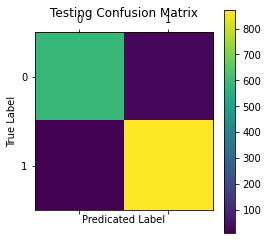

In [0]:
# Load the pretrained model from pytorch
PATH = saved_models_path + 'vgg16_FocalLoss_gamma0_5.pth'
model = models.vgg16(pretrained=False)
new_features = get_updated_features(model.classifier[0].in_features)
model.classifier = nn.Sequential(*new_features)
model.load_state_dict(torch.load(PATH))
print(model)
model.cuda()
display_model_evaluation_parameters(model, testloader, "Testing")

##Task1 Vgg16 with Focal Loss Completed

#Task2 Resnet18 wit BCELogit Loss

### Load pre-trained RESNET18

In [0]:
# Load the pretrained model from pytorch
model = models.resnet18(pretrained=True)
print(model)
print('Output Layer of RESNET18 : ', model.fc.out_features) # 1000 

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
 

### Replacing old FC Layers with 2 New FC Layers

In [0]:
new_features = get_updated_features(model.fc.in_features)
model.fc = nn.Sequential(*new_features)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Loss Function, Optimizer and Training

In [0]:
random.seed(1)

# Loss function and Optimizer
Epochs = 5
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

from tqdm import tqdm

training_accuracy = []
training_loss = []
validation_accuracy = []
validation_loss = []
model.to(device)
model.train()
for epoch in range(Epochs):  # loop over the dataset multiple times
    train_correct_count = 0
    val_correct_count = 0
    running_train_loss = 0.0
    running_val_loss = 0.0
    total = 0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        BATCH_SIZE = labels.size(0)
        
        one_hot_labels = to_one_hot_encoded_labels(labels, BATCH_SIZE)
        inputs, one_hot_labels = inputs.to(device), one_hot_labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)               #----> forward pass
        loss = criterion(outputs, one_hot_labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        total += BATCH_SIZE
        running_train_loss += loss.item()
        train_correct_count += get_correctly_classified_count(torch.sigmoid(model(inputs)), one_hot_labels, BATCH_SIZE)

        print(train_correct_count)
    val_total = 0

    with torch.no_grad():
      for data in validationloader:  
          images, labels = data
          BATCH_SIZE = labels.size(0)
          one_hot_labels = to_one_hot_encoded_labels(labels, BATCH_SIZE)
          images, one_hot_labels = images.to(device), one_hot_labels.to(device)
          outputs = model(images)
          loss = criterion(outputs, one_hot_labels)   #----> compute loss
          val_total += BATCH_SIZE
          running_val_loss += loss.item()
          val_correct_count += get_correctly_classified_count(torch.sigmoid(outputs), one_hot_labels, BATCH_SIZE)

    validation_accuracy.append(val_correct_count/val_total)
    validation_loss.append(running_val_loss)
    training_loss.append(running_train_loss)
    training_accuracy.append(train_correct_count/total)
    print("Epoch = %d, accuracy = %f, error = %f" %(epoch, train_correct_count/total, running_train_loss))

print('Finished Training')
print(training_loss)
print(training_accuracy)

1it [00:01,  1.29s/it]

1


2it [00:02,  1.28s/it]

4


3it [00:04,  1.33s/it]

12


4it [00:05,  1.30s/it]

23


5it [00:06,  1.29s/it]

40


6it [00:07,  1.27s/it]

67


7it [00:09,  1.32s/it]

102


8it [00:10,  1.35s/it]

143


9it [00:11,  1.32s/it]

191


10it [00:13,  1.33s/it]

236


11it [00:14,  1.39s/it]

285


12it [00:15,  1.34s/it]

334


13it [00:17,  1.32s/it]

383


14it [00:18,  1.33s/it]

432


15it [00:19,  1.31s/it]

481


16it [00:21,  1.33s/it]

530


17it [00:22,  1.40s/it]

579


18it [00:24,  1.49s/it]

628


19it [00:25,  1.42s/it]

677


20it [00:26,  1.37s/it]

726


21it [00:28,  1.34s/it]

775


22it [00:29,  1.33s/it]

824


23it [00:30,  1.31s/it]

873


24it [00:32,  1.30s/it]

922


25it [00:33,  1.28s/it]

971


26it [00:34,  1.31s/it]

1020


27it [00:35,  1.29s/it]

1069


28it [00:37,  1.28s/it]

1118


29it [00:38,  1.28s/it]

1167


30it [00:39,  1.27s/it]

1216


31it [00:41,  1.28s/it]

1265


32it [00:42,  1.30s/it]

1314


33it [00:43,  1.28s/it]

1363


34it [00:44,  1.28s/it]

1412


35it [00:46,  1.28s/it]

1461


36it [00:47,  1.31s/it]

1510


37it [00:48,  1.32s/it]

1559


38it [00:50,  1.29s/it]

1608


39it [00:51,  1.30s/it]

1657


40it [00:52,  1.28s/it]

1706


41it [00:53,  1.27s/it]

1755


42it [00:55,  1.31s/it]

1804


43it [00:56,  1.32s/it]

1853


44it [00:57,  1.30s/it]

1902


45it [00:59,  1.28s/it]

1951


46it [01:00,  1.27s/it]

2000


47it [01:01,  1.25s/it]

2049


48it [01:03,  1.39s/it]

2098


49it [01:04,  1.34s/it]

2147


50it [01:05,  1.32s/it]

2196


51it [01:07,  1.42s/it]

2245


52it [01:08,  1.38s/it]

2294


53it [01:10,  1.37s/it]

2343


54it [01:11,  1.34s/it]

2392


55it [01:12,  1.30s/it]

2441


56it [01:14,  1.59s/it]

2490


57it [01:16,  1.50s/it]

2539


58it [01:17,  1.46s/it]

2588


59it [01:19,  1.47s/it]

2637


60it [01:20,  1.41s/it]

2686


61it [01:21,  1.37s/it]

2735


62it [01:22,  1.33s/it]

2784


63it [01:24,  1.32s/it]

2833


64it [01:25,  1.33s/it]

2882


65it [01:26,  1.32s/it]

2931


66it [01:27,  1.29s/it]

2980


67it [01:29,  1.36s/it]

3029


68it [01:30,  1.34s/it]

3078


69it [01:32,  1.32s/it]

3127


70it [01:34,  1.53s/it]

3176


71it [01:35,  1.49s/it]

3225


72it [01:37,  1.54s/it]

3274


73it [01:38,  1.44s/it]

3323


74it [01:39,  1.40s/it]

3372


75it [01:40,  1.35s/it]

3421


76it [01:42,  1.32s/it]

3470


77it [01:43,  1.30s/it]

3519


78it [01:44,  1.28s/it]

3568


79it [01:45,  1.29s/it]

3617


80it [01:47,  1.33s/it]

3666


81it [01:48,  1.33s/it]

3715


82it [01:49,  1.31s/it]

3764


83it [01:51,  1.29s/it]

3813


84it [01:52,  1.27s/it]

3862


85it [01:53,  1.26s/it]

3911


86it [01:54,  1.26s/it]

3960


87it [01:56,  1.26s/it]

4009


88it [01:57,  1.27s/it]

4058


89it [01:58,  1.26s/it]

4107


90it [02:00,  1.30s/it]

4156


91it [02:01,  1.27s/it]

4205


92it [02:02,  1.28s/it]

4254


93it [02:03,  1.29s/it]

4303


94it [02:05,  1.28s/it]

4352


95it [02:06,  1.27s/it]

4401


96it [02:07,  1.26s/it]

4450


97it [02:09,  1.34s/it]

4499


98it [02:10,  1.39s/it]

4548


99it [02:11,  1.36s/it]

4597


100it [02:13,  1.34s/it]

4646


101it [02:14,  1.32s/it]

4695


102it [02:15,  1.30s/it]

4744


103it [02:17,  1.29s/it]

4793


104it [02:18,  1.28s/it]

4842


105it [02:19,  1.26s/it]

4891


106it [02:20,  1.25s/it]

4940


107it [02:22,  1.25s/it]

4989


108it [02:23,  1.27s/it]

5038


109it [02:24,  1.26s/it]

5087


110it [02:25,  1.25s/it]

5136


111it [02:27,  1.25s/it]

5185


112it [02:28,  1.25s/it]

5234


113it [02:29,  1.31s/it]

5283


114it [02:30,  1.29s/it]

5332


115it [02:32,  1.27s/it]

5381


116it [02:33,  1.29s/it]

5430


117it [02:34,  1.28s/it]

5479


118it [02:36,  1.27s/it]

5528


119it [02:37,  1.27s/it]

5577


120it [02:38,  1.26s/it]

5626


121it [02:39,  1.24s/it]

5675


122it [02:41,  1.31s/it]

5724


123it [02:42,  1.28s/it]

5773


124it [02:43,  1.32s/it]

5822



0it [00:00, ?it/s]

Epoch = 0, accuracy = 0.939032, error = 15.163631


1it [00:01,  1.30s/it]

49


2it [00:02,  1.30s/it]

98


3it [00:03,  1.29s/it]

147


4it [00:05,  1.32s/it]

196


5it [00:06,  1.29s/it]

245


6it [00:07,  1.27s/it]

294


7it [00:08,  1.28s/it]

343


8it [00:10,  1.27s/it]

392


9it [00:11,  1.31s/it]

441


10it [00:13,  1.43s/it]

490


11it [00:14,  1.47s/it]

539


12it [00:16,  1.46s/it]

588


13it [00:17,  1.41s/it]

637


14it [00:18,  1.36s/it]

686


15it [00:20,  1.33s/it]

735


16it [00:21,  1.30s/it]

784


17it [00:22,  1.28s/it]

833


18it [00:23,  1.29s/it]

882


19it [00:25,  1.39s/it]

931


20it [00:26,  1.35s/it]

980


21it [00:28,  1.32s/it]

1029


22it [00:29,  1.30s/it]

1078


23it [00:30,  1.30s/it]

1127


24it [00:31,  1.30s/it]

1176


25it [00:33,  1.35s/it]

1225


26it [00:34,  1.32s/it]

1274


27it [00:35,  1.31s/it]

1323


28it [00:37,  1.29s/it]

1372


29it [00:38,  1.28s/it]

1421


30it [00:39,  1.32s/it]

1470


31it [00:41,  1.30s/it]

1519


32it [00:42,  1.30s/it]

1568


33it [00:43,  1.39s/it]

1617


34it [00:45,  1.36s/it]

1666


35it [00:46,  1.32s/it]

1715


36it [00:47,  1.30s/it]

1764


37it [00:49,  1.33s/it]

1813


38it [00:50,  1.30s/it]

1862


39it [00:52,  1.42s/it]

1911


40it [00:53,  1.37s/it]

1960


41it [00:54,  1.34s/it]

2009


42it [00:56,  1.37s/it]

2058


43it [00:57,  1.33s/it]

2107


44it [00:58,  1.32s/it]

2156


45it [00:59,  1.31s/it]

2205


46it [01:01,  1.29s/it]

2254


47it [01:02,  1.27s/it]

2303


48it [01:03,  1.30s/it]

2352


49it [01:05,  1.31s/it]

2401


50it [01:06,  1.30s/it]

2450


51it [01:07,  1.28s/it]

2499


52it [01:08,  1.28s/it]

2548


53it [01:10,  1.27s/it]

2597


54it [01:11,  1.26s/it]

2646


55it [01:12,  1.26s/it]

2695


56it [01:13,  1.27s/it]

2744


57it [01:15,  1.28s/it]

2793


58it [01:16,  1.27s/it]

2842


59it [01:17,  1.28s/it]

2891


60it [01:18,  1.28s/it]

2940


61it [01:20,  1.28s/it]

2989


62it [01:21,  1.34s/it]

3038


63it [01:22,  1.31s/it]

3087


64it [01:24,  1.31s/it]

3136


65it [01:25,  1.35s/it]

3185


66it [01:27,  1.39s/it]

3234


67it [01:28,  1.36s/it]

3283


68it [01:29,  1.34s/it]

3332


69it [01:31,  1.42s/it]

3381


70it [01:32,  1.38s/it]

3430


71it [01:34,  1.37s/it]

3479


72it [01:35,  1.34s/it]

3528


73it [01:36,  1.32s/it]

3577


74it [01:37,  1.32s/it]

3626


75it [01:39,  1.31s/it]

3675


76it [01:40,  1.29s/it]

3724


77it [01:41,  1.29s/it]

3773


78it [01:42,  1.28s/it]

3822


79it [01:44,  1.27s/it]

3871


80it [01:45,  1.29s/it]

3920


81it [01:46,  1.28s/it]

3969


82it [01:48,  1.28s/it]

4018


83it [01:49,  1.28s/it]

4067


84it [01:50,  1.28s/it]

4116


85it [01:51,  1.27s/it]

4165


86it [01:53,  1.45s/it]

4214


87it [01:55,  1.48s/it]

4263


88it [01:56,  1.41s/it]

4312


89it [01:57,  1.37s/it]

4361


90it [01:59,  1.34s/it]

4410


91it [02:00,  1.46s/it]

4459


92it [02:02,  1.41s/it]

4508


93it [02:03,  1.38s/it]

4557


94it [02:04,  1.34s/it]

4606


95it [02:06,  1.35s/it]

4655


96it [02:07,  1.32s/it]

4704


97it [02:08,  1.31s/it]

4753


98it [02:09,  1.33s/it]

4802


99it [02:11,  1.30s/it]

4851


100it [02:12,  1.30s/it]

4900


101it [02:14,  1.36s/it]

4949


102it [02:15,  1.43s/it]

4998


103it [02:16,  1.38s/it]

5047


104it [02:18,  1.35s/it]

5096


105it [02:19,  1.37s/it]

5145


106it [02:21,  1.46s/it]

5194


107it [02:22,  1.40s/it]

5243


108it [02:23,  1.36s/it]

5292


109it [02:25,  1.33s/it]

5341


110it [02:26,  1.32s/it]

5390


111it [02:27,  1.38s/it]

5439


112it [02:29,  1.36s/it]

5488


113it [02:30,  1.33s/it]

5537


114it [02:31,  1.38s/it]

5586


115it [02:33,  1.34s/it]

5635


116it [02:34,  1.31s/it]

5684


117it [02:35,  1.33s/it]

5733


118it [02:37,  1.31s/it]

5782


119it [02:38,  1.45s/it]

5831


120it [02:40,  1.42s/it]

5880


121it [02:41,  1.38s/it]

5929


122it [02:42,  1.37s/it]

5978


123it [02:44,  1.35s/it]

6027


124it [02:45,  1.33s/it]

6076



0it [00:00, ?it/s]

Epoch = 1, accuracy = 0.980000, error = 5.337538


1it [00:01,  1.27s/it]

49


2it [00:02,  1.31s/it]

98


3it [00:03,  1.31s/it]

147


4it [00:05,  1.38s/it]

196


5it [00:07,  1.48s/it]

245


6it [00:08,  1.43s/it]

294


7it [00:10,  1.48s/it]

343


8it [00:11,  1.42s/it]

392


9it [00:12,  1.37s/it]

441


10it [00:14,  1.37s/it]

490


11it [00:15,  1.37s/it]

539


12it [00:16,  1.34s/it]

588


13it [00:18,  1.35s/it]

637


14it [00:19,  1.33s/it]

686


15it [00:20,  1.33s/it]

735


16it [00:21,  1.31s/it]

784


17it [00:23,  1.32s/it]

833


18it [00:24,  1.32s/it]

882


19it [00:25,  1.30s/it]

931


20it [00:27,  1.29s/it]

980


21it [00:28,  1.30s/it]

1029


22it [00:30,  1.44s/it]

1078


23it [00:31,  1.38s/it]

1127


24it [00:33,  1.50s/it]

1176


25it [00:34,  1.42s/it]

1225


26it [00:36,  1.47s/it]

1274


27it [00:37,  1.41s/it]

1323


28it [00:38,  1.38s/it]

1372


29it [00:39,  1.35s/it]

1421


30it [00:41,  1.33s/it]

1470


31it [00:42,  1.36s/it]

1519


32it [00:43,  1.33s/it]

1568


33it [00:45,  1.32s/it]

1617


34it [00:46,  1.30s/it]

1666


35it [00:48,  1.44s/it]

1715


36it [00:49,  1.39s/it]

1764


37it [00:50,  1.37s/it]

1813


38it [00:51,  1.31s/it]

1862


39it [00:53,  1.29s/it]

1911


40it [00:54,  1.27s/it]

1960


41it [00:55,  1.25s/it]

2009


42it [00:57,  1.31s/it]

2058


43it [00:58,  1.28s/it]

2107


44it [00:59,  1.25s/it]

2156


45it [01:00,  1.30s/it]

2205


46it [01:02,  1.26s/it]

2254


47it [01:03,  1.25s/it]

2303


48it [01:04,  1.27s/it]

2352


49it [01:05,  1.26s/it]

2401


50it [01:07,  1.25s/it]

2450


51it [01:08,  1.23s/it]

2499


52it [01:09,  1.24s/it]

2548


53it [01:10,  1.22s/it]

2597


54it [01:11,  1.24s/it]

2646


55it [01:13,  1.23s/it]

2695


56it [01:14,  1.26s/it]

2744


57it [01:15,  1.24s/it]

2793


58it [01:17,  1.31s/it]

2842


59it [01:18,  1.31s/it]

2891


60it [01:19,  1.31s/it]

2940


61it [01:20,  1.29s/it]

2989


62it [01:22,  1.27s/it]

3038


63it [01:23,  1.25s/it]

3087


64it [01:24,  1.25s/it]

3136


65it [01:26,  1.29s/it]

3185


66it [01:27,  1.26s/it]

3234


67it [01:28,  1.27s/it]

3283


68it [01:29,  1.26s/it]

3332


69it [01:30,  1.25s/it]

3381


70it [01:32,  1.24s/it]

3430


71it [01:33,  1.24s/it]

3479


72it [01:34,  1.27s/it]

3528


73it [01:36,  1.46s/it]

3577


74it [01:37,  1.38s/it]

3626


75it [01:39,  1.39s/it]

3675


76it [01:40,  1.35s/it]

3724


77it [01:41,  1.30s/it]

3773


78it [01:42,  1.28s/it]

3822


79it [01:44,  1.26s/it]

3871


80it [01:45,  1.27s/it]

3920


81it [01:47,  1.37s/it]

3969


82it [01:48,  1.33s/it]

4018


83it [01:50,  1.45s/it]

4067


84it [01:51,  1.39s/it]

4116


85it [01:52,  1.34s/it]

4165


86it [01:53,  1.30s/it]

4214


87it [01:54,  1.27s/it]

4263


88it [01:56,  1.30s/it]

4312


89it [01:57,  1.28s/it]

4361


90it [01:58,  1.26s/it]

4410


91it [01:59,  1.26s/it]

4459


92it [02:01,  1.32s/it]

4508


93it [02:02,  1.29s/it]

4557


94it [02:03,  1.27s/it]

4606


95it [02:05,  1.36s/it]

4655


96it [02:06,  1.32s/it]

4704


97it [02:07,  1.30s/it]

4753


98it [02:09,  1.31s/it]

4802


99it [02:10,  1.28s/it]

4851


100it [02:11,  1.28s/it]

4900


101it [02:13,  1.31s/it]

4949


102it [02:14,  1.28s/it]

4998


103it [02:15,  1.26s/it]

5047


104it [02:16,  1.24s/it]

5096


105it [02:17,  1.23s/it]

5145


106it [02:19,  1.22s/it]

5194


107it [02:20,  1.31s/it]

5243


108it [02:21,  1.28s/it]

5292


109it [02:23,  1.26s/it]

5341


110it [02:24,  1.24s/it]

5390


111it [02:25,  1.24s/it]

5439


112it [02:26,  1.24s/it]

5488


113it [02:28,  1.24s/it]

5537


114it [02:29,  1.26s/it]

5586


115it [02:30,  1.25s/it]

5635


116it [02:31,  1.30s/it]

5684


117it [02:33,  1.26s/it]

5733


118it [02:34,  1.25s/it]

5782


119it [02:35,  1.24s/it]

5831


120it [02:36,  1.25s/it]

5880


121it [02:38,  1.25s/it]

5929


122it [02:39,  1.24s/it]

5978


123it [02:40,  1.27s/it]

6027


124it [02:41,  1.31s/it]

6076



0it [00:00, ?it/s]

Epoch = 2, accuracy = 0.980000, error = 4.955177


1it [00:01,  1.25s/it]

49


2it [00:02,  1.24s/it]

98


3it [00:03,  1.24s/it]

147


4it [00:04,  1.24s/it]

196


5it [00:06,  1.23s/it]

245


6it [00:07,  1.23s/it]

294


7it [00:08,  1.22s/it]

343


8it [00:09,  1.23s/it]

392


9it [00:11,  1.23s/it]

441


10it [00:12,  1.27s/it]

490


11it [00:13,  1.26s/it]

539


12it [00:15,  1.31s/it]

588


13it [00:16,  1.29s/it]

637


14it [00:17,  1.38s/it]

686


15it [00:19,  1.35s/it]

735


16it [00:20,  1.30s/it]

784


17it [00:21,  1.29s/it]

833


18it [00:22,  1.26s/it]

882


19it [00:24,  1.25s/it]

931


20it [00:25,  1.28s/it]

980


21it [00:26,  1.26s/it]

1029


22it [00:27,  1.24s/it]

1078


23it [00:29,  1.25s/it]

1127


24it [00:30,  1.25s/it]

1176


25it [00:31,  1.29s/it]

1225


26it [00:32,  1.27s/it]

1274


27it [00:34,  1.26s/it]

1323


28it [00:35,  1.27s/it]

1372


29it [00:37,  1.41s/it]

1421


30it [00:38,  1.35s/it]

1470


31it [00:39,  1.36s/it]

1519


32it [00:41,  1.32s/it]

1568


33it [00:42,  1.30s/it]

1617


34it [00:43,  1.27s/it]

1666


35it [00:44,  1.25s/it]

1715


36it [00:45,  1.25s/it]

1764


37it [00:47,  1.23s/it]

1813


38it [00:48,  1.31s/it]

1862


39it [00:49,  1.29s/it]

1911


40it [00:51,  1.34s/it]

1960


41it [00:52,  1.34s/it]

2009


42it [00:53,  1.33s/it]

2058


43it [00:55,  1.34s/it]

2107


44it [00:57,  1.43s/it]

2156


45it [00:58,  1.40s/it]

2205


46it [00:59,  1.35s/it]

2254


47it [01:00,  1.32s/it]

2303


48it [01:01,  1.28s/it]

2352


49it [01:03,  1.26s/it]

2401


50it [01:04,  1.25s/it]

2450


51it [01:05,  1.25s/it]

2499


52it [01:06,  1.24s/it]

2548


53it [01:08,  1.26s/it]

2597


54it [01:09,  1.28s/it]

2646


55it [01:10,  1.28s/it]

2695


56it [01:12,  1.28s/it]

2744


57it [01:13,  1.44s/it]

2793


58it [01:15,  1.39s/it]

2842


59it [01:16,  1.36s/it]

2891


60it [01:17,  1.33s/it]

2940


61it [01:19,  1.39s/it]

2989


62it [01:21,  1.51s/it]

3038


63it [01:22,  1.56s/it]

3087


64it [01:23,  1.47s/it]

3136


65it [01:25,  1.41s/it]

3185


66it [01:26,  1.37s/it]

3234


67it [01:27,  1.34s/it]

3283


68it [01:29,  1.33s/it]

3332


69it [01:30,  1.32s/it]

3381


70it [01:32,  1.43s/it]

3430


71it [01:33,  1.41s/it]

3479


72it [01:34,  1.37s/it]

3528


73it [01:36,  1.36s/it]

3577


74it [01:37,  1.33s/it]

3626


75it [01:38,  1.32s/it]

3675


76it [01:39,  1.32s/it]

3724


77it [01:41,  1.30s/it]

3773


78it [01:42,  1.28s/it]

3822


79it [01:43,  1.29s/it]

3871


80it [01:45,  1.29s/it]

3920


81it [01:46,  1.44s/it]

3969


82it [01:48,  1.40s/it]

4018


83it [01:49,  1.42s/it]

4067


84it [01:50,  1.39s/it]

4116


85it [01:52,  1.37s/it]

4165


86it [01:53,  1.39s/it]

4214


87it [01:54,  1.36s/it]

4263


88it [01:56,  1.39s/it]

4312


89it [01:57,  1.36s/it]

4361


90it [01:59,  1.37s/it]

4410


91it [02:00,  1.35s/it]

4459


92it [02:01,  1.32s/it]

4508


93it [02:03,  1.36s/it]

4557


94it [02:04,  1.32s/it]

4606


95it [02:05,  1.31s/it]

4655


96it [02:06,  1.29s/it]

4704


97it [02:08,  1.37s/it]

4753


98it [02:09,  1.34s/it]

4802


99it [02:11,  1.34s/it]

4851


100it [02:12,  1.36s/it]

4900


101it [02:13,  1.33s/it]

4949


102it [02:14,  1.32s/it]

4998


103it [02:16,  1.31s/it]

5047


104it [02:17,  1.35s/it]

5096


105it [02:19,  1.35s/it]

5145


106it [02:20,  1.37s/it]

5194


107it [02:21,  1.34s/it]

5243


108it [02:23,  1.32s/it]

5292


109it [02:24,  1.31s/it]

5341


110it [02:25,  1.30s/it]

5390


111it [02:26,  1.29s/it]

5439


112it [02:28,  1.28s/it]

5488


113it [02:29,  1.33s/it]

5537


114it [02:31,  1.37s/it]

5586


115it [02:32,  1.34s/it]

5635


116it [02:33,  1.33s/it]

5684


117it [02:35,  1.36s/it]

5733


118it [02:36,  1.42s/it]

5782


119it [02:37,  1.37s/it]

5831


120it [02:39,  1.34s/it]

5880


121it [02:40,  1.34s/it]

5929


122it [02:41,  1.32s/it]

5978


123it [02:43,  1.35s/it]

6027


124it [02:44,  1.33s/it]

6076



0it [00:00, ?it/s]

Epoch = 3, accuracy = 0.980000, error = 5.026724


1it [00:01,  1.34s/it]

49


2it [00:02,  1.32s/it]

98


3it [00:03,  1.31s/it]

147


4it [00:05,  1.30s/it]

196


5it [00:06,  1.29s/it]

245


6it [00:07,  1.35s/it]

294


7it [00:09,  1.35s/it]

343


8it [00:10,  1.32s/it]

392


9it [00:11,  1.31s/it]

441


10it [00:13,  1.31s/it]

490


11it [00:14,  1.29s/it]

539


12it [00:15,  1.29s/it]

588


13it [00:17,  1.32s/it]

637


14it [00:18,  1.33s/it]

686


15it [00:19,  1.31s/it]

735


16it [00:20,  1.31s/it]

784


17it [00:22,  1.29s/it]

833


18it [00:23,  1.32s/it]

882


19it [00:24,  1.30s/it]

931


20it [00:26,  1.38s/it]

980


21it [00:27,  1.34s/it]

1029


22it [00:29,  1.33s/it]

1078


23it [00:30,  1.32s/it]

1127


24it [00:31,  1.30s/it]

1176


25it [00:32,  1.30s/it]

1225


26it [00:34,  1.29s/it]

1274


27it [00:35,  1.32s/it]

1323


28it [00:36,  1.31s/it]

1372


29it [00:38,  1.30s/it]

1421


30it [00:39,  1.36s/it]

1470


31it [00:41,  1.39s/it]

1519


32it [00:42,  1.37s/it]

1568


33it [00:43,  1.39s/it]

1617


34it [00:45,  1.36s/it]

1666


35it [00:46,  1.46s/it]

1715


36it [00:48,  1.41s/it]

1764


37it [00:49,  1.43s/it]

1813


38it [00:50,  1.39s/it]

1862


39it [00:52,  1.35s/it]

1911


40it [00:53,  1.33s/it]

1960


41it [00:54,  1.32s/it]

2009


42it [00:55,  1.31s/it]

2058


43it [00:57,  1.31s/it]

2107


44it [00:58,  1.30s/it]

2156


45it [00:59,  1.31s/it]

2205


46it [01:01,  1.30s/it]

2254


47it [01:02,  1.30s/it]

2303


48it [01:03,  1.28s/it]

2352


49it [01:04,  1.28s/it]

2401


50it [01:06,  1.27s/it]

2450


51it [01:07,  1.27s/it]

2499


52it [01:08,  1.27s/it]

2548


53it [01:10,  1.35s/it]

2597


54it [01:11,  1.33s/it]

2646


55it [01:12,  1.34s/it]

2695


56it [01:14,  1.31s/it]

2744


57it [01:15,  1.29s/it]

2793


58it [01:16,  1.29s/it]

2842


59it [01:18,  1.29s/it]

2891


60it [01:19,  1.32s/it]

2940


61it [01:20,  1.32s/it]

2989


62it [01:22,  1.32s/it]

3038


63it [01:23,  1.32s/it]

3087


64it [01:24,  1.41s/it]

3136


65it [01:26,  1.42s/it]

3185


66it [01:27,  1.42s/it]

3234


67it [01:29,  1.42s/it]

3283


68it [01:30,  1.38s/it]

3332


69it [01:31,  1.35s/it]

3381


70it [01:33,  1.34s/it]

3430


71it [01:34,  1.31s/it]

3479


72it [01:35,  1.34s/it]

3528


73it [01:37,  1.33s/it]

3577


74it [01:38,  1.38s/it]

3626


75it [01:39,  1.35s/it]

3675


76it [01:41,  1.33s/it]

3724


77it [01:42,  1.31s/it]

3773


78it [01:43,  1.35s/it]

3822


79it [01:45,  1.33s/it]

3871


80it [01:46,  1.32s/it]

3920


81it [01:47,  1.30s/it]

3969


82it [01:49,  1.38s/it]

4018


83it [01:50,  1.35s/it]

4067


84it [01:51,  1.34s/it]

4116


85it [01:53,  1.34s/it]

4165


86it [01:54,  1.34s/it]

4214


87it [01:55,  1.33s/it]

4263


88it [01:57,  1.32s/it]

4312


89it [01:58,  1.41s/it]

4361


90it [02:00,  1.42s/it]

4410


91it [02:01,  1.38s/it]

4459


92it [02:02,  1.35s/it]

4508


93it [02:04,  1.51s/it]

4557


94it [02:05,  1.45s/it]

4606


95it [02:07,  1.40s/it]

4655


96it [02:08,  1.36s/it]

4704


97it [02:10,  1.46s/it]

4753


98it [02:11,  1.40s/it]

4802


99it [02:13,  1.44s/it]

4851


100it [02:14,  1.39s/it]

4900


101it [02:15,  1.43s/it]

4949


102it [02:17,  1.46s/it]

4998


103it [02:18,  1.40s/it]

5047


104it [02:19,  1.37s/it]

5096


105it [02:21,  1.34s/it]

5145


106it [02:22,  1.32s/it]

5194


107it [02:23,  1.36s/it]

5243


108it [02:25,  1.42s/it]

5292


109it [02:27,  1.52s/it]

5341


110it [02:28,  1.56s/it]

5390


111it [02:30,  1.47s/it]

5439


112it [02:31,  1.53s/it]

5488


113it [02:33,  1.47s/it]

5537


114it [02:34,  1.43s/it]

5586


115it [02:35,  1.38s/it]

5635


116it [02:37,  1.35s/it]

5684


117it [02:38,  1.32s/it]

5733


118it [02:39,  1.33s/it]

5782


119it [02:40,  1.32s/it]

5831


120it [02:42,  1.35s/it]

5880


121it [02:43,  1.38s/it]

5929


122it [02:45,  1.35s/it]

5978


123it [02:46,  1.34s/it]

6027


124it [02:47,  1.35s/it]

6076


Epoch = 4, accuracy = 0.980000, error = 5.121284
Finished Training
[15.163630679249763, 5.337538069114089, 4.955177323892713, 5.026723939925432, 5.121283773332834]
[0.9390322580645162, 0.98, 0.98, 0.98, 0.98]


### Save the Model RESNET18

In [0]:
torch.save(model.state_dict(), save_models_path + 'res18_BCEwithLogitsLoss.pth')

### Accuracy and Loss Curves during Training

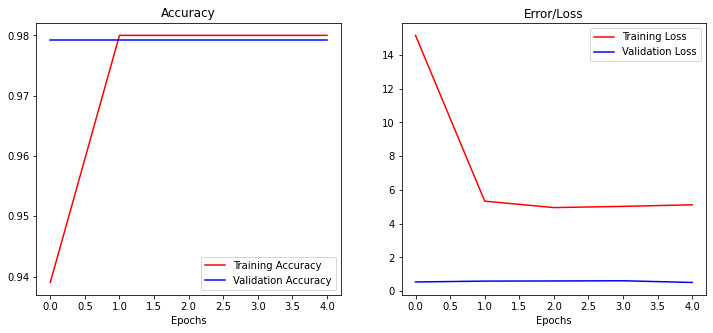

In [0]:
plot_loss_and_acc_curves(Epochs, training_accuracy, training_loss, validation_accuracy, validation_loss)

### Confusion Matrix, Accuracy and F1-Score

Training Accuracy of the network on the 12000 images: 95 %
Training F1 score: 0.965799
Training Confusion Matrix


<Figure size 432x288 with 0 Axes>

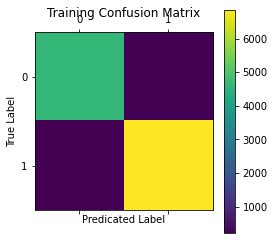

Testing Accuracy of the network on the 1500 images: 96 %
Testing F1 score: 0.974157
Testing Confusion Matrix


<Figure size 432x288 with 0 Axes>

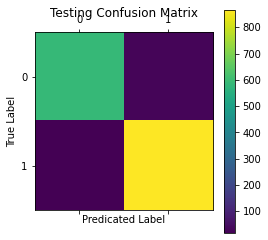

Validation Accuracy of the network on the 1500 images: 90 %
Validation F1 score: 0.921336
Validation Confusion Matrix


<Figure size 432x288 with 0 Axes>

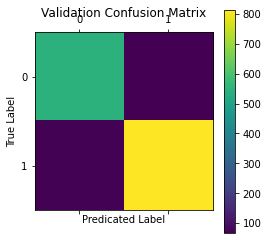

In [0]:
display_model_evaluation_parameters(model, trainloader, "Training")
# display_model_evaluation_parameters(model, testloader, "Testing")
display_model_evaluation_parameters(model, validationloader, "Validation")

### Evaluation: Load and Test my pre-trained RESNET18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

<Figure size 432x288 with 0 Axes>

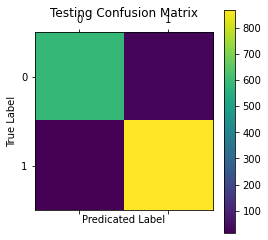

In [0]:
# Load the pretrained model from pytorch
PATH = saved_models_path + 'res18_BCEwithLogitsLoss.pth'
model = models.resnet18(pretrained=False)
new_features = get_updated_features(model.fc.in_features)
model.fc = nn.Sequential(*new_features)
model.load_state_dict(torch.load(PATH))
print(model)
model.cuda()
display_model_evaluation_parameters(model, testloader, "Testing")

##Task2 res18 with BCE Logit Loss

##Task2 res18 with Focal Loss

In [0]:
# Load the pretrained model from pytorch
model = models.resnet18(pretrained=True)
print(model)
print('Output Layer of RESNET18 : ', model.fc.out_features) # 1000 

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Freezing selective Convolution Layers and replace FC Layers

### Loss Function, Optimizer and Training

In [0]:
Learning_Rate = 0.001
random.seed(1)

def focal_loss(outputs, targets, gamma = 0.5):

    BATCH_SIZE = targets.size(0)
    outputs = torch.sigmoid(outputs)
    loss = 0
    for i in range(BATCH_SIZE):
      for j in range(NO_OF_CLASSES):
        ground_truth = targets[i][j]
        p_t = 0
        if ground_truth == 1:
          p_t = outputs[i][j]
        else:
          p_t = 1 - outputs[i][j]
        loss = - ((1 - p_t) ** gamma) * torch.log(p_t)
    loss = loss / BATCH_SIZE
    return loss

# Loss function and Optimizer
Epochs = 5
# criterion = nn.BCEWithLogitsLoss()
criterion = focal_loss
optimizer = optim.SGD(model.parameters(), lr=Learning_Rate, momentum=0.9)

from tqdm import tqdm

training_accuracy = []
training_loss = []
validation_accuracy = []
validation_loss = []
model.to(device)
model.train()
for epoch in range(Epochs):  # loop over the dataset multiple times
    train_correct_count = 0
    val_correct_count = 0
    running_train_loss = 0.0
    running_val_loss = 0.0
    total = 0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        BATCH_SIZE = labels.size(0)
        
        one_hot_labels = to_one_hot_encoded_labels(labels, BATCH_SIZE)
        inputs, one_hot_labels = inputs.to(device), one_hot_labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)               #----> forward pass
        loss = criterion(outputs, one_hot_labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        total += BATCH_SIZE
        running_train_loss += loss.item()
        outputs = classify_labels_wrt_probabilities(torch.sigmoid(model(inputs)), BATCH_SIZE)
        train_correct_count += ((outputs == one_hot_labels).sum().item()) / (NO_OF_CLASSES)

        print("Epoch = %d, accuracy = %f, error = %f" %(epoch, train_correct_count/total, running_train_loss))
    val_total = 0

    with torch.no_grad():
      for data in validationloader:  
          images, labels = data
          BATCH_SIZE = labels.size(0)
          one_hot_labels = to_one_hot_encoded_labels(labels, BATCH_SIZE)
          images, one_hot_labels = images.to(device), one_hot_labels.to(device)
          outputs = model(images)
          loss = criterion(outputs, one_hot_labels)   #----> compute loss
          val_total += BATCH_SIZE
          running_val_loss += loss.item()
          outputs = classify_labels_wrt_probabilities(torch.sigmoid(outputs), BATCH_SIZE)
          val_correct_count += ((outputs == one_hot_labels).sum().item()) / (NO_OF_CLASSES)

    validation_accuracy.append(val_correct_count/val_total)
    validation_loss.append(running_val_loss)
    training_loss.append(running_train_loss)
    training_accuracy.append(train_correct_count/total)
    print("Epoch = %d, accuracy = %f, error = %f" %(epoch, train_correct_count/total, running_train_loss))

print('Finished Training')
print(training_loss)
print(training_accuracy)

240it [05:30,  1.38s/it]
0it [00:00, ?it/s]

Epoch = 0, accuracy = 0.870833, error = 76.546386


240it [05:09,  1.29s/it]
0it [00:00, ?it/s]

Epoch = 1, accuracy = 0.924500, error = 50.657215


240it [05:00,  1.25s/it]
0it [00:00, ?it/s]

Epoch = 2, accuracy = 0.935917, error = 42.639047


240it [04:58,  1.24s/it]
0it [00:00, ?it/s]

Epoch = 3, accuracy = 0.941333, error = 39.482149


240it [04:57,  1.24s/it]
0it [00:00, ?it/s]

Epoch = 4, accuracy = 0.943583, error = 38.208244


240it [04:57,  1.24s/it]
0it [00:00, ?it/s]

Epoch = 5, accuracy = 0.946667, error = 35.751148


240it [05:01,  1.26s/it]
0it [00:00, ?it/s]

Epoch = 6, accuracy = 0.950750, error = 33.327876


240it [05:03,  1.26s/it]
0it [00:00, ?it/s]

Epoch = 7, accuracy = 0.953917, error = 31.642041


240it [05:02,  1.26s/it]
0it [00:00, ?it/s]

Epoch = 8, accuracy = 0.957250, error = 30.073682


240it [04:57,  1.24s/it]


Epoch = 9, accuracy = 0.959333, error = 29.103356
Finished Training
[76.54638580232859, 50.65721474587917, 42.63904733210802, 39.48214886523783, 38.20824368670583, 35.75114794075489, 33.32787596061826, 31.642040682956576, 30.073681605048478, 29.10335630737245]
[0.8708333333333333, 0.9245, 0.9359166666666666, 0.9413333333333334, 0.9435833333333333, 0.9466666666666667, 0.95075, 0.9539166666666666, 0.95725, 0.9593333333333334]


### Save the Model RESNET18

In [0]:
torch.save(model.state_dict(), saved_models_path + 'res18_partial.pth')

### Accuracy and Loss Curves during Training

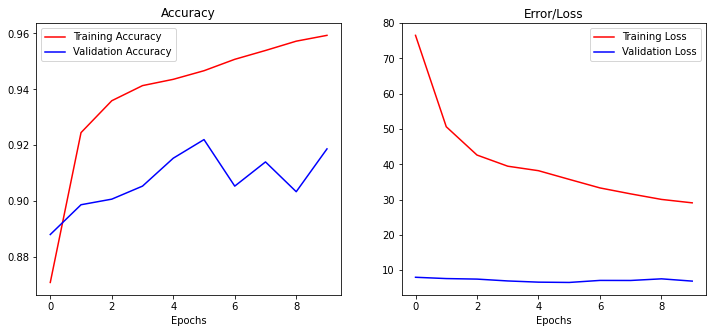

In [0]:
plot_loss_and_acc_curves(Epochs, training_accuracy, training_loss, validation_accuracy, validation_loss)

### Confusion Matrix, Accuracy and F1-Score

Training Accuracy of the network on the 12000 images: 96 %
Training F1 score: 0.967387
Training Confusion Matrix


<Figure size 432x288 with 0 Axes>

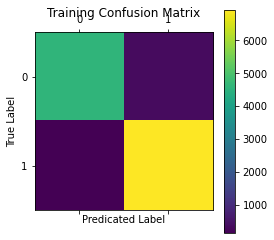

Testing Accuracy of the network on the 1500 images: 96 %
Testing F1 score: 0.973392
Testing Confusion Matrix


<Figure size 432x288 with 0 Axes>

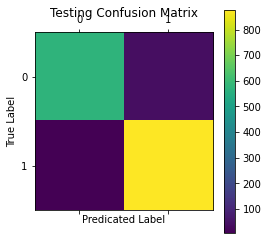

Validation Accuracy of the network on the 1500 images: 91 %
Validation F1 score: 0.932522
Validation Confusion Matrix


<Figure size 432x288 with 0 Axes>

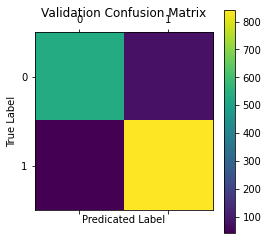

In [0]:
display_model_evaluation_parameters(model, trainloader, "Training")
display_model_evaluation_parameters(model, testloader, "Testing")
display_model_evaluation_parameters(model, validationloader, "Validation")

### Evaluation: Load and Test my pre-trained RESNET18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

<Figure size 432x288 with 0 Axes>

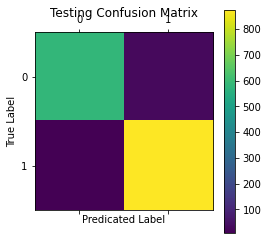

In [0]:
# Load the pretrained model from pytorch
PATH = saved_models_path + 'res18_partial.pth'
model = models.resnet18(pretrained=False)
new_features = get_updated_features(model.fc.in_features)
model.fc = nn.Sequential(*new_features)
model.load_state_dict(torch.load(PATH))
print(model)
model.cuda()
display_model_evaluation_parameters(model, testloader, "Testing")

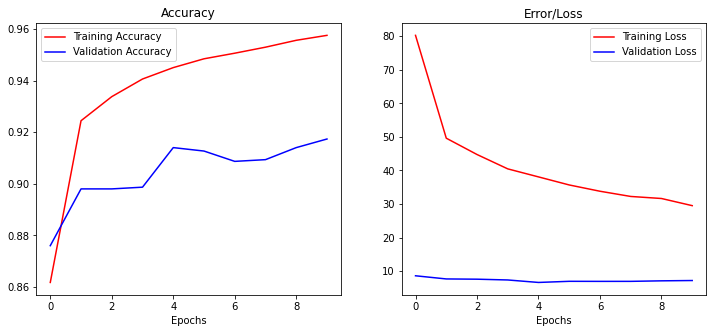

In [0]:
plot_loss_and_acc_curves(Epochs, training_accuracy, training_loss, validation_accuracy, validation_loss)

### Confusion Matrix, Accuracy and F1-Score

Training Accuracy of the network on the 12000 images: 95 %
Training F1 score: 0.963847
Training Confusion Matrix


<Figure size 432x288 with 0 Axes>

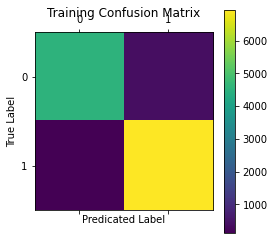

Testing Accuracy of the network on the 1500 images: 96 %
Testing F1 score: 0.970033
Testing Confusion Matrix


<Figure size 432x288 with 0 Axes>

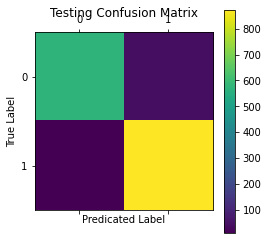

Validation Accuracy of the network on the 1500 images: 90 %
Validation F1 score: 0.921038
Validation Confusion Matrix


<Figure size 432x288 with 0 Axes>

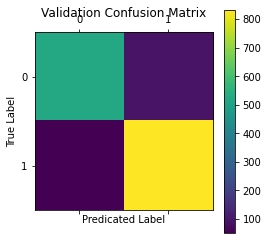

In [0]:
display_model_evaluation_parameters(model, trainloader, "Training")
display_model_evaluation_parameters(model, testloader, "Testing")
display_model_evaluation_parameters(model, validationloader, "Validation")